In [1]:
from collections import defaultdict
from math import ceil

from fairnessdatasets import Adult
import dill
from kmodes.kmodes import KModes
from scipy.stats import truncnorm, beta
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import torch
from torch import nn
from tqdm import tqdm
import random

from probspecs import *
from probspecs.distributions import *

from input_spaces import adult_input_space

torch.manual_seed(353710130163567)
np.random.seed(2548400)
random.seed(635404273475618)


/home/david/.miniconda3/envs/prob-specs/lib/python3.10/site-packages/torch/utils/cpp_extension.py:25: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  from pkg_resources import packaging  # type: ignore[attr-defined]


In [2]:
# dataset is with one-hot encodings and normalisation,
# dataset_raw is without.
dataset = Adult(root="../../.datasets", download=True)
test_set = Adult(root="../../.datasets", train=False, download=True)
dataset_raw = Adult(root="../../.datasets", raw=True, download=True)
test_data_raw = Adult(root="../../.datasets", train=False, raw=True, download=True)


Preprocessing data...
Preprocessing finished.


In [3]:
# We use data_df for plotting
data_df = pd.DataFrame(dataset_raw.data, columns=dataset_raw.columns)
# Convert categorical variables from integer ids to string names
for var, values in Adult.variables.items():
    if values is not None:
        data_df[f"{var}-names"] = data_df[var]
        for i, value in enumerate(values):
            data_df[f"{var}-names"].replace(i, value, inplace=True)


Changes in capital are split in the dataset across the variables "capital-gain" and "capital-loss".
Here, capital-loss is zero whenever capital-gain is greater zero and the other way around.
We summarize the two values in a single additional variable "capital-change".


In [4]:
data_df["capital-change"] = data_df["capital-gain"] - data_df["capital-loss"]
# Used later to differentiate original training data and generated data
data_df["dataset"] = "train"
data_df


age  workclass    fnlwgt  education  education-num  marital-status  \
0      39.0        5.0   77516.0        0.0           13.0             2.0   
1      50.0        1.0   83311.0        0.0           13.0             0.0   
2      38.0        0.0  215646.0        3.0            9.0             1.0   
3      53.0        0.0  234721.0        2.0            7.0             0.0   
4      28.0        0.0  338409.0        0.0           13.0             0.0   
...     ...        ...       ...        ...            ...             ...   
30157  27.0        0.0  257302.0        5.0           12.0             0.0   
30158  40.0        0.0  154374.0        3.0            9.0             0.0   
30159  58.0        0.0  151910.0        3.0            9.0             4.0   
30160  22.0        0.0  201490.0        3.0            9.0             2.0   
30161  52.0        2.0  287927.0        3.0            9.0             0.0   

       occupation  relationship  race  sex  ...   workclass-names  \
0             8.0           3.0   0.0  1.0  ...         State-gov   
1             4.0           2.0   0.0  1.0  ...  Self-emp-not-inc   
2             6.0           3.0   0.0  1.0  ...           Private   
3             6.0           2.0   4.0  1.0  ...           Private   
4             5.0           0.0   4.0  0.0  ...           Private   
...           ...           ...   ...  ...  ...               ...   
30157         0.0           0.0   0.0  0.0  ...           Private   
30158         7.0           2.0   0.0  1.0  ...           Private   
30159         8.0           5.0   0.0  0.0  ...           Private   
30160         8.0           1.0   0.0  1.0  ...           Private   
30161         4.0           0.0   0.0  0.0  ...      Self-emp-inc   

       education-names  marital-status-names   occupation-names  \
0            Bachelors         Never-married       Adm-clerical   
1            Bachelors    Married-civ-spouse    Exec-managerial   
2              HS-grad              Divorced  Handlers-cleaners   
3                 11th    Married-civ-spouse  Handlers-cleaners   
4            Bachelors    Married-civ-spouse     Prof-specialty   
...                ...                   ...                ...   
30157       Assoc-acdm    Married-civ-spouse       Tech-support   
30158          HS-grad    Married-civ-spouse  Machine-op-inspct   
30159          HS-grad               Widowed       Adm-clerical   
30160          HS-grad         Never-married       Adm-clerical   
30161          HS-grad    Married-civ-spouse    Exec-managerial   

      relationship-names race-names sex-names native-country-names  \
0          Not-in-family      White      Male        United-States   
1                Husband      White      Male        United-States   
2          Not-in-family      White      Male        United-States   
3                Husband      Black      Male        United-States   
4                   Wife      Black    Female                 Cuba   
...                  ...        ...       ...                  ...   
30157               Wife      White    Female        United-States   
30158            Husband      White      Male        United-States   
30159          Unmarried      White    Female        United-States   
30160          Own-child      White      Male        United-States   
30161               Wife      White    Female        United-States   

      capital-change dataset  
0             2174.0   train  
1                0.0   train  
2                0.0   train  
3                0.0   train  
4                0.0   train  
...              ...     ...  
30157            0.0   train  
30158            0.0   train  
30159            0.0   train  
30160            0.0   train  
30161        15024.0   train  

[30162 rows x 24 columns]

Some utilities for working with the data


In [5]:
# Map column names to column indices (especially relevant for one-hot encoded attributes)
col_idx = {
    var: [
        i
        for i, col in enumerate(dataset.columns)
        if col == var or col.startswith(f"{var}=")
    ]
    for var in adult_input_space.attribute_names
}
col_idx["capital-change"] = [-1]
col_raw_id = {  # for accessing non-one-hot-encoded categorical variables
    var: dataset_raw.columns.index(var) for var in adult_input_space.attribute_names
}


In [6]:
def entropy(frequencies):
    p = frequencies
    # avoid computing log of 0.0, instead replace by log(1.0) = 0.0
    return -np.sum(p * np.log(p))

def conditional_entropy(joint_frequencies, conditioned_on):
    # compute H(X|Y)
    p_xy = joint_frequencies
    p_y = p_xy.groupby(conditioned_on).sum()
    return -np.sum(p_xy * np.log(p_xy / p_y))

def uncertainty_coefficient(source_vars, target_var):
    """
    Measures association between variables. 
     - 0.0 => no association.
     - 1.0 => sources can predict target perfectly.
    """
    target_frequencies = data_df.value_counts(subset=[target_var], normalize=True)
    joint_frequencies = data_df.value_counts(subset=source_vars + [target_var], normalize=True)
    h_x = entropy(target_frequencies)
    h_x_given_y = conditional_entropy(joint_frequencies, source_vars)
    uncertainty_coef = (h_x - h_x_given_y) / h_x

    print(f"U({target_var}|{source_vars}) = {uncertainty_coef:.2f}")


## Marginal Distributions


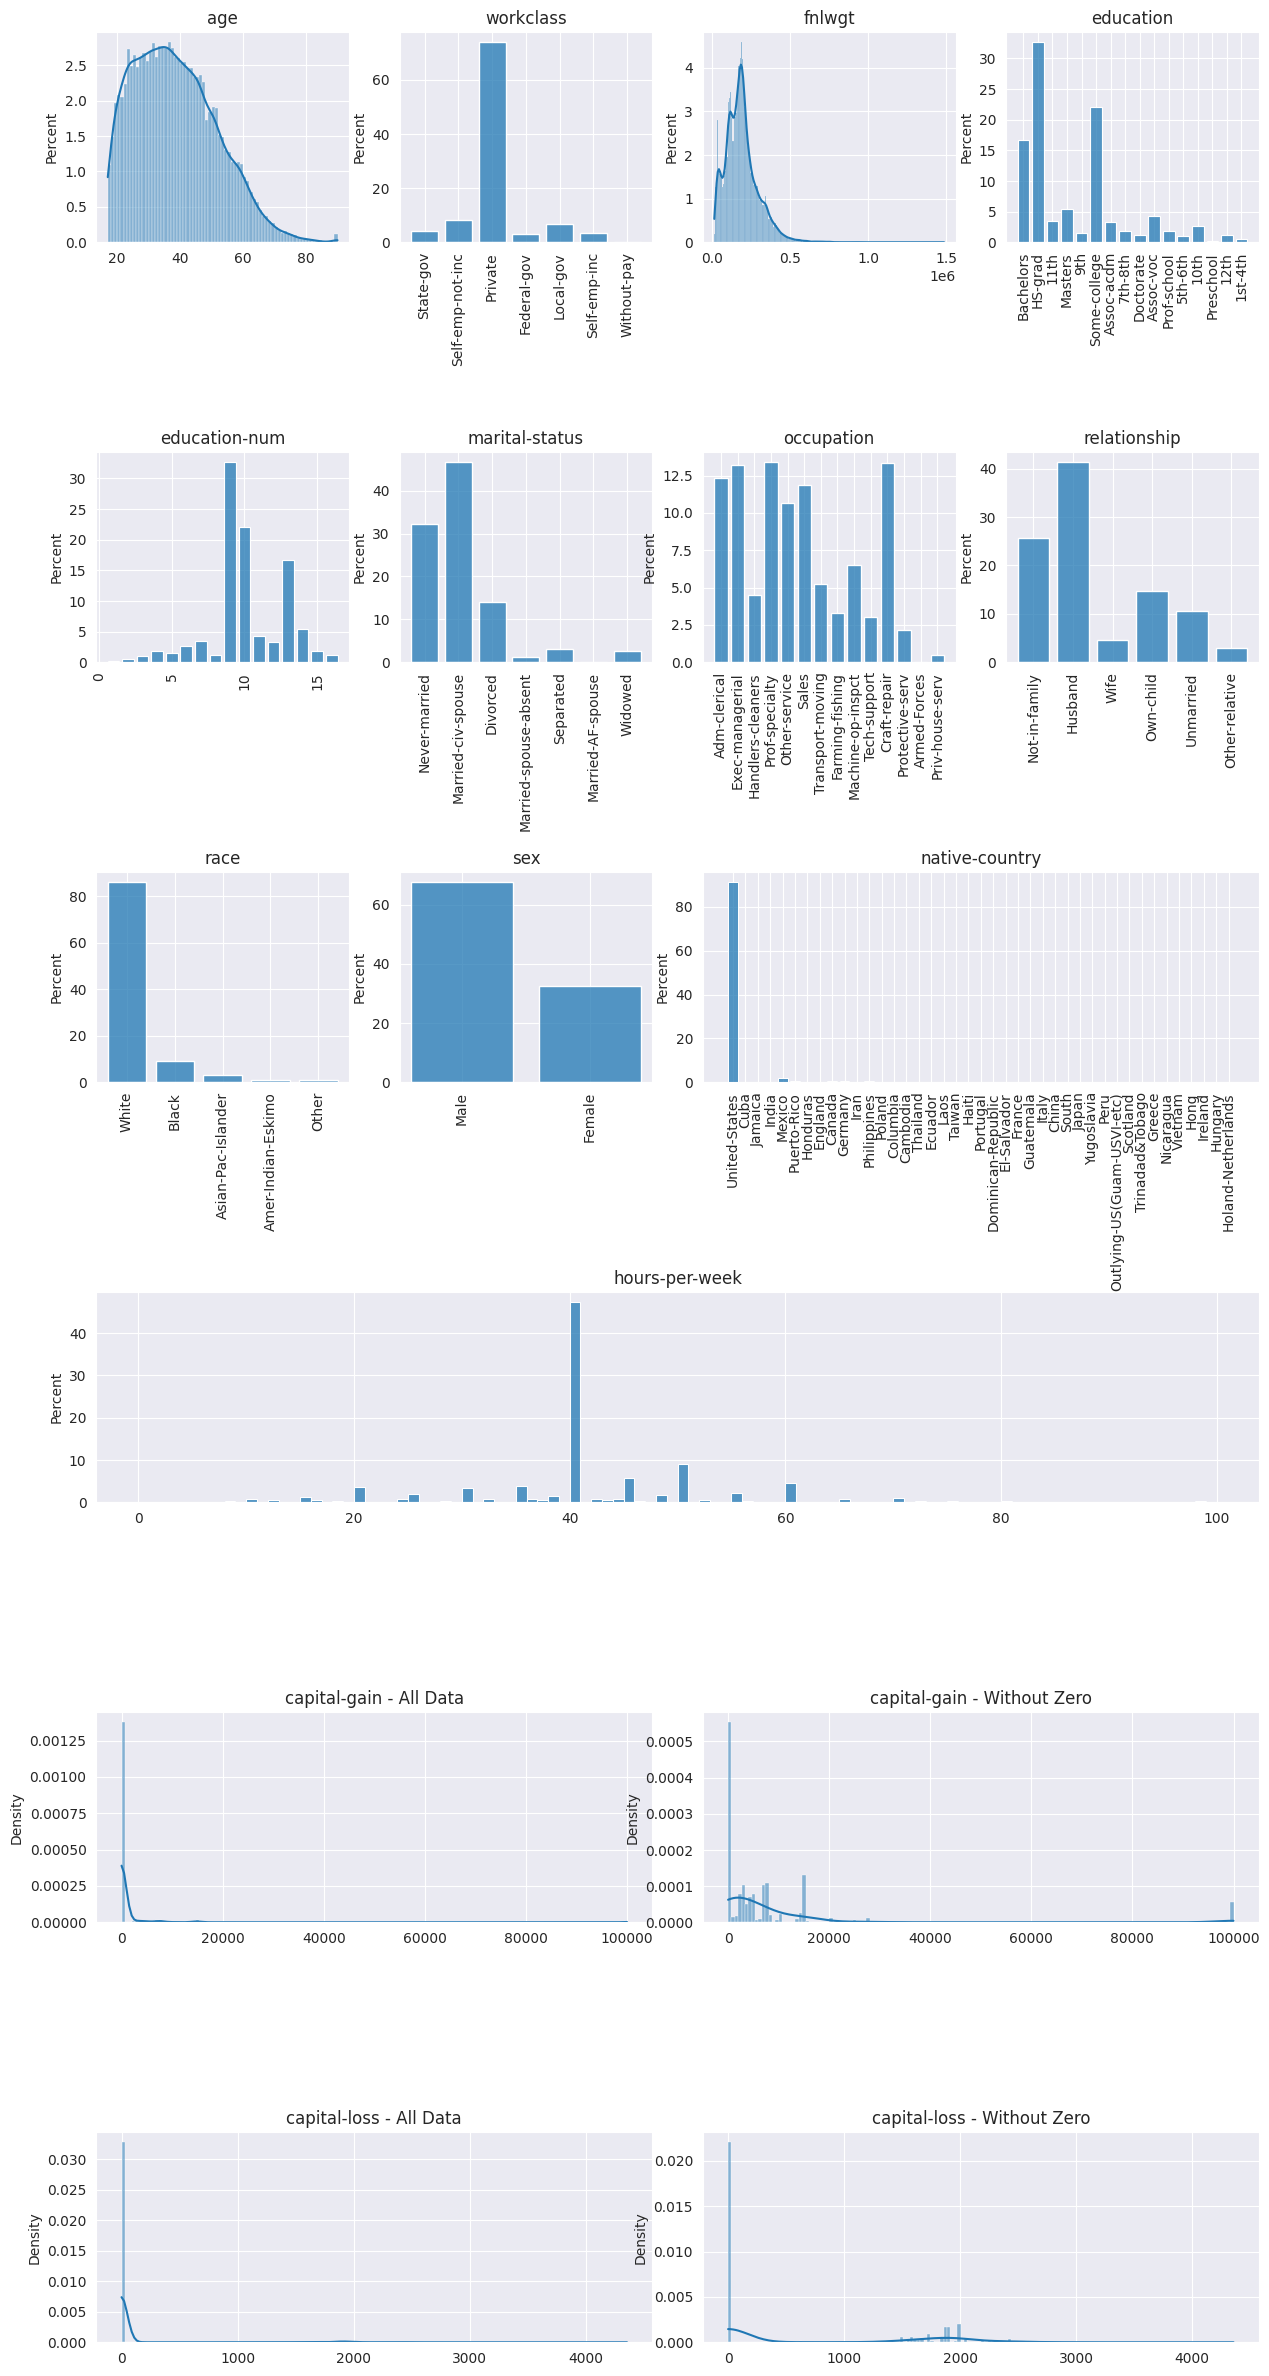

In [7]:
%%capture --no-stdout --no-display
fig, axes = plt.subplot_mosaic(
    [
        ["age", "workclass", "fnlwgt", "education"],
        ["education-num", "marital-status", "occupation", "relationship"],
        ["race", "sex", "native-country", "native-country"],
        ["hours-per-week"] * 4,
        ["capital-gain-full"] * 2 + ["capital-gain-non-zero"] * 2,
        ["capital-loss-full"] * 2 + ["capital-loss-non-zero"] * 2,
    ],
    figsize=(15, 30)
)
for var in adult_input_space.attribute_names:
    if var in (
        "workclass",
        "education",
        "education-num",
        "marital-status",
        "occupation",
        "relationship",
        "race",
        "sex",
        "native-country",
    ): # categorical variables
        var_show = var
        if var != "education-num":
            var_show = f"{var}-names"
        g = sns.histplot(
            data_df,
            x=var_show,
            discrete=True,
            shrink=0.8,
            multiple="dodge",
            stat="percent",
            common_norm=False,
            legend=False,
            ax=axes[var],
        )
        g.set(title=var, xlabel=None)
        axes[var].tick_params(axis='x', labelrotation=90)
    elif var.startswith("capital"):
        for exclude_zero in (True, False):
            if exclude_zero:
                df = data_df[data_df["capital-change"] != 0]
                ax_key = f"{var}-non-zero"
            else:
                df = data_df
                ax_key = f"{var}-full"
            g = sns.histplot(
                df,
                x=var,
                common_norm=False,
                stat="density",
                kde=True,
                bins=150,
                ax=axes[ax_key],
            )
            if not exclude_zero:
                g.set(title=f"{var} - All Data")
            else:
                g.set(title=f"{var} - Without Zero")
            g.set(xlabel=None)
    else:
        kwargs = {"legend": False}
        if var in ("age", "hours-per-week"):
            kwargs["binwidth"] = 1.0
            kwargs["legend"] = True
        if var == ("hours-per-week"):
            kwargs["multiple"] = "dodge"
        if var in ("age", "fnlwgt"):
            kwargs["kde"] = True
        g = sns.histplot(
            data_df,
            x=var,
            stat="percent",
            common_norm=False,
            ax=axes[var],
            **kwargs,
        )
        g.set(title=var, xlabel=None)
plt.subplots_adjust(hspace=1.0)


### Correlation Heatmap


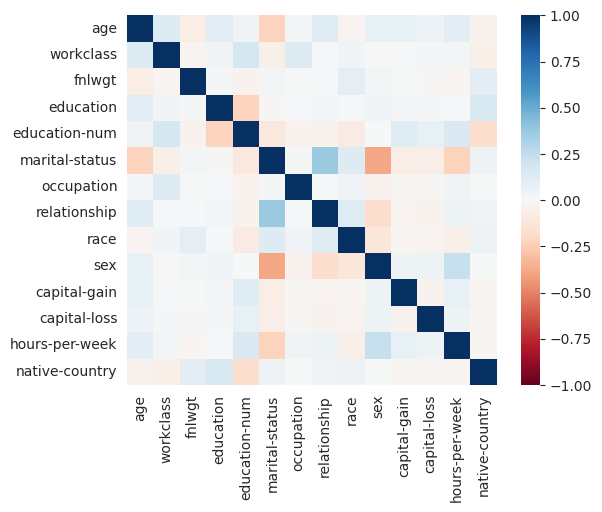

In [8]:
%%capture --no-stdout --no-display
_ = sns.heatmap(
    torch.corrcoef(dataset_raw.data.T),
    vmin=-1.0,
    vmax=1.0,
    square=True,
    cmap="RdBu",
    xticklabels=dataset_raw.columns,
    yticklabels=dataset_raw.columns,
)


## Duplicated Information
Some variables encode the same information, such as `sex` and `relationship`
with the values `Husband` and `Wife`.
We first have a closer look now at the relationships between the categorical variables.


In [9]:
uncertainty_coefficient(source_vars=["education"], target_var="education-num")
uncertainty_coefficient(source_vars=["occupation"], target_var="workclass")
uncertainty_coefficient(source_vars=["workclass"], target_var="occupation")
uncertainty_coefficient(source_vars=["relationship"], target_var="marital-status")
uncertainty_coefficient(source_vars=["marital-status"], target_var="relationship")
uncertainty_coefficient(source_vars=["relationship", "sex"], target_var="marital-status")


U(education-num|['education']) = 1.00
U(workclass|['occupation']) = 0.12
U(occupation|['workclass']) = 0.05
U(marital-status|['relationship']) = 0.57
U(relationship|['marital-status']) = 0.49
U(marital-status|['relationship', 'sex']) = 0.58


As we can see from the above, `education-num` is a complete duplicate of `education`.
There is also substantial overlap between `relationship` and `marital-status`.
Let's have a closer look.

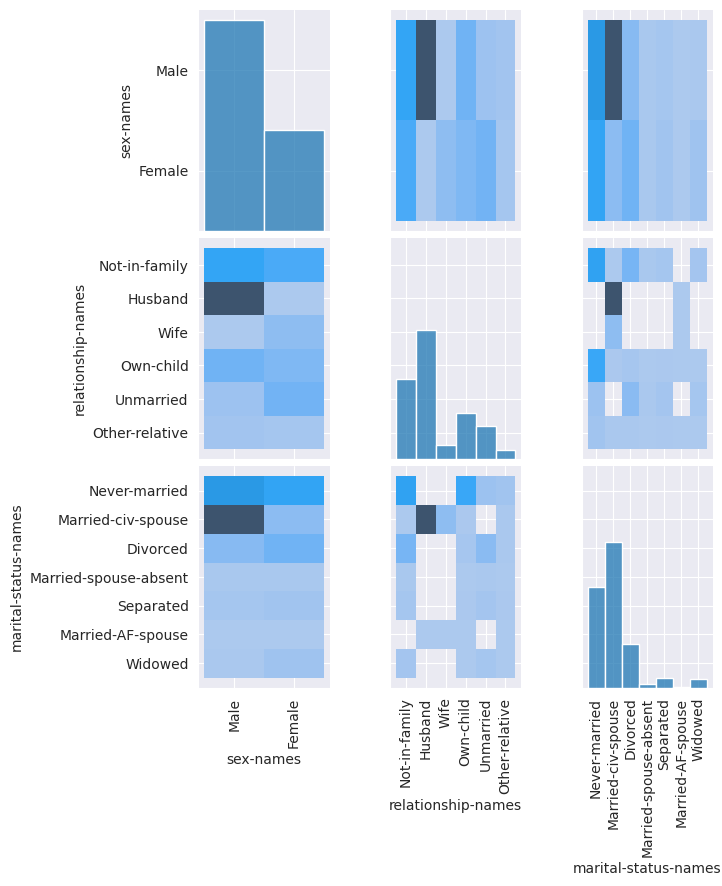

In [10]:
%%capture --no-stdout --no-display
g = sns.pairplot(
    data_df,
    vars=("sex-names", "relationship-names", "marital-status-names"),
    kind="hist",
    plot_kws={"discrete": True, "stat": "frequency"},
)
for ax in g.axes.flatten():
    ax.tick_params(axis='x', labelrotation=90)


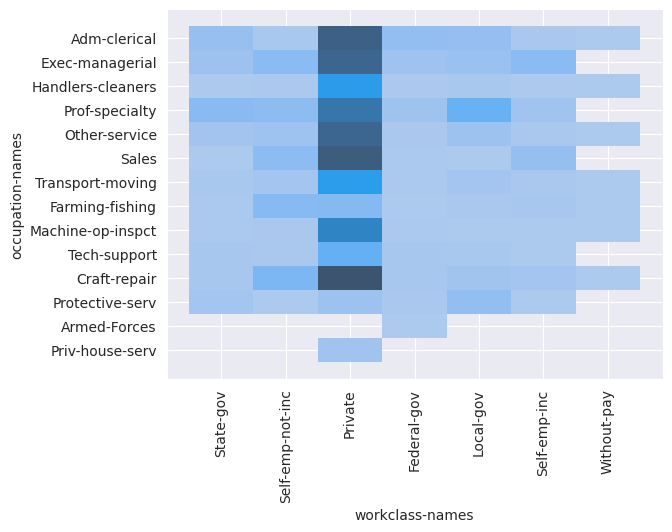

In [11]:
%%capture --no-stdout --no-display
g = sns.histplot(data_df, y="occupation-names", x="workclass-names", discrete=True, stat="frequency")
g.axes.tick_params(axis="x", labelrotation=90)


The blank fields in the above plots show that some information is duplicated
in the variables.

---


# Population Models
We are now ready to build our population models.

## General Utilities


In [12]:
def get_seed(string):
    as_bytes = bytes(string[:3] + string[-3:], "utf-8")
    return int.from_bytes(as_bytes, "big")

def _get_mean_std_min_max(data_, var=None, var_min=None, var_max=None):
    if var_min is not None:
        min_, max_ = var_min, var_max
    elif var is not None:
        min_, max_ = adult_input_space.attribute_bounds(var)
    else:
        raise ValueError("var and var_min/var_max may not both be None.")
    mean_ = data_.mean().item()
    std_ = data_.std().item()
    return mean_, std_, min_, max_


def make_truncnorm(data_, var=None, var_min=None, var_max=None):
    mean_, std_, min_, max_ = _get_mean_std_min_max(data_, var, var_min, var_max)
    # truncnorm needs min_ and max_ to be the number of standard deviations from loc
    min_ = (min_ - mean_) / std_
    max_ = (max_ - mean_) / std_
    distribution = truncnorm(a=min_, b=max_, loc=mean_, scale=std_)
    return AsInteger.wrap(distribution)


def make_gaussian_mixture(data_, n_components, n_restarts=1, var=None, var_min=None, var_max=None):
    if var is not None:
        bounds = adult_input_space.attribute_bounds(var)
    else:
        bounds = (var_min, var_max)
    seed = get_seed(f"mix-{var}")
    mixture = MixtureModel.fit_truncnorm_mixture(data_, bounds, n_components, n_restarts, seed=seed)
    return AsInteger(mixture)


def make_categorical(data_one_hot_):
    """Creates a one-hot categorical distribution"""
    class_frequencies = data_one_hot_.mean(dim=0)
    return CategoricalOneHot(class_frequencies)


def make_categorical_flat(data_, num_values):
    """
    Makes a "flat" categorical distribution, 
    producing values from 0 to n-1 (for n categories)
    """
    data_one_hot_ = torch.eye(num_values)[data_.long()]
    class_frequencies = data_one_hot_.mean(dim=0)
    class_frequencies = torch.clamp(class_frequencies, min=0.0, max=1.0)
    return Categorical(class_frequencies)


# Independent Population Model
Only model the variables separately, disregarding interactions between
variables. 
Note that under this assumption, a classifier can achieve fairness simply
by disregarding the sensitive attribute.
Therefore, the independent population model is only for testing purposes.

## Distributions
We fit Multinouli distributions to all categorical variables.

### Categorical Variables


In [13]:
distributions = {
    "workclass": make_categorical(dataset.data[:, col_idx["workclass"]]),
    "education": make_categorical(dataset.data[:, col_idx["education"]]),
    "marital-status": make_categorical(dataset.data[:, col_idx["marital-status"]]),
    "occupation": make_categorical(dataset.data[:, col_idx["occupation"]]),
    "relationship": make_categorical(dataset.data[:, col_idx["relationship"]]),
    "race": make_categorical(dataset.data[:, col_idx["race"]]),
    "sex": make_categorical(dataset.data[:, col_idx["sex"]]),
    "native-country": make_categorical(dataset.data[:, col_idx["native-country"]]),
}


In [14]:
n = 10000
generated_raw = {}
for var in distributions:
    # we have to use different seeds per variable, otherwise we would get
    # highly correlated samples
    values_one_hot = distributions[var].sample(n, seed=get_seed(var))
    values = np.argmax(values_one_hot, axis=1)
    generated_raw[var] = values

generated_df = pd.DataFrame(generated_raw)
generated_df["dataset"] = "generated"
df = pd.concat([generated_df, data_df])


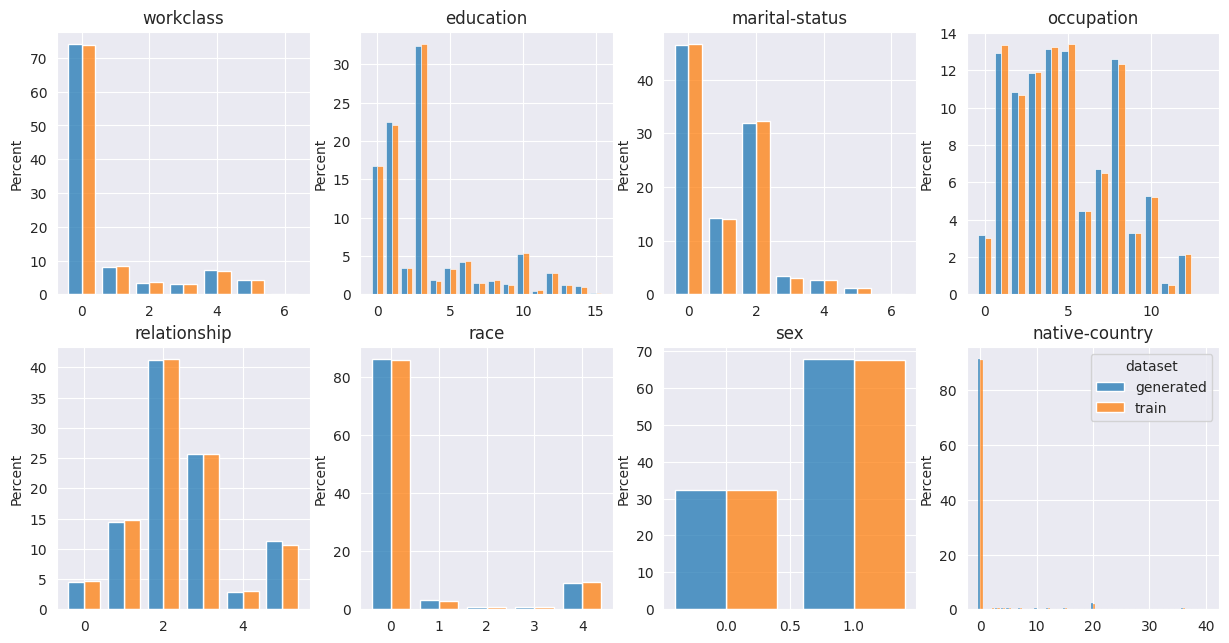

In [15]:
%%capture --no-stdout --no-display
fig, axes = plt.subplots(2, 4, figsize=(15, 7.5))
axes = axes.flatten()
for var, ax in zip(distributions.keys(), axes):
    ax.set_title(var)
    g = sns.histplot(
        df,
        x=var,
        hue="dataset",
        discrete=True,
        shrink=0.8,
        multiple="dodge",
        stat="percent",
        common_norm=False,
        ax=ax,
        legend=var == "native-country",
    )
    g.set(xlabel=None)


### Continuous Variables

For the continuous variables, we use
- age: truncated normal distribution
- fnlwght: Beta distribution
- education-num: Categorical distribution (as there are few values)
- hours-per-week: Categorical distribution (as the distribution is pretty spiky)
- capital-gain: Gaussian Mixture Model
- capital-loss: Gaussian Mixture Model

All "continuous" variables in the Adult dataset are actually integer variables.
Therefore, we wrap all distributions as a `AsInteger`.

#### Age
The histogram of `age` looks a lot like a normal distribution.


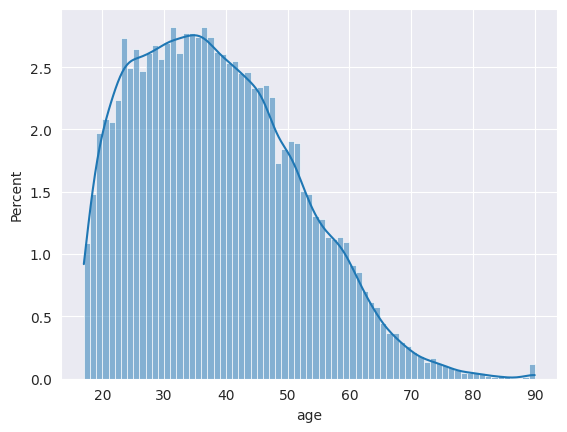

In [16]:
%%capture --no-stdout --no-display
_ = sns.histplot(
    data_df, x="age", stat="percent", kde=True, binwidth=1.0,
)


In [17]:
age_min, age_max = adult_input_space.attribute_bounds("age")

age_loc = 33.0
age_scale = 17.0
distributions["age"] = AsInteger.wrap(truncnorm(
    a=(age_min - age_loc) / age_scale,
    b=(age_max - age_loc) / age_scale,
    loc=age_loc,
    scale=age_scale,
))


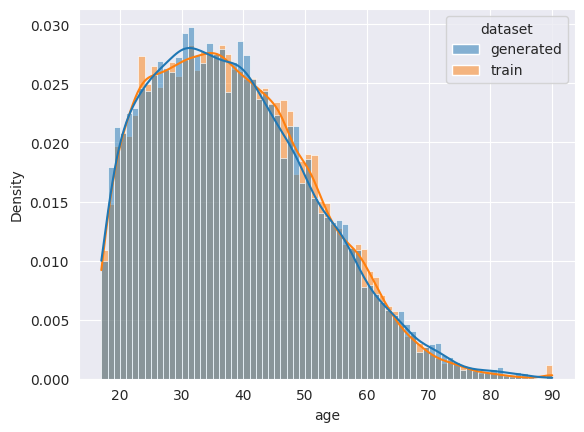

In [18]:
%%capture --no-stdout --no-display
age_data = distributions["age"].sample(n, seed=get_seed("age"))

generated_df["age"] = age_data
df = pd.concat([generated_df, data_df])

_ = sns.histplot(
    df, x="age", hue="dataset", stat="density", common_norm=False, kde=True, binwidth=1.0
)


#### fnlwgt
`fnlwgt` is an estimate of a proportion, so we model it using a Beta distribution.


In [19]:
# The beta distribution produces values between 0.0 and 1.0. 
# Therefore, we want to move 0.0 to fnlwgt_min and 1.0 to fnlwgt_max
fnlwgt_min, fnlwgt_max = adult_input_space.attribute_bounds("fnlwgt")
fnlwgt_data = dataset_raw.data[:, col_raw_id["fnlwgt"]]
distributions["fnlwgt"] = AsInteger.wrap(UnivariateContinuousDistribution(
    beta(
        a=4.25,
        b=30.0,
        loc=fnlwgt_min,  
        scale=fnlwgt_max,
    ), 
    bounds=(fnlwgt_min, fnlwgt_max)
))


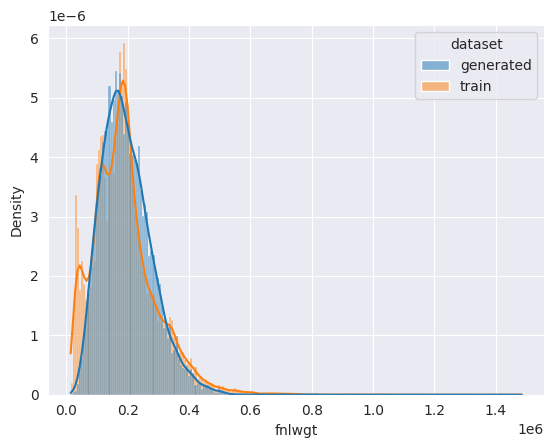

In [20]:
%%capture --no-stdout --no-display
fnlwgt_data = distributions["fnlwgt"].sample(n, seed=get_seed("fnlwgt"))

generated_df["fnlwgt"] = fnlwgt_data
df = pd.concat([generated_df, data_df])

_ = sns.histplot(
    df, x="fnlwgt", hue="dataset", stat="density", common_norm=False, kde=True
)


#### education-num
Education num has few discrete values, so we model it using a categorical
distribution.
The one-hot values of the categorical distribution are converted to 


In [21]:
edu_num_data = dataset_raw.data[:, col_raw_id["education-num"]]
edu_num_num_values = edu_num_data.max() + 1
distributions["education-num"] = make_categorical_flat(edu_num_data, int(edu_num_num_values))


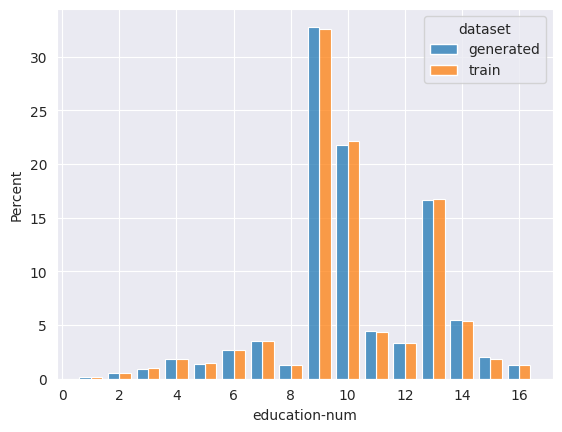

In [22]:
%%capture --no-stdout --no-display
edu_num_data = distributions["education-num"].sample(n, seed=get_seed("education-num"))
generated_df["education-num"] = edu_num_data
df = pd.concat([generated_df, data_df])

_ = sns.histplot(
    df,
    x="education-num",
    hue="dataset",
    discrete=True,
    shrink=0.8,
    multiple="dodge",
    stat="percent",
    common_norm=False,
    legend=True
)


#### hours-per-week
When we look at `hours-per-week`, we see a scattered distribution.


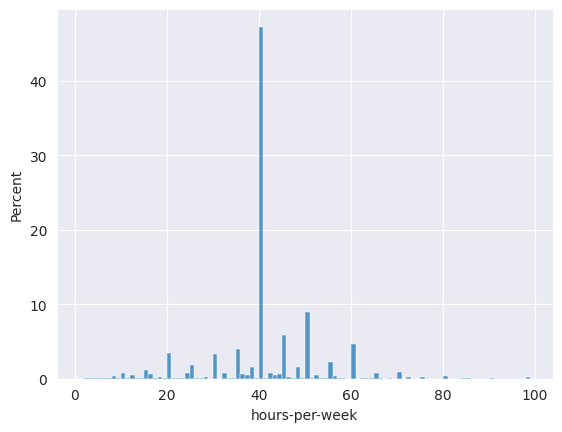

In [23]:
%%capture --no-stdout --no-display
_ = sns.histplot(
    data_df, x="hours-per-week", stat="percent", binwidth=1.0,
)


In [24]:
work_hours_data = dataset_raw.data[:, col_raw_id["hours-per-week"]]
work_hours_data = work_hours_data.reshape(-1, 1)
distributions["hours-per-week"] = make_categorical_flat(work_hours_data, 100)


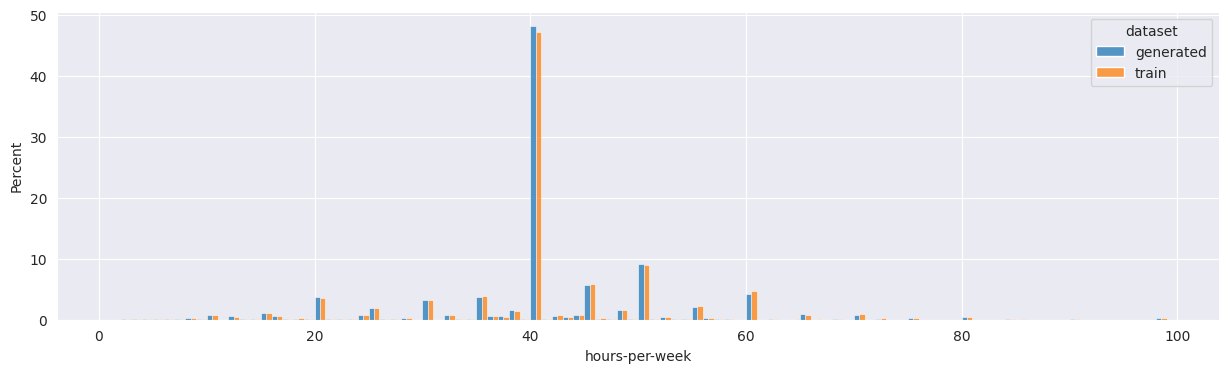

In [25]:
%%capture --no-stdout --no-display
work_hours_data = distributions["hours-per-week"].sample(n, seed=get_seed("hours-per-week"))

generated_df["hours-per-week"] = work_hours_data.reshape(-1)
df = pd.concat([generated_df, data_df])

fig, ax = plt.subplots(figsize=(15.0, 4.0))
_ = sns.histplot(
    df,
    x="hours-per-week",
    hue="dataset",
    multiple="dodge",
    stat="percent",
    common_norm=False,
    binwidth=1.0,
    legend=True,
    ax=ax,
)


#### capital-gain
The empirical distribution of `capital-gain` is complex.


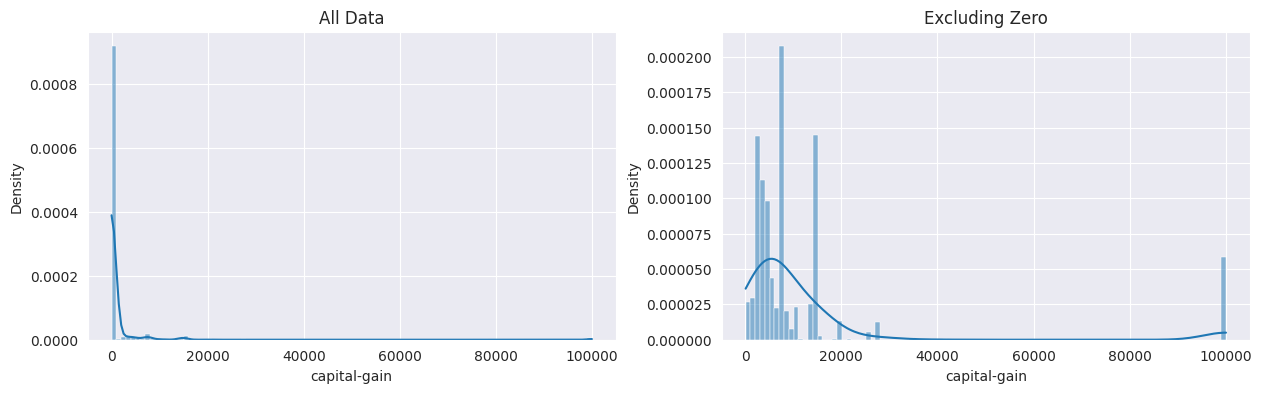

In [26]:
%%capture --no-stdout --no-display
_, axes = plt.subplots(1, 2, figsize=(15.0, 4.0))
_ = sns.histplot(
    data_df,
    x="capital-gain",
    stat="density",
    kde=True,
    bins=100,
    ax=axes[0]
)
_ = sns.histplot(
    data_df[data_df["capital-gain"] > 0],
    x="capital-gain",
    stat="density",
    kde=True,
    bins=100,
    ax=axes[1]
)
_ = axes[0].set_title("All Data")
_ = axes[1].set_title("Excluding Zero")


We model the outliers `0` (this stems from the complementarity of 
`capital-gain` and `capital-loss`) and `100000` using a Categorical distribution.
For the remainder of the data, we fit a Gaussian mixture model.


In [27]:
capital_gain_data = data_df["capital-gain"]
outliers = [0, capital_gain_data.max()]
outlier_data = capital_gain_data[capital_gain_data.isin(outliers)]
regular_data = capital_gain_data[~capital_gain_data.isin(outliers)]

outlier_count = outlier_data.astype(int).value_counts(normalize=True)
outliers_distribution = Categorical(
    [outlier_count[o] for o in outliers], outliers
)

regular_data = regular_data.to_numpy().reshape(-1, 1)
mixture_model = make_gaussian_mixture(regular_data, var="capital-gain", n_components=3, n_restarts=3)
mixture_model = mixture_model.continuous_distribution

# add the outlier distribution to the mixture model
components = list(mixture_model.distributions) + [outliers_distribution]
weights = list(mixture_model.weights * len(regular_data)/len(data_df))
weights += [len(outlier_data)/len(data_df)]
distributions["capital-gain"] = AsInteger(MixtureModel(weights, components))


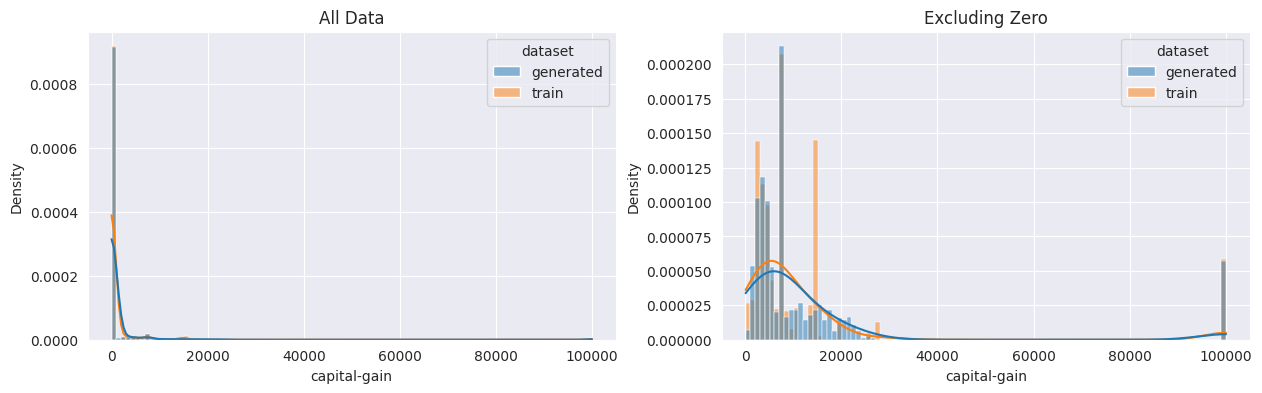

In [28]:
%%capture --no-stdout --no-display
capital_gain_data = distributions["capital-gain"].sample(n, seed=get_seed("capital-gain"))

generated_df["capital-gain"] = capital_gain_data.reshape(-1)
df = pd.concat([generated_df, data_df])

_, axes = plt.subplots(1, 2, figsize=(15.0, 4.0))
_ = sns.histplot(
    df,
    x="capital-gain",
    hue="dataset",
    stat="density",
    kde=True,
    bins=100,
    common_norm=False,
    ax=axes[0]
)
_ = sns.histplot(
    df[df["capital-gain"] > 0],
    x="capital-gain",
    hue="dataset",
    stat="density",
    kde=True,
    bins=100,
    common_norm=False,
    ax=axes[1]
)
_ = axes[0].set_title("All Data")
_ = axes[1].set_title("Excluding Zero")


#### capital-loss
The `capital-loss` feature is a little less complex than the `capital-gain`
feature, but has some of the same issues.
Notably, it also has an outlier at `0` for the same reasons as `capital-gain` has one.

We model `capital-loss` the same way as we model `capital-gain`.


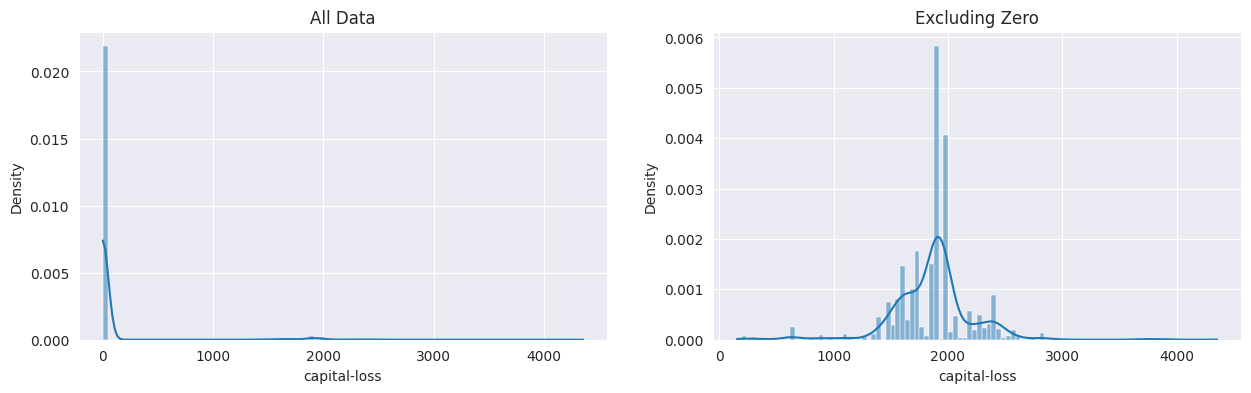

In [29]:
%%capture --no-stdout --no-display
_, axes = plt.subplots(1, 2, figsize=(15.0, 4.0))
_ = sns.histplot(
    data_df,
    x="capital-loss",
    stat="density",
    kde=True,
    bins=100,
    ax=axes[0]
)
_ = sns.histplot(
    data_df[data_df["capital-loss"] > 0],
    x="capital-loss",
    stat="density",
    kde=True,
    bins=100,
    ax=axes[1]
)
_ = axes[0].set_title("All Data")
_ = axes[1].set_title("Excluding Zero")


In [30]:
capital_loss_data = data_df["capital-loss"]
outlier_data = capital_loss_data[capital_loss_data == 0.0]
regular_data = capital_loss_data[capital_loss_data > 0.0]

outliers_distribution = Categorical([1.0], [0.0])

regular_data = regular_data.to_numpy().reshape(-1, 1)
mixture_model = make_gaussian_mixture(regular_data, var="capital-loss", n_components=8, n_restarts=3)
mixture_model = mixture_model.continuous_distribution

# add the outlier distribution to the mixture model
components = list(mixture_model.distributions) + [outliers_distribution]
weights = list(mixture_model.weights * len(regular_data)/len(data_df))
weights += [len(outlier_data)/len(data_df)]
distributions["capital-loss"] = AsInteger(MixtureModel(weights, components))


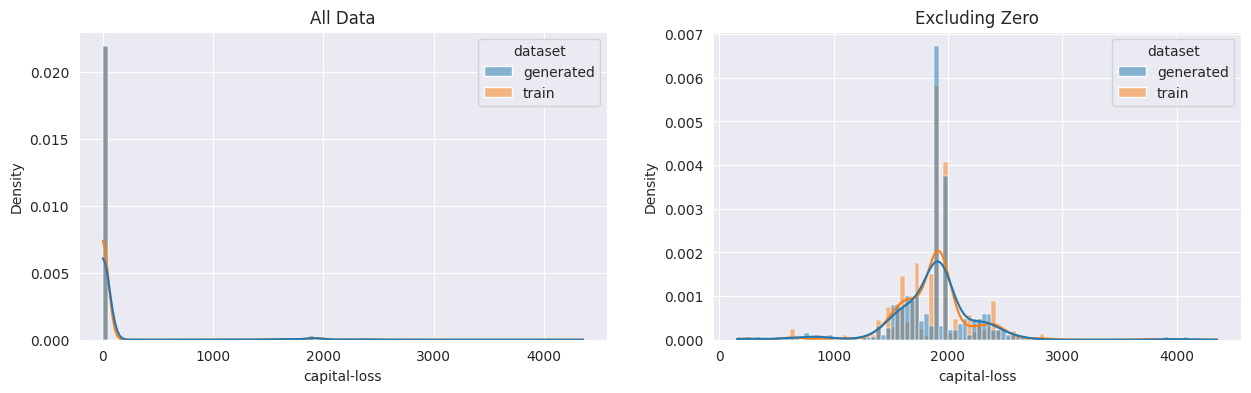

In [31]:
%%capture --no-stdout --no-display
capital_loss_data = distributions["capital-loss"].sample(n, seed=get_seed("capital-loss"))

generated_df["capital-loss"] = capital_loss_data.reshape(-1)
df = pd.concat([generated_df, data_df])

_, axes = plt.subplots(1, 2, figsize=(15.0, 4.0))
_ = sns.histplot(
    df,
    x="capital-loss",
    hue="dataset",
    stat="density",
    kde=True,
    bins=100,
    common_norm=False,
    ax=axes[0]
)
_ = sns.histplot(
    df[df["capital-loss"] > 0],
    x="capital-loss",
    hue="dataset",
    stat="density",
    kde=True,
    bins=100,
    common_norm=False,
    ax=axes[1]
)
_ = axes[0].set_title("All Data")
_ = axes[1].set_title("Excluding Zero")


### Compare Correlation Matrices
Just to remind ourselves that this is the *independent* population model,
that is, all the variables are independent.


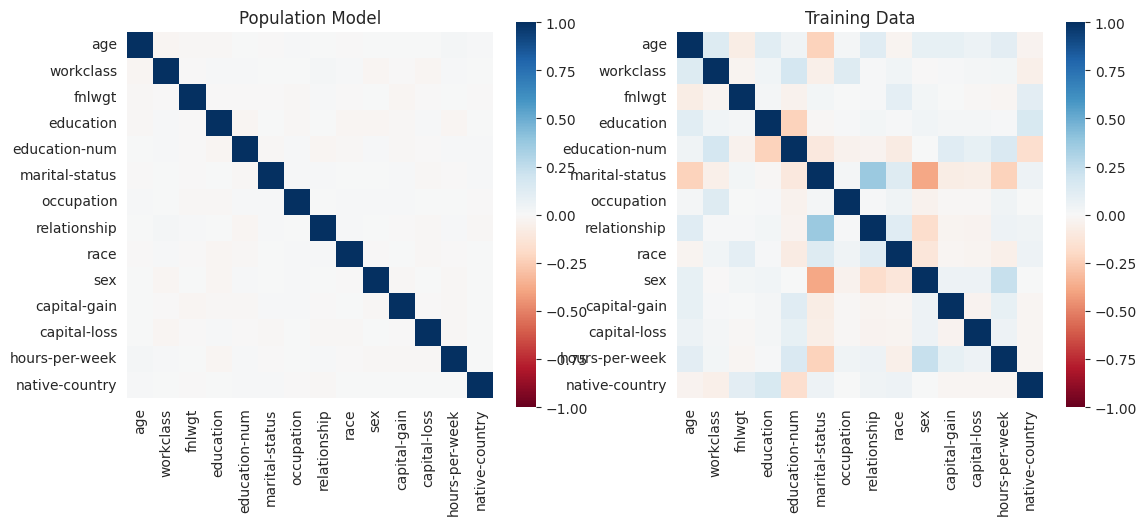

In [32]:
fig, axes = plt.subplots(1, 2, figsize=(13, 5))

axes[0].set_title("Population Model")
generated_df_ = generated_df.drop("dataset", axis=1)
_ = sns.heatmap(
    np.corrcoef(generated_df_.to_numpy().T),
    vmin=-1.0,
    vmax=1.0,
    square=True,
    cmap="RdBu",
    xticklabels=dataset_raw.columns,
    yticklabels=dataset_raw.columns,
    ax=axes[0],
)
axes[1].set_title("Training Data")
_ = sns.heatmap(
    torch.corrcoef(dataset_raw.data.T),
    vmin=-1.0,
    vmax=1.0,
    square=True,
    cmap="RdBu",
    xticklabels=dataset_raw.columns,
    yticklabels=dataset_raw.columns,
    ax=axes[1],
)


### Export Population Model

We need to export the probability distribution and a description of the space 
of values that are produced by the probability distribution.
Additionally, the values of the continuous attributes need to be normalized before 
being fed to a classifier.
We perform normalization sing a linear neural network layer.


In [33]:
# Input Space
ind_input_space = adult_input_space

# Distribution
ind_distribution = MultivariateIndependent(
    *[distributions[var] for var in ind_input_space.attribute_names], 
    event_shape=ind_input_space.input_shape,
)

# Transformation (z-Score Normalization)
mean = dataset_raw.data.mean(dim=0)
std = dataset_raw.data.std(dim=0)
# we want to calculate: (x - mean) / std = x/std - mean/std
weight = torch.zeros(adult_input_space.input_shape + ind_input_space.input_shape)
bias = torch.zeros(adult_input_space.input_shape)
w_i = w_j = 0
for i, var in enumerate(ind_input_space.attribute_names):
    match ind_input_space.attribute_type(var):
        case TabularInputSpace.AttributeType.CATEGORICAL:
            for _ in range(len(ind_input_space.attribute_values(var))):
                weight[w_i, w_j] = 1.0
                w_i += 1
                w_j += 1
        case _:
            weight[w_i, w_j] = 1/std[i]
            bias[w_i] = mean[i]/std[i]
            w_i += 1
            w_j += 1
ind_transform = nn.Linear(weight.size(1), weight.size(0), bias=True)
with torch.no_grad():
    ind_transform.weight = nn.Parameter(weight, requires_grad=False)
    ind_transform.bias = nn.Parameter(bias, requires_grad=False)


In [34]:
torch.save(
    (ind_distribution, ind_input_space, ind_transform),
    "../../resources/adult/independent_population_model.pyt",
    pickle_module=dill,
)


## Bayesian Network Population Model

For this population model, we manually create a network layout of a Bayesian network
and then manually devise the conditional distributions for the variables
in the graph.

We will use `native-country` as a root variable, but group the values by 
larger regions.
Our goal is that every region contains more than 1% of the samples in the dataset.


In [35]:
country_to_region = {
    "United-States": "North-America",
    "Canada": "North-America",
    "Mexico": "Mexico",  # Give Mexico an own region because of the relatively high number of Mexicans in dataset
    "Puerto-Rico": "South&Central-America&Pacific",
    "Cuba": "South&Central-America&Pacific",
    "Jamaica": "South&Central-America&Pacific",
    "Haiti": "South&Central-America&Pacific",
    "Trinadad&Tobago": "South&Central-America&Pacific",
    "Guatemala": "South&Central-America&Pacific",
    "Honduras": "South&Central-America&Pacific",
    "Nicaragua": "South&Central-America&Pacific",
    "El-Salvador": "South&Central-America&Pacific",
    "Dominican-Republic": "South&Central-America&Pacific",
    "Ecuador": "South&Central-America&Pacific",
    "Peru": "South&Central-America&Pacific",
    "Columbia": "South&Central-America&Pacific",
    "Outlying-US(Guam-USVI-etc)": "South&Central-America&Pacific",
    "Cambodia": "Asia",
    "Japan": "Asia",
    "China": "Asia",
    "Vietnam": "Asia",
    "Taiwan": "Asia",
    "Thailand": "Asia",
    "Philippines": "Asia",
    "Laos": "Asia",
    "Iran": "Asia",
    "India": "Asia",
    "Hong": "Asia",  # Assuming Hong = Hong Kong
    "South": "Asia",  # Assuming South = South Korea and not South Africa, as there are no African countries present otherwise.
    "England": "Europe",
    "Germany": "Europe",
    "Greece": "Europe",
    "Italy": "Europe",
    "Poland": "Europe",
    "Portugal": "Europe",
    "Ireland": "Europe",
    "France": "Europe",
    "Hungary": "Europe",
    "Scotland": "Europe",
    "Yugoslavia": "Europe",
    "Holand-Netherlands": "Europe",
}
# order country_to_region by order of countries in dataset
country_to_region = dict([
    (country, country_to_region[country])
    for country in Adult.variables["native-country"]
])

data_df["native-region-names"] = data_df["native-country"]
country_to_index = dict([(var, float(i)) for i, var in enumerate(Adult.variables["native-country"])])
for country, region in country_to_region.items():
    data_df["native-region-names"].replace(country_to_index[country], region, inplace=True)

data_df["native-region"] = data_df["native-region-names"]
for i, region in enumerate(country_to_region.values()):
    data_df["native-region"].replace(region, i, inplace=True)
data_df["native-region"] = data_df["native-region"].astype(float)


In [36]:
native_regions = pd.unique(data_df["native-region-names"])
overview = pd.DataFrame()
overview["count"] = data_df["native-region-names"].value_counts()
overview["proportion"] = data_df["native-region-names"].value_counts(normalize=True)
overview


count  proportion
native-region-names                             
North-America                  27611    0.915423
South&Central-America&Pacific    743    0.024634
Asia                             705    0.023374
Mexico                           610    0.020224
Europe                           493    0.016345

## Building the Network
### native-country
We posit `native-country` as the only root variable of our Bayesian network.


In [37]:
bayes_net_factory = BayesianNetwork.Factory()
native_country_node = bayes_net_factory.new_node("native-country", replace=True)
num_countries = len(Adult.variables["native-country"])
native_country_node.one_hot_event_space(num_countries)
native_country_node.set_conditional_probability({}, make_categorical(dataset.data[:, col_idx["native-country"]]))


In [38]:
# lower and upper bounds for checking if a "native-country" value is in a certain "native-region"
native_region_mask = {
    region: (
        torch.zeros(num_countries),
        torch.tensor([1.0 if region == region_ else 0.0 for region_ in country_to_region.values()])
    )
    for region in native_regions
}


### sex
The correlation plot exhibits little correlation between `sex` and `native-country`.
However, since `native-country` is heavily dominated by the US, this is not very
informative.
In fact, on a closer look, we observe significant imbalances in `sex` relative to
the `native-region`.

While this maybe counterintuitive, these differences can be explained, 
for example, due to gender imbalances among the people immigrating to the US.
In this case, `native-country` and `sex` would actually be independent, but a hidden
factor `immigrate` that determines inclusion in this dataset confounds the two variables.

However, due to practices like female infanticide or gender-selective abortion,
`native-country` and `sex` may indeed not be independent.


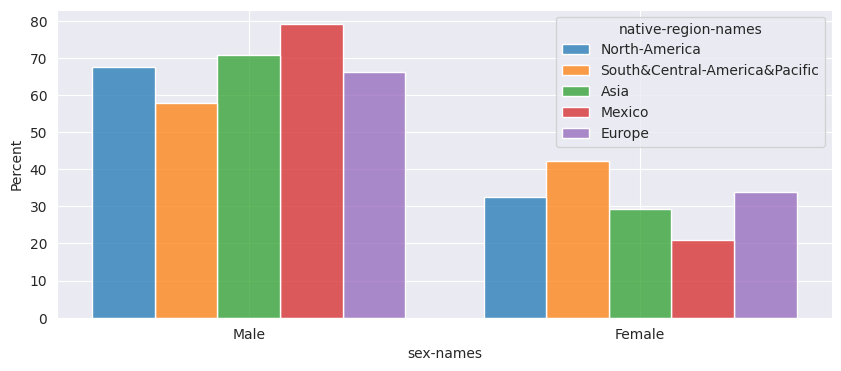

In [39]:
%%capture --no-stdout --no-display
fig, ax = plt.subplots(figsize=(10.0, 4.0))
_ = sns.histplot(
    data_df,
    x="sex-names",
    hue="native-region-names",
    multiple="dodge",
    shrink=0.8,
    stat="percent",
    common_norm=False,
    legend=True,
    ax=ax,
)


In [40]:
sex_node = bayes_net_factory.new_node("sex", replace=True)  # if running this cell multiple times
sex_node.set_parents(native_country_node)
sex_node.one_hot_event_space(len(Adult.variables["sex"]))

for i, region_value in enumerate(native_regions):
    region_mask = native_region_mask[region_value]
    country_matches = torch.all(dataset.data[:, col_idx["native-country"]] <= region_mask[1], dim=-1)
    sex_values = dataset.data[country_matches, :][:, col_idx["sex"]]
    sex_node.set_conditional_probability(
        {native_country_node: region_mask},
        make_categorical(sex_values)
    )


### Race
Next, we model `race` depending on `sex` and `native-country` (grouped by region).
Although making `race` dependent on `sex` seems non-sensical, 
we observe differences in the distribution of `race` dependent on `sex`.
These differences may be related to the mechanism that leads to the overall
imbalance in `sex` in the dataset.


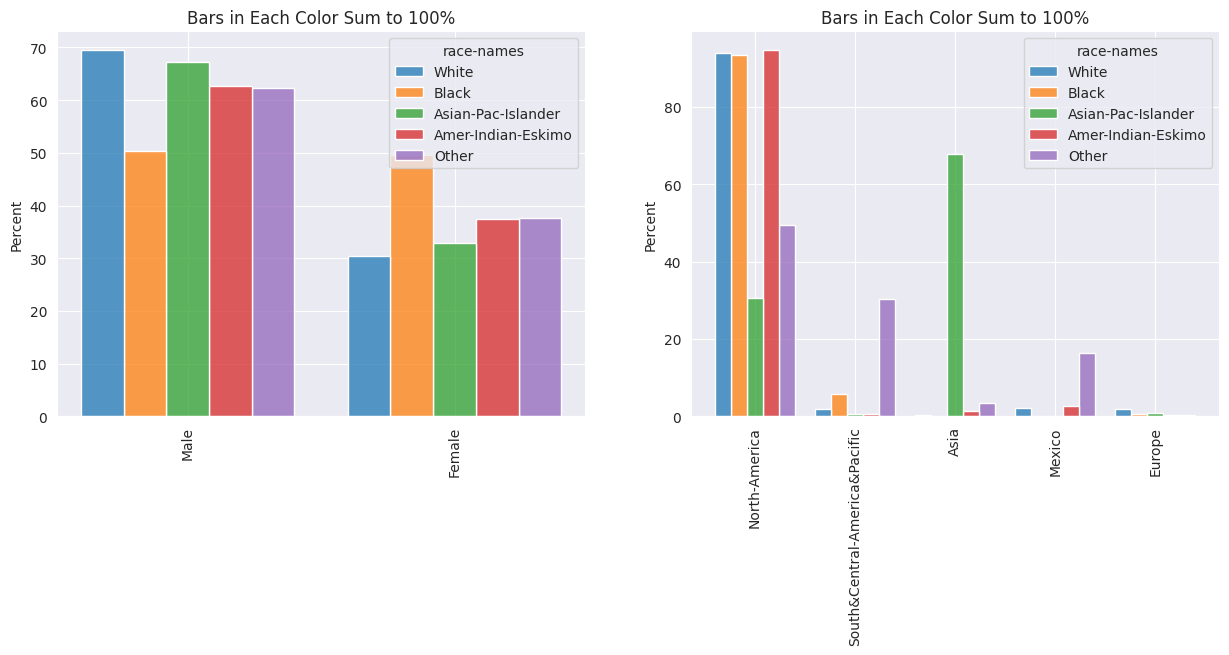

In [41]:
%%capture --no-stdout --no-display
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

for i, var in enumerate(("sex-names", "native-region-names")):
    g = sns.histplot(
        data_df,
        x=var,
        hue="race-names",
        discrete=True,
        shrink=0.8,
        multiple="dodge",
        stat="percent",
        common_norm=False,
        ax=axes[i],
    )
    g.set(xlabel=None)
    g.set(title="Bars in Each Color Sum to 100%")
    axes[i].tick_params(axis='x', labelrotation=90, labelbottom=True)


In [42]:
race_node = bayes_net_factory.new_node("race", replace=True)
race_node.set_parents(sex_node, native_country_node)
race_node.one_hot_event_space(len(Adult.variables["race"]))

for i, _ in enumerate(Adult.variables["sex"]):
    for j, region_value in enumerate(native_regions):
        sex_matches = dataset.data[:, col_idx["sex"][i]] == 1.0
        region_mask = native_region_mask[region_value]
        country_matches = torch.all(dataset.data[:, col_idx["native-country"]] <= region_mask[1], dim=-1)
        race_values = dataset.data[sex_matches & country_matches, :][:, col_idx["race"]]
        race_node.set_conditional_probability(
            {sex_node: torch.eye(2)[i, :], native_country_node: region_mask},
            make_categorical(race_values)
        )


With three variables, some subpopulations that match on all three are as small
as a single individual.
In fact, this already holds true for the combination of `native-country` and `race`.

We now look at the size of these subpopulations and summarize those populations
for which we have little data. 
The following variables then depend on `native-country`, `sex` and `race`
only for these summarized subpopulations.
The goal is that the subpopulations include at least (about) 500 individuals.


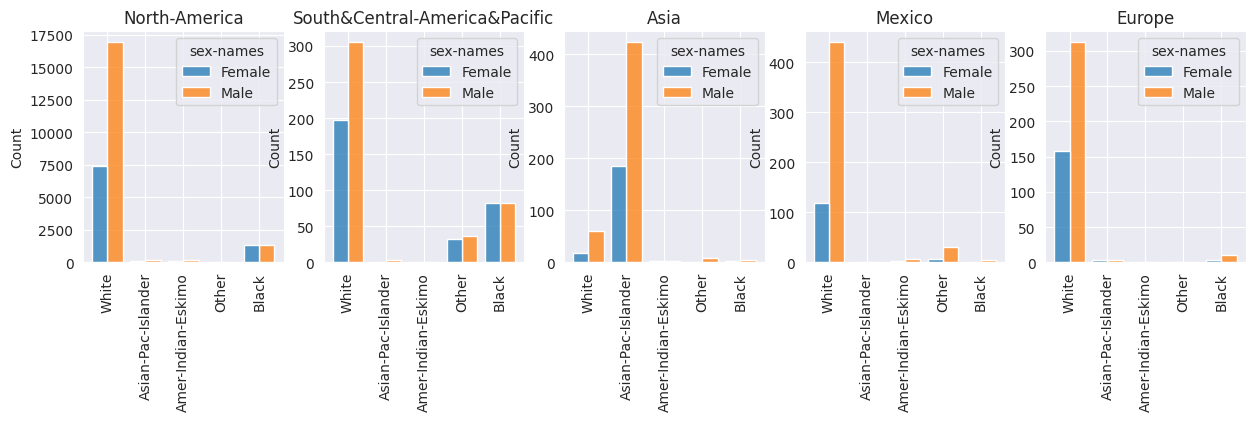

In [43]:
%%capture --no-stdout --no-display
fig, axes = plt.subplots(1, len(native_regions), figsize=(15, 3))

for j, region_value in enumerate(native_regions):
    subset_df = data_df.loc[(data_df["native-region-names"] == region_value)]
    subset_df = subset_df.sort_values(by=["race", "sex"])
    g = sns.histplot(
        subset_df,
        x="race-names",
        hue="sex-names",
        discrete=True,
        shrink=0.8,
        multiple="dodge",
        stat="count",
        ax=axes[j],
    )
    g.set(xlabel=None)
    axes[j].tick_params(axis='x', labelrotation=90, labelbottom=True)

for j, region_value in enumerate(native_regions):
    axes[j].set_title(region_value)


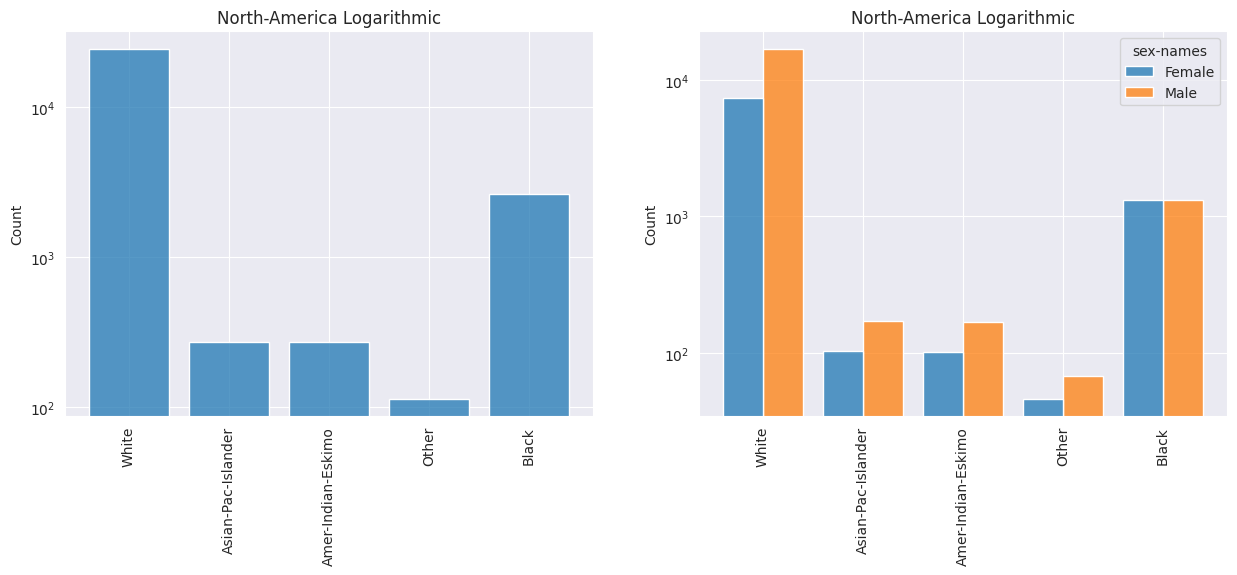

In [44]:
%%capture --no-stdout --no-display
subset_df = data_df.loc[(data_df["native-region-names"] == "North-America")]
subset_df = subset_df.sort_values(by=["race", "sex"])

fig, axes = plt.subplots(1, 2, figsize=(15, 5))

g = sns.histplot(
    subset_df,
    x="race-names",
    stat="count",
    discrete=True,
    shrink=0.8,
    multiple="dodge",
    log_scale=(False, True),
    ax=axes[0],
)
g.set(xlabel=None)
axes[0].tick_params(axis='x', labelrotation=90, labelbottom=True)
_ = axes[0].set_title("North-America Logarithmic")

g = sns.histplot(
    subset_df,
    x="race-names",
    hue="sex-names",
    stat="count",
    discrete=True,
    shrink=0.8,
    multiple="dodge",
    log_scale=(False, True),
    ax=axes[1],
)
g.set(xlabel=None)
axes[1].tick_params(axis='x', labelrotation=90, labelbottom=True)
_ = axes[1].set_title("North-America Logarithmic")


- For every `native-region` except `North-America`, we have too little data
  to differentiate by `race` and `sex`.  
- For North America, we summarize `race=Asian-Pac-Islander`, `race=Amer-Indian-Eskimo`
  and `race=Other` independent of `sex`, as we have too little data for these 
  subpopulations.
  For `race=White` and `race=Black` we have sufficient data to split
  these subpopulations further by `sex`.


In [45]:
native_region_sex_race_mask = {}
native_region_sex_race_values = {}  # for working with data_df

# All regions except North-America
for region_value in ("South&Central-America&Pacific", "Asia", "Mexico", "Europe"):
    native_region_sex_race_mask[region_value] = {
        "native-country": native_region_mask[region_value],
        "sex": (torch.zeros(2), torch.ones(2)),
        "race": (torch.zeros(5), torch.ones(5)),
    }
    native_region_sex_race_values[region_value] = (
        (region_value,),
        Adult.variables["sex"],
        Adult.variables["race"],
    )

# North-America
for race_value, j in (("White", 0), ("Black", -1)):
    for i, sex_value in enumerate(Adult.variables["sex"]):
        key = f"North-America-{sex_value}-{race_value}"
        native_region_sex_race_mask[key] = {
            "native-country": native_region_mask["North-America"],
            "sex": (torch.eye(2)[i, :],) * 2,
            "race": (torch.eye(5)[j, :],) * 2,
        }
        native_region_sex_race_values[key] = (
            ("North-America",), (sex_value,), (race_value,)
        )

native_region_sex_race_mask["North-America-Remaining"] = {
    "native-country": native_region_mask["North-America"],
    "sex": (torch.zeros(2), torch.ones(2)),
    "race": (torch.zeros(5), torch.tensor([0.0, 1.0, 1.0, 1.0, 0.0])),
}
native_region_sex_race_values["North-America-Remaining"] = (
    ("North-America",), 
    Adult.variables["sex"], 
    ("Asian-Pac-Islander", "Amer-Indian-Eskimo", "Other")
)


In [46]:
resolve_to_group = {
    f"{region_value}-{sex_value}-{race_value}": group_key
    for group_key, (region_vals, sex_vals, race_vals) in native_region_sex_race_values.items()
    for region_value in region_vals
    for sex_value in sex_vals
    for race_value in race_vals
}

def get_group(entry):
    native_region_value = entry["native-region-names"]
    sex_value = entry["sex-names"]
    race_value = entry["race-names"]
    return resolve_to_group[
        f"{native_region_value}-{sex_value}-{race_value}"
    ]

data_df["native-region-sex-race-group"] = data_df.apply(get_group, axis=1)
native_region_sex_race_subset_df = {
    group_key: data_df[data_df["native-region-sex-race-group"] == group_key]
    for group_key in native_region_sex_race_mask
}
data_df["native-region-sex-race-group"].value_counts()


native-region-sex-race-group
North-America-Male-White         16920
North-America-Female-White        7403
North-America-Male-Black          1318
North-America-Female-Black        1311
South&Central-America&Pacific      743
Asia                               705
North-America-Remaining            659
Mexico                             610
Europe                             493
Name: count, dtype: int64

### Age
Next, we model `age`.

We first have a look at the conditional probability distribution of `age`
for the `native-region-sex-race` groups we have just created.


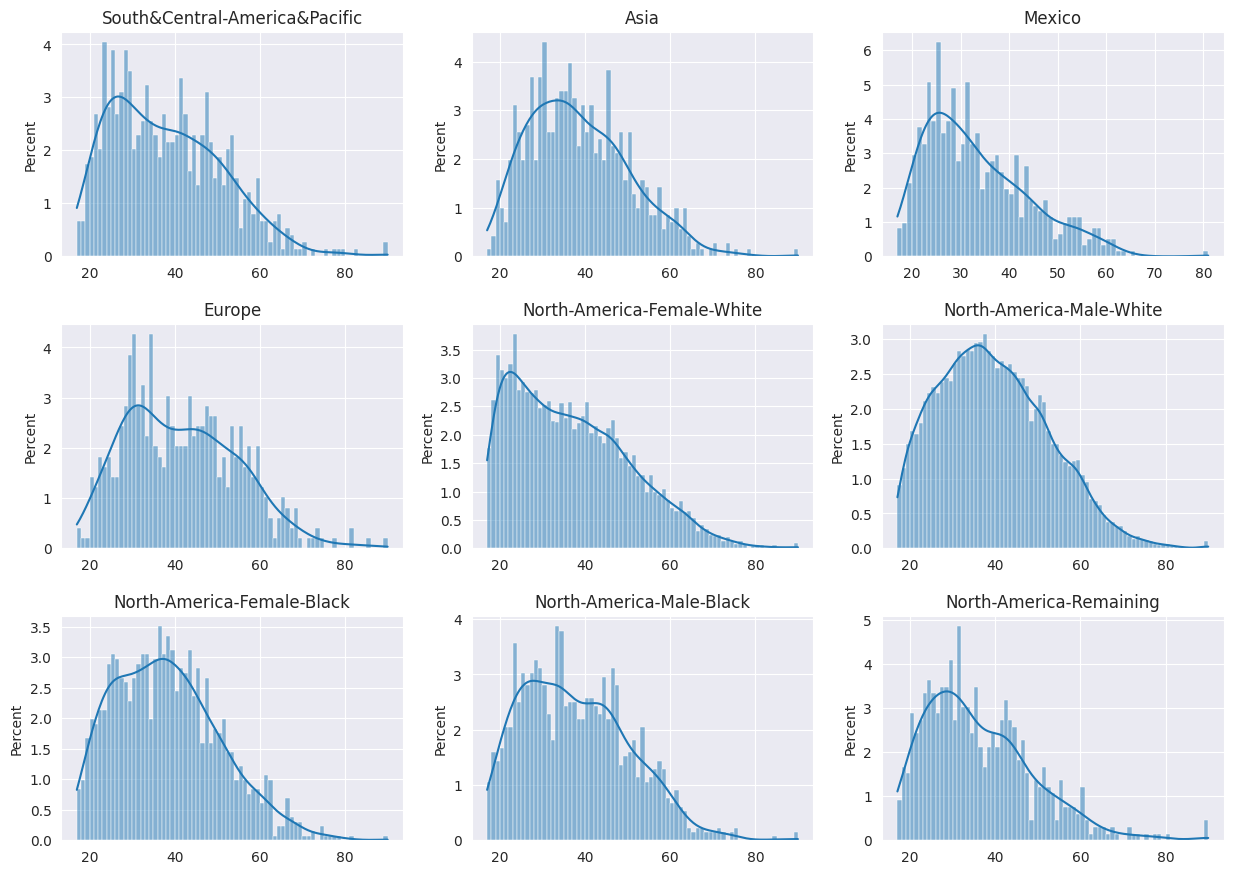

In [47]:
%%capture --no-stdout --no-display
num_groups = len(native_region_sex_race_mask)
num_rows = ceil(num_groups / 3)
fig, axes = plt.subplots(num_rows, 3, figsize=(15, num_rows * 3.5))
axes = axes.flatten()

for i, (group_key, subset_df) in enumerate(native_region_sex_race_subset_df.items()):
    g = sns.histplot(
        subset_df,
        x="age",
        stat="percent",
        kde=True,
        binwidth=1.0,
        ax=axes[i],
    )
    g.set(xlabel=None)
    axes[i].set_title(group_key)

plt.subplots_adjust(hspace=0.3)


We fit Gaussian Mixture Models with varying numbers of components for all `native-region-sex-race`
groups, except `North-America-Male-White`. 
For this group, we use a manually constructed single Gaussian distribution.


In [48]:
num_components = {
    "South&Central-America&Pacific": 4,
    "Asia": 3,
    "Mexico": 3,
    "Europe": 2,
    "North-America-Female-White": 3,
    "North-America-Female-Black": 3,
    "North-America-Male-Black": 3,
    "North-America-Remaining": 2,
}
age_distributions = {
    group_key: make_gaussian_mixture(
        subset_df["age"].to_numpy(),
        var="age",
        n_components=num_components[group_key],
        n_restarts=5,
    )
    for group_key, subset_df in native_region_sex_race_subset_df.items()
    if group_key in num_components
}

age_min, age_max = adult_input_space.attribute_bounds("age")
north_am_male_white_loc = 35.0
north_am_male_white_scale = 16.5
age_distributions["North-America-Male-White"] = AsInteger.wrap(truncnorm(
    a=(age_min - north_am_male_white_loc) / north_am_male_white_scale,
    b=(age_max - north_am_male_white_loc) / north_am_male_white_scale,
    loc=north_am_male_white_loc,
    scale=north_am_male_white_scale,
))


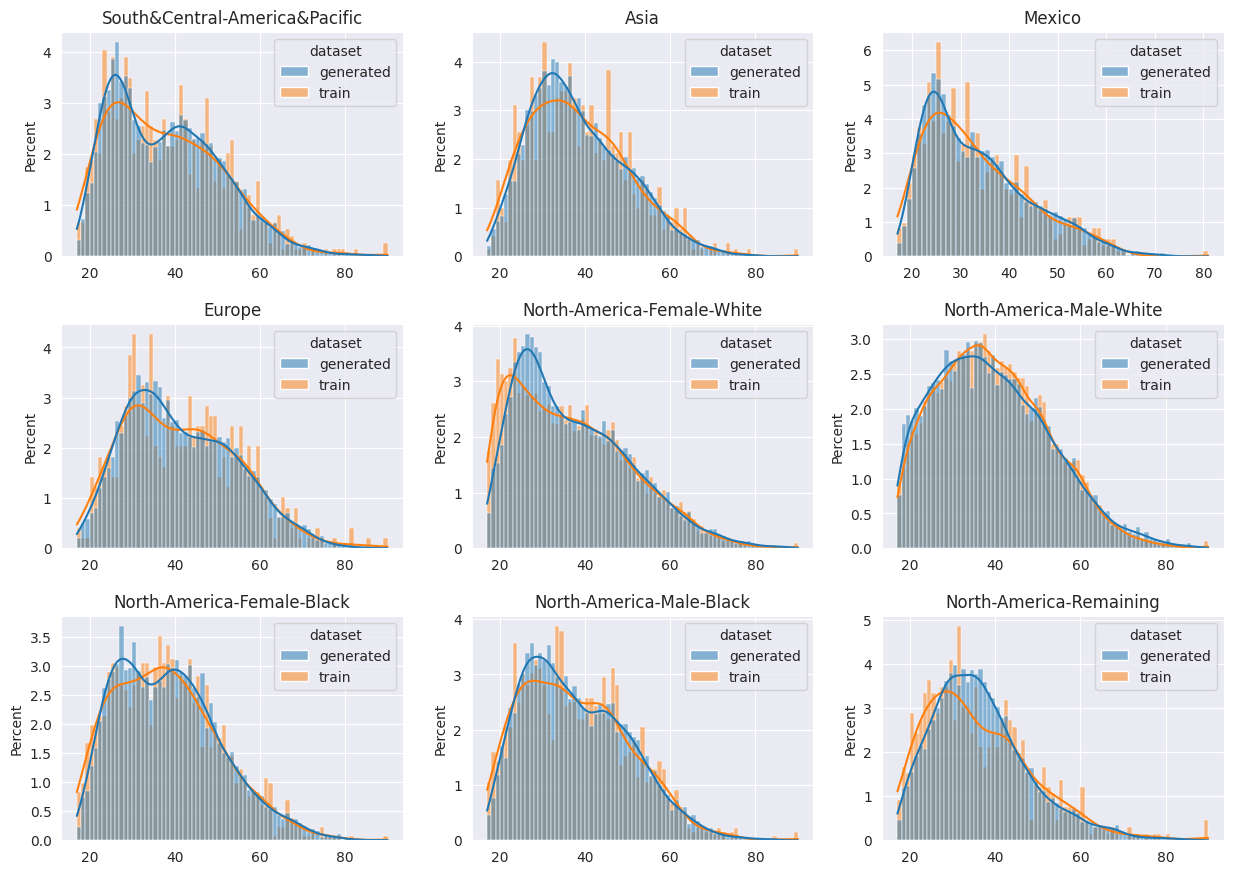

In [49]:
%%capture --no-stdout --no-display
num_groups = len(native_region_sex_race_mask)
num_rows = ceil(num_groups / 3)
fig, axes = plt.subplots(num_rows, 3, figsize=(15, num_rows * 3.5))
axes = axes.flatten()

n = 10000
for i, (group_key, subset_df) in enumerate(native_region_sex_race_subset_df.items()):
    age_data = age_distributions[group_key].sample(n, seed=get_seed(group_key))
    generated_df = pd.DataFrame({"age": age_data, "dataset": "generated"})
    df = pd.concat([generated_df, subset_df])
    g = sns.histplot(
        df,
        x="age",
        hue="dataset",
        stat="percent",
        common_norm=False,
        kde=True,
        binwidth=1.0,
        ax=axes[i],
    )
    g.set(xlabel=None)
    axes[i].set_title(group_key)

plt.subplots_adjust(hspace=0.3)


In [50]:
age_node = bayes_net_factory.new_node("age", replace=True)
age_node.set_parents(native_country_node, sex_node, race_node)
min_age, max_age = adult_input_space.attribute_bounds("age")
age_node.discrete_event_space(*[[age] for age in range(min_age, max_age+1)])

for group_key, group_mask in native_region_sex_race_mask.items():
    age_node.set_conditional_probability(group_mask, age_distributions[group_key])


For making later nodes dependent on age, we introduce age groups.
These age groups are based on https://www.census.gov/library/visualizations/interactive/exploring-age-groups-in-the-2020-census.html


In [51]:
age_group_mask = {
    "17-24": ([17.0], [24.0]),
    "25-34": ([25.0], [34.0]),
    "35-44": ([35.0], [44.0]),
    "45-64": ([45.0], [64.0]),
    "65-90": ([65.0], [90.0]),
}
age_group_lookup = {
    age: group_key
    for group_key, (age_lb, age_ub) in age_group_mask.items()
    for age in range(int(age_lb[0]), int(age_ub[0])+1)
}
data_df["age-group"] = data_df["age"].replace(age_group_lookup)


## fnlwgt
The distribution of `fnlwgt` differs between `native-regions` and `races`,
but does not differ significantly between `sexes`.
This is apparent from the figure below.


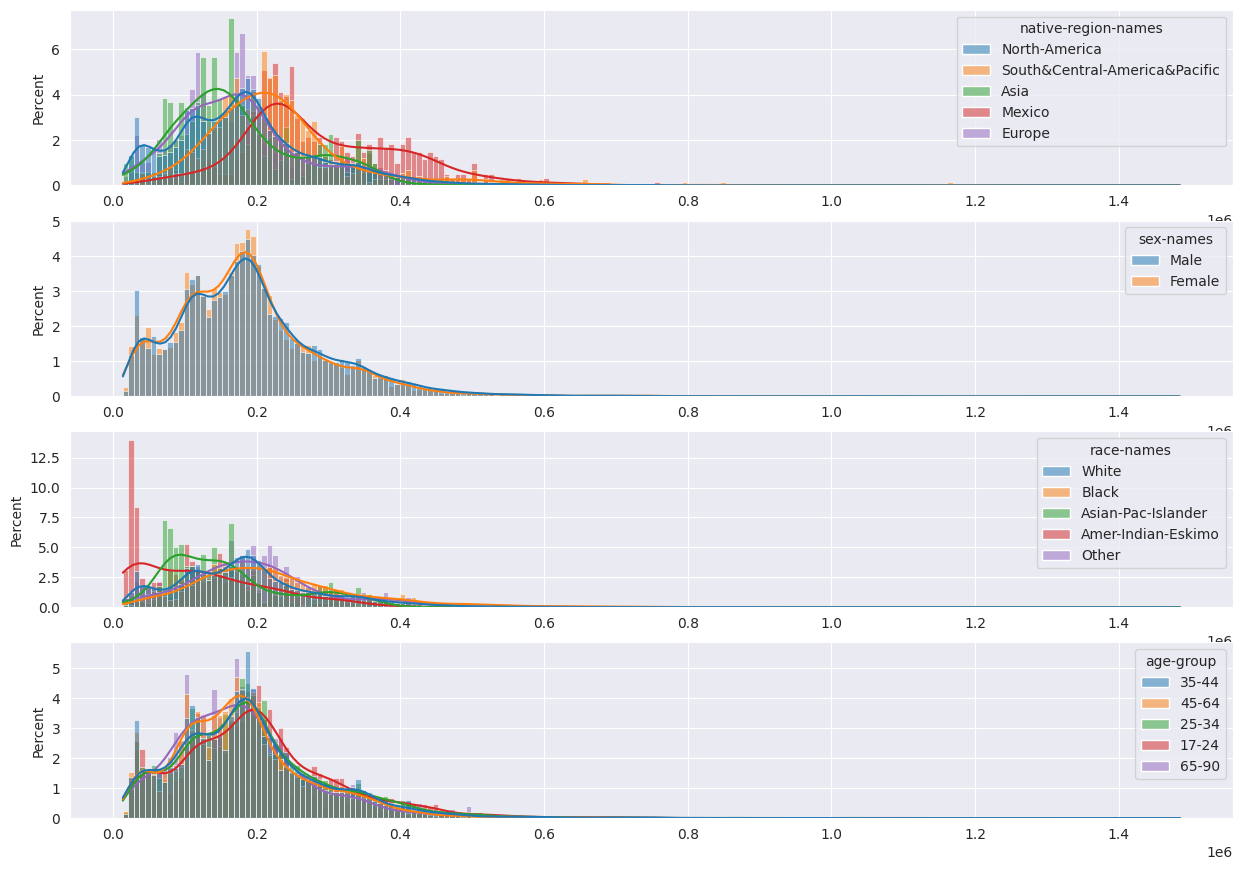

In [52]:
%%capture --no-stdout --no-display 
fig, axes = plt.subplots(4, 1, figsize=(15, 10.5))

for i, var in enumerate(("native-region-names", "sex-names", "race-names", "age-group")):
    g = sns.histplot(
        data_df,
        x="fnlwgt",
        hue=var,
        common_norm=False,
        stat="percent",
        kde=True,
        ax=axes[i],
    )
    g.set(xlabel=None)


Also when looking at `native-region` and `race` subpopulations, the distributions
of `fnlwgt` do not differ much between `sexes`.
Also for `age`, they do not differ much.

Therefore, we model `fnlwgt` dependent on the `native-region-sex-race` groups,
but do not differentiate different values of `sex` or `age`.
In summary, this yields to differentiating the different `native-regions`
and, additionally, differentiating `race=White`, `race=Black` and the remaining `race`
values for `native-region=North-America`. 


In [53]:
native_region_race_mask = {
    key: {var: val[var] for var in ("native-country", "race")}
    for key, val in native_region_sex_race_mask.items()
    if key not in (
        "North-America-Female-White", "North-America-Male-White", 
        "North-America-Female-Black", "North-America-Male-Black"
    )
}
native_region_race_values = {
    key: (val[0], val[2]) 
    for key, val in native_region_sex_race_values.items() 
    if key in native_region_race_mask
}

for race_value, j in (("White", 0), ("Black", -1)):
    key = f"North-America-{race_value}"
    native_region_race_mask[key] = {
        "native-country": native_region_mask["North-America"],
        "race": (torch.eye(5)[j, :],) * 2,
    }
    native_region_race_values[key] = (
        ("North-America",), (race_value,)
    )


In [54]:
native_region_race_subset_df = {
    group_key: subset_df
    for group_key, subset_df in native_region_sex_race_subset_df.items()
    if group_key in native_region_race_mask
}
for race_value in ("Black", "White"):
    native_region_race_subset_df[f"North-America-{race_value}"] = pd.concat(
        [
            native_region_sex_race_subset_df[f"North-America-Female-{race_value}"],
            native_region_sex_race_subset_df[f"North-America-Male-{race_value}"]
        ], axis=0
    )

overview = [
    {"Group": group_key, "Count": len(subset_df)}
    for group_key, subset_df in native_region_race_subset_df.items()
]
overview = pd.DataFrame(overview).sort_values(by=["Count"], ascending=False)
overview


Group  Count
6            North-America-White  24323
5            North-America-Black   2629
0  South&Central-America&Pacific    743
1                           Asia    705
4        North-America-Remaining    659
2                         Mexico    610
3                         Europe    493

Now we can actually build the conditional distributions.
We use mixtures of `beta` and `truncnorm` distributions for all cases.
For some cases, we manually construct `beta` distributions to fit the data.


In [55]:
# Beta distributions produce values between 0.0 and 1.0. 
# We want to move 0.0 to fnlwgt_min and 1.0 to fnlwgt_max
fnlwgt_min, fnlwgt_max = adult_input_space.attribute_bounds("fnlwgt")

fnlwgt_distributions = {}

for group_key in ("Asia", "Mexico", "Europe", "North-America-Remaining", "North-America-Black"):
    subset_df = native_region_race_subset_df[group_key]
    a, b, _, _ = beta.fit(
        subset_df["fnlwgt"].to_numpy(),
        floc=fnlwgt_min,
        fscale=fnlwgt_max,
    )
    fnlwgt_distributions[group_key] = AsInteger.wrap(UnivariateContinuousDistribution(
        beta(a, b, fnlwgt_min, fnlwgt_max),
        bounds=(fnlwgt_min, fnlwgt_max)
    ))

fnlwgt_distributions["South&Central-America&Pacific"] = AsInteger.wrap(UnivariateContinuousDistribution(
    beta(
        a=5.75,
        b=35.0,
        loc=fnlwgt_min,
        scale=fnlwgt_max,
    ),
    bounds=(fnlwgt_min, fnlwgt_max)
))

fnlwgt_distributions["North-America-White"] = AsInteger.wrap(UnivariateContinuousDistribution(
    beta(
        a=4.25,
        b=30.0,
        loc=fnlwgt_min,
        scale=fnlwgt_max,
    ),
    bounds=(fnlwgt_min, fnlwgt_max)
))



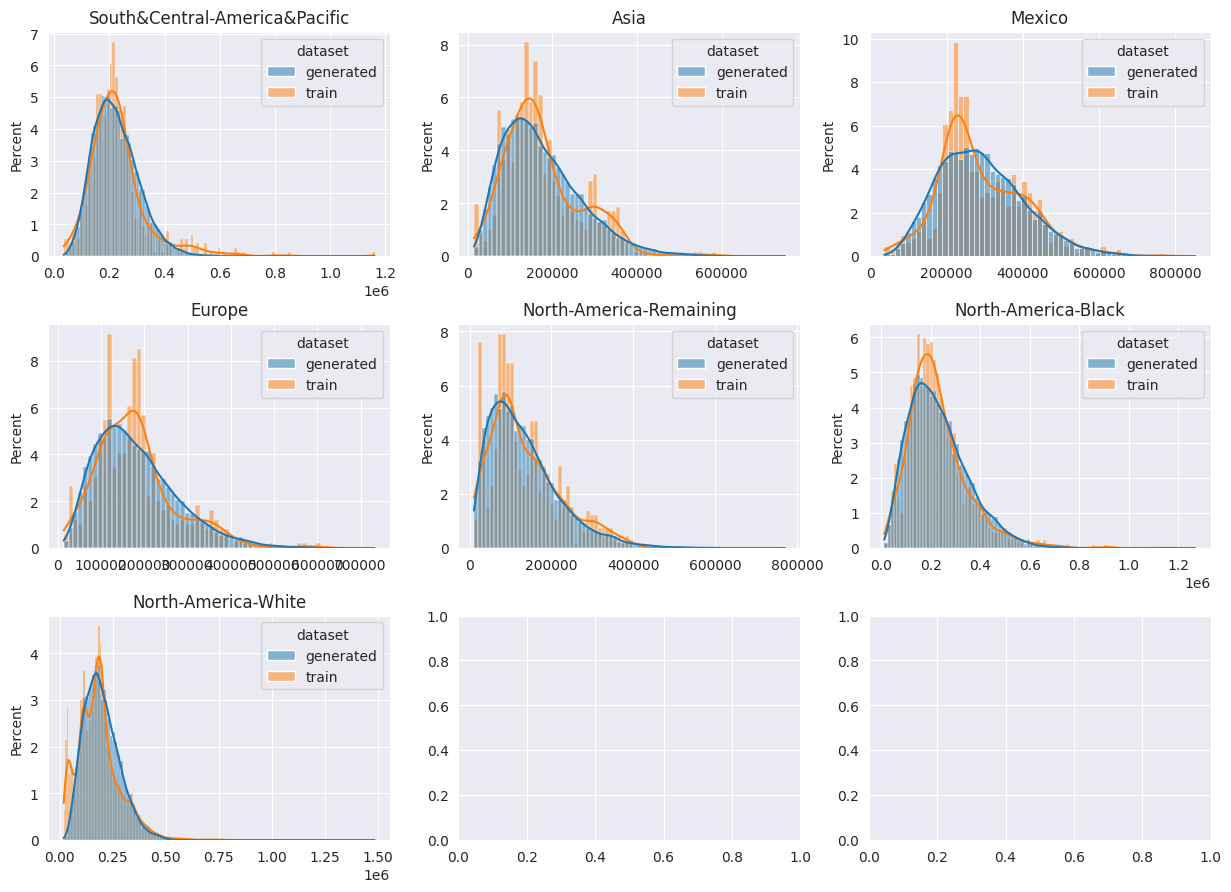

In [56]:
%%capture --no-stdout --no-display
num_groups = len(native_region_race_mask)
num_rows = ceil(num_groups / 3)
fig, axes = plt.subplots(num_rows, 3, figsize=(15, num_rows * 3.5))
axes = axes.flatten()

n = 10000
for i, (group_key, subset_df) in enumerate(native_region_race_subset_df.items()):
    fnlwgt_data = fnlwgt_distributions[group_key].sample(n, seed=get_seed(group_key))
    generated_df = pd.DataFrame({"fnlwgt": fnlwgt_data, "dataset": "generated"})
    df = pd.concat([generated_df, subset_df])
    g = sns.histplot(
        df,
        x="fnlwgt",
        hue="dataset",
        common_norm=False,
        stat="percent",
        kde=True,
        ax=axes[i],
    )
    g.set(xlabel=None)
    axes[i].set_title(group_key)

plt.subplots_adjust(hspace=0.3)


In [57]:
fnlwgt_node = bayes_net_factory.new_node("fnlwgt", replace=True)
fnlwgt_node.set_parents(native_country_node, race_node)
fnlwgt_node.continuous_event_space(*adult_input_space.attribute_bounds("fnlwgt"))

for group_key, group_mask in native_region_race_mask.items():
    fnlwgt_node.set_conditional_probability(group_mask, fnlwgt_distributions[group_key])


#### education
We model `education` depending on the `race` and `age-group`.

Looking at the distribution of `age-group`, there is one significant anomaly: people
in the `age-group` `17-24` have a different distribution in `education`, as they are
still in education.
People in the `age-group` `25-34` also have, for example, fewer `Masters` degrees, but
the differences are less pronounced.


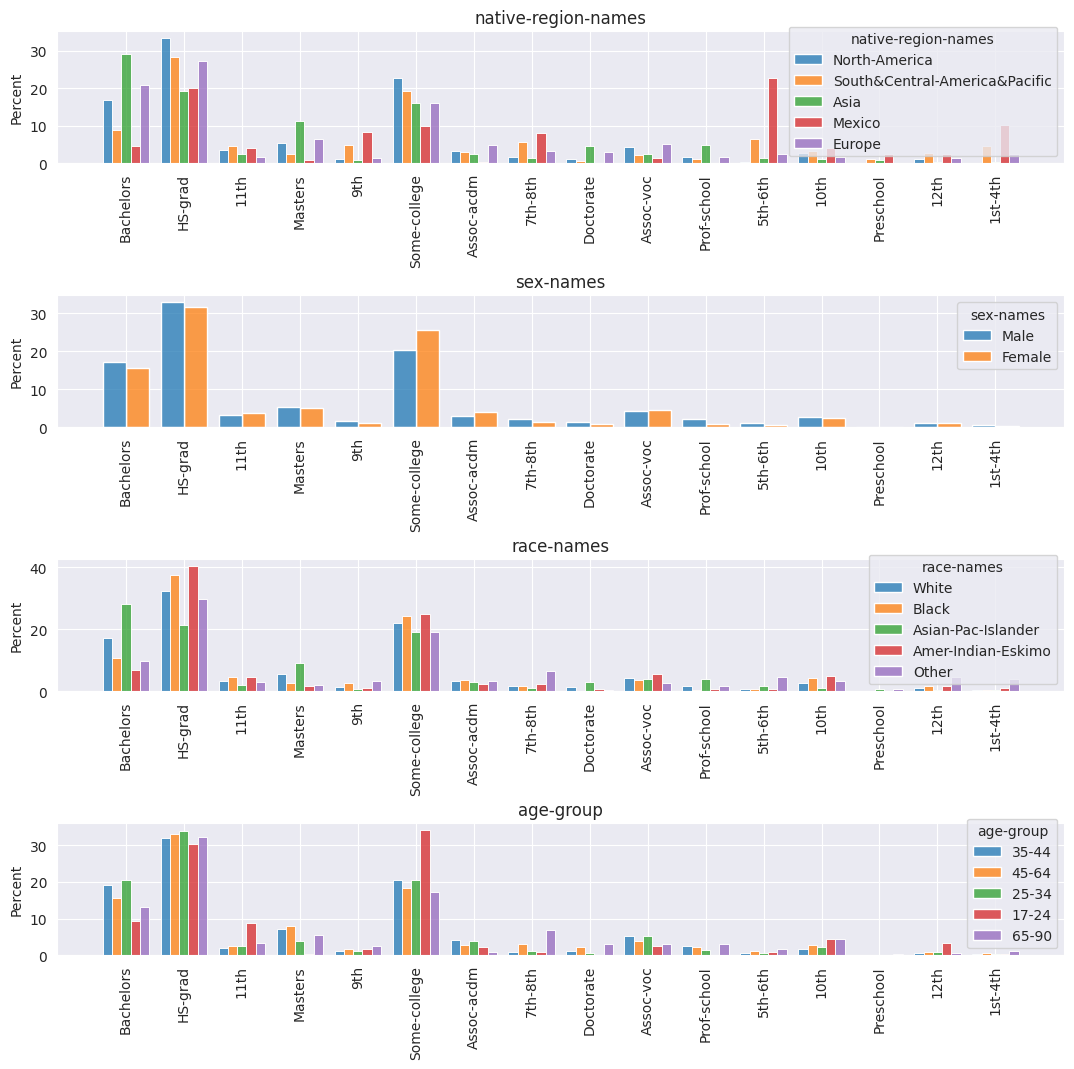

In [58]:
%%capture --no-stdout --no-display
fig, axes = plt.subplots(4, 1, figsize=(13, 12))

for i, var in enumerate(("native-region-names", "sex-names", "race-names", "age-group")):
    g = sns.histplot(
        data_df,
        x="education-names",
        hue=var,
        common_norm=False,
        stat="percent",
        discrete=True,
        shrink=0.8,
        multiple="dodge",
        ax=axes[i],
    )
    axes[i].tick_params(axis='x', labelrotation=90)
    axes[i].set_title(var)
    g.set(xlabel=None)

plt.subplots_adjust(hspace=1.0)


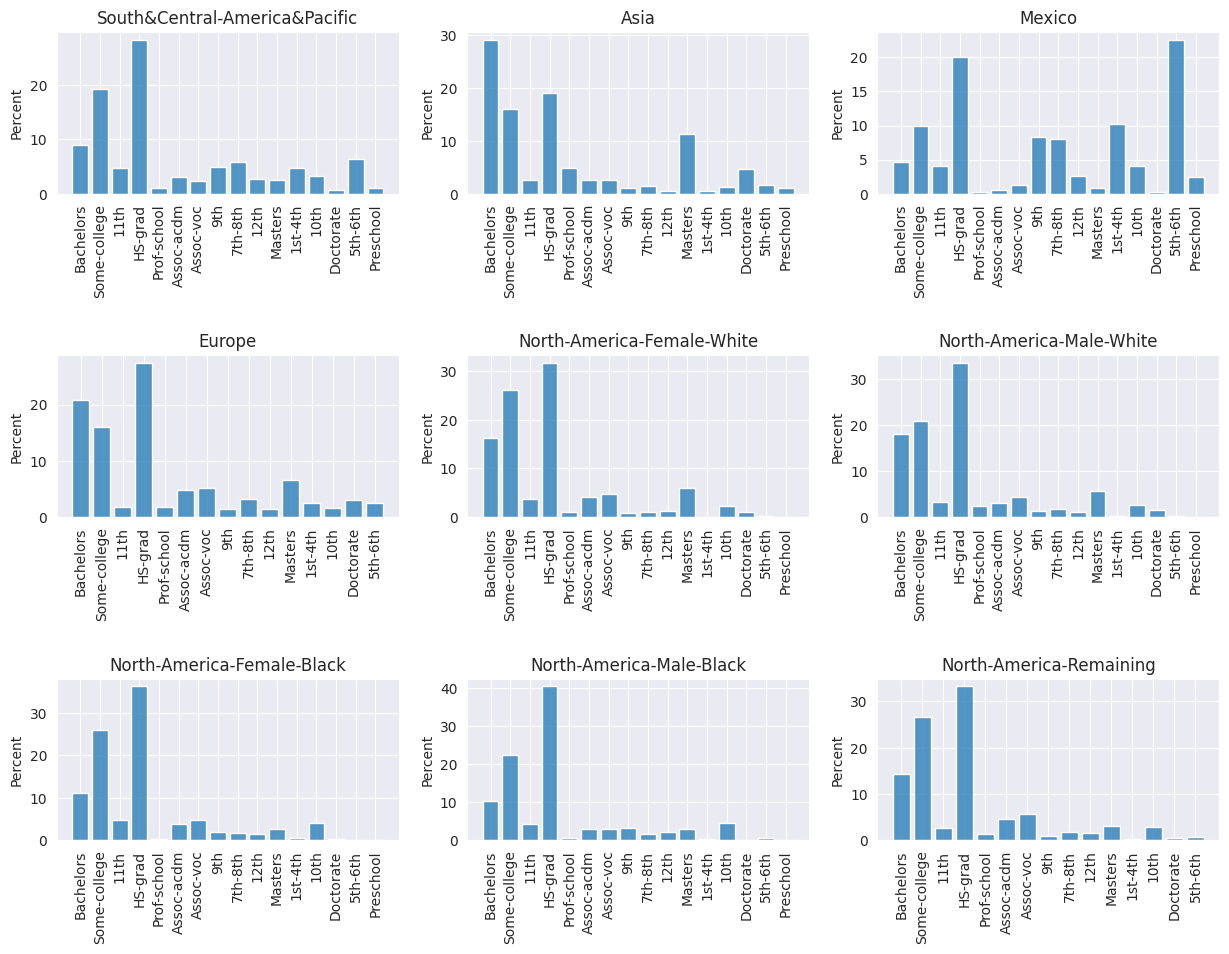

In [59]:
%%capture --no-stdout --no-display
num_groups = len(native_region_sex_race_mask)
num_rows = ceil(num_groups / 3)
fig, axes = plt.subplots(num_rows, 3, figsize=(15, num_rows * 3.5))
axes = axes.flatten()

for i, (group_key, subset_df) in enumerate(native_region_sex_race_subset_df.items()):
    g = sns.histplot(
        subset_df.sort_values(by=["education"]),
        x="education-names",
        stat="percent",
        discrete=True,
        shrink=0.8,
        multiple="dodge",
        ax=axes[i],
    )
    g.set(xlabel=None)
    axes[i].tick_params(axis='x', labelrotation=90)
    axes[i].set_title(group_key)

plt.subplots_adjust(hspace=1.0)


In [60]:
age_broad_mask = {
    "17-24": ([17.0], [24.0]),
    "25-34": ([25.0], [34.0]),
    ">35": ([35.0], [90.0]),
}
age_broad_lookup = {group: group if group in age_broad_mask else ">35" for group in age_group_mask}
data_df["age-broad"] = data_df["age-group"].replace(to_replace=age_broad_lookup)
data_df.value_counts(subset=["age-broad", "race-names"])


age-broad  race-names        
>35        White                 14947
25-34      White                  6767
17-24      White                  4219
>35        Black                  1576
25-34      Black                   812
>35        Asian-Pac-Islander      491
17-24      Black                   429
25-34      Asian-Pac-Islander      272
>35        Amer-Indian-Eskimo      151
17-24      Asian-Pac-Islander      132
25-34      Other                    99
           Amer-Indian-Eskimo       91
>35        Other                    87
17-24      Other                    45
           Amer-Indian-Eskimo       44
Name: count, dtype: int64

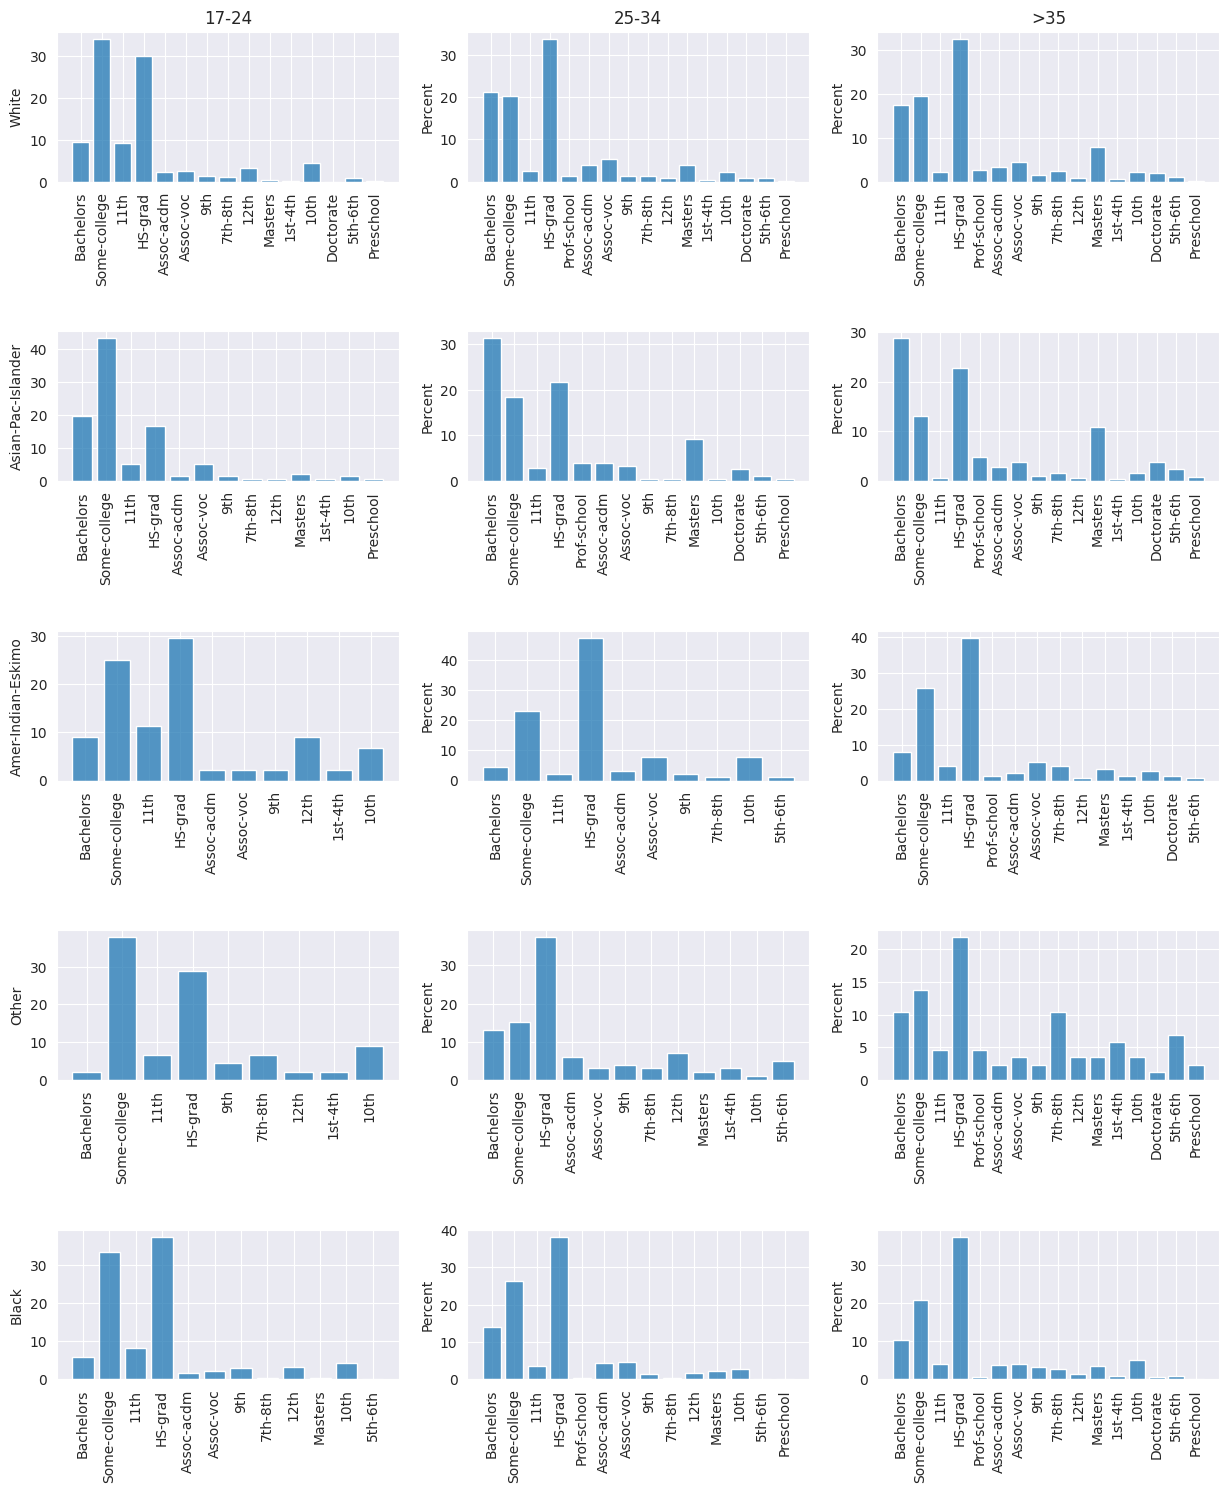

In [61]:
%%capture --no-stdout --no-display
num_rows = len(Adult.variables["race"])
fig, axes = plt.subplots(num_rows, len(age_broad_mask), figsize=(15, num_rows * 3.5))

for i, race_value in enumerate(Adult.variables["race"]):
    for j, age_broad in enumerate(age_broad_mask):
        subset_df = data_df[(data_df["race-names"] == race_value) & (data_df["age-broad"] == age_broad)]
        g = sns.histplot(
            subset_df.sort_values(by=["education"]),
            x="education-names",
            stat="percent",
            discrete=True,
            shrink=0.8,
            multiple="dodge",
            ax=axes[i][j],
        )
        g.set(xlabel=None)
        axes[i][j].tick_params(axis='x', labelrotation=90)

for i, race_value in enumerate(Adult.variables["race"]):
    axes[i][0].set_ylabel(race_value)

for j, age_broad in enumerate(age_broad_mask):
    axes[0][j].set_title(age_broad)

plt.subplots_adjust(hspace=1.0)



We only have sufficient data for `race=White` and `race=Black` groups
to further split by broad age groups (summarize all age groups order than 35).
Therefore, the other values of `race` are not split by `age-broad`.


In [62]:
education_node = bayes_net_factory.new_node("education", replace=True)
education_node.set_parents(race_node, age_node)
education_node.one_hot_event_space(len(Adult.variables["education"]))

for i, race_value in enumerate(Adult.variables["race"]):
    race_matches = data_df["race-names"] == race_value
    if race_value in ("White", "Black"):
        for j, (age_broad, age_mask) in enumerate(age_broad_mask.items()):
            age_broad_matches = data_df["age-broad"] == age_broad
            education_values = dataset.data[race_matches & age_broad_matches, :][:, col_idx["education"]]
            education_node.set_conditional_probability(
                {
                    "race": ([1.0 if k == i else 0.0 for k in range(len(Adult.variables["race"]))],) * 2,
                    "age": age_mask,
                },
                make_categorical(education_values)
            )
    else:
        education_values = dataset.data[race_matches, :][:, col_idx["education"]]
        education_node.set_conditional_probability(
            {
                "race": ([1.0 if k == i else 0.0 for k in range(len(Adult.variables["race"]))],) * 2,
                "age": adult_input_space.attribute_bounds("age"),
            },
            make_categorical(education_values)
        )



For using `education` as a parent for further nodes, we summarize the following values:
- `Preschool`, `1st-4th` - `12th` as `Primary-Secondary`
- `HS-grad` (keep, >9000 instances)
- `Assoc-acdm`, `Assoc-voc`, and `Some-College` as `Associate-Degree`
- `Bachelors`, `Masters`, `Prof-school`, and `Doctorate` as `University-Degree`


In [63]:
data_df["education-group"] = data_df["education-names"]
education_group_values = {
    "Primary-Secondary": ("Preschool", "1st-4th", "5th-6th", "7th-8th", "9th", "10th", "11th", "12th"),
    "HS-grad": ("HS-grad",),
    "Associate-Degree": ("Assoc-acdm", "Assoc-voc", "Some-college"),
    "University-Degree": ("Bachelors", "Masters", "Prof-school", "Doctorate"),
}
education_group_lookup = {
    value: group_key
    for group_key, values in education_group_values.items()
    for value in values
}
education_group_mask = {
    group_key: (
        torch.zeros(len(Adult.variables["education"])),
        torch.tensor(
            [1.0 if val in values else 0.0 for val in Adult.variables["education"]]
        )
    )
    for group_key, values in education_group_values.items()
}
data_df["education-group"].replace(education_group_lookup, inplace=True)
data_df.value_counts(subset=["education-group"])


education-group  
HS-grad              9840
Associate-Degree     8993
University-Degree    7588
Primary-Secondary    3741
Name: count, dtype: int64

#### education-num
As seen in the dataset section at the beginning of this notebook, 
`education-num` is entirely determined by `education`.


In [64]:
edu_num_node = bayes_net_factory.new_node("education-num", replace=True)
edu_num_node.set_parents(education_node)
edu_num_node.continuous_event_space(*adult_input_space.attribute_bounds("education-num"))

edu_num_data = dataset_raw.data[:, col_raw_id["education-num"]]
edu_num_num_values = int(edu_num_data.max() + 1)

for i, education_value in enumerate(Adult.variables["education"]):
    education_matches = dataset.data[:, col_idx["education"][i]] == 1.0
    edu_num_values = edu_num_data[education_matches]
    edu_num_node.set_conditional_probability(
        {education_node: ([1.0 if j == i else 0.0 for j in range(len(Adult.variables["education"]))],) * 2},
        make_categorical_flat(edu_num_values, edu_num_num_values)
    )


#### occupation, workclass, relationship, marital-status, hours-per-week
The variables `occupation`, `workclass`, `relationship`, `marital-status`
and `hours-per-week` represent life choices that can influence each other. 
To model this, we introduce a categorical latent variable that we infer from
clustering using the KModes algorithm.


In [65]:
data_to_cluster = data_df[["occupation-names", "workclass-names", "relationship-names", "marital-status-names", "hours-per-week"]]


Running the clustering for all tested numbers of clusters takes about **three minutes**.
If you skip the next two cells, the third next cell will run clustering only for
the number of clusters we use in the following.


In [66]:
num_clusters = [2, 4, 6, 8, 10, 12, 14, 16, 18, 20]
clustering_cost = []
clusterings = []
for i, n_clusters in enumerate(tqdm(num_clusters)):
    kmodes = KModes(n_clusters, n_init=3, random_state=1234)
    kmodes.fit(data_to_cluster)
    clustering_cost.append(kmodes.cost_)
    clusterings.append(kmodes)


100%|██████████| 10/10 [02:55<00:00, 17.57s/it]


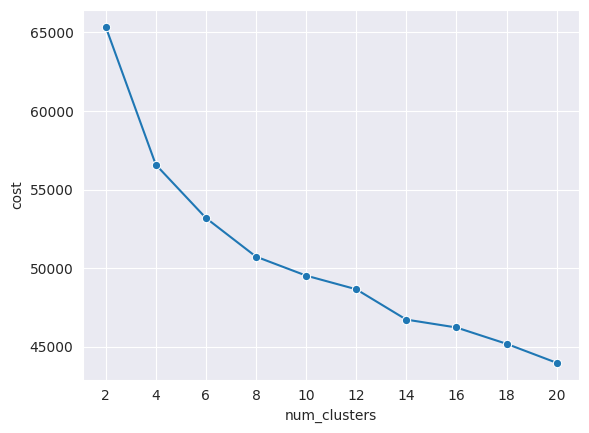

In [67]:
%%capture --no-stdout --no-display
clustering_cost_df = pd.DataFrame({"num_clusters": num_clusters, "cost": clustering_cost})
g = sns.lineplot(clustering_cost_df, x="num_clusters", y="cost", marker="o")
_ = g.set_xticks(num_clusters)


From inspecting the above plot, we pick `n_clusters=8`.


In [68]:
try:
    owrmh_clustering = clusterings[3]
except NameError:
    # Clustering not run (takes about three minutes)
    kmodes = KModes(n_clusters=8, n_init=3, random_state=1234)
    kmodes.fit(data_to_cluster)
    owrmh_clustering = kmodes 

cluster_centroids = owrmh_clustering.cluster_centroids_
cluster_assignment = owrmh_clustering.predict(data_to_cluster)
# OWRMH => occupation, workclass, relationship, marital-status, hours-per-week
data_df["OWRMH-cluster"] = cluster_assignment

_, cluster_sizes = np.unique(cluster_assignment, return_counts=True)
df = pd.DataFrame(cluster_centroids)
df["size"] = cluster_sizes
df


0                 1              2                   3     4  \
0   Prof-specialty           Private        Husband  Married-civ-spouse  40.0   
1     Craft-repair           Private  Not-in-family       Never-married  40.0   
2    Other-service           Private      Own-child       Never-married  40.0   
3     Adm-clerical           Private  Not-in-family            Divorced  40.0   
4     Adm-clerical           Private           Wife  Married-civ-spouse  40.0   
5  Farming-fishing  Self-emp-not-inc        Husband  Married-civ-spouse  50.0   
6     Craft-repair           Private      Unmarried           Separated  40.0   
7     Craft-repair           Private        Husband  Married-civ-spouse  45.0   

    size  
0  10834  
1   6800  
2   4560  
3   3337  
4   1108  
5   1410  
6    774  
7   1339

We now investigate the distributions of `occupation`, `workclass`, `relationship`, 
`marital-status`, and `hours-per-week` across clusters.


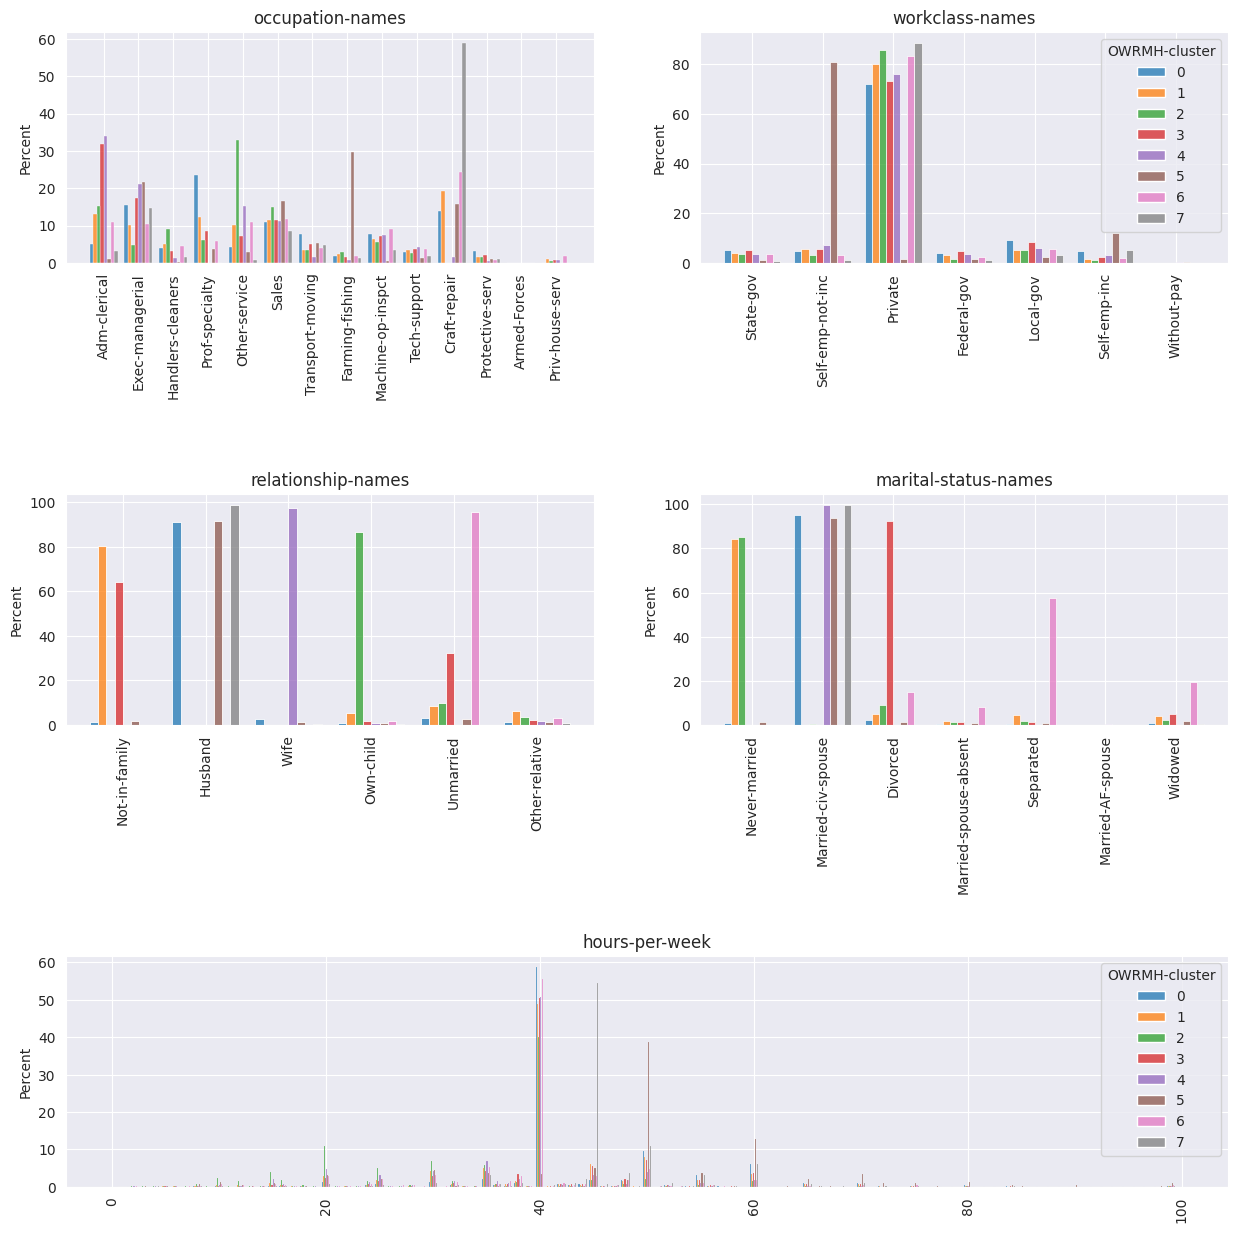

In [69]:
%%capture --no-stdout --no-display
fig, axes = plt.subplot_mosaic(
    [["o", "w"], ["r", "m"], ["h", "h"]], 
    figsize=(15, 15)
)
vars = ("occupation-names", "workclass-names", "relationship-names", "marital-status-names", "hours-per-week")
for var in vars:
    ax = axes[var[0]]
    ax.set_title(var)
    g = sns.histplot(
        data_df,
        x=var,
        hue="OWRMH-cluster",
        common_norm=False,
        discrete=True,
        shrink=0.8,
        multiple="dodge",
        stat="percent",
        palette=sns.color_palette(),
        legend=var in ("workclass-names", "hours-per-week"),
        ax=ax,
    )
    g.set(xlabel=None)
    ax.tick_params(axis='x', labelrotation=90)

plt.subplots_adjust(hspace=1.0)


We now consider how cluster membership depends on `native-region`, `sex`, `race`, 
`age-group` and `education-group`.


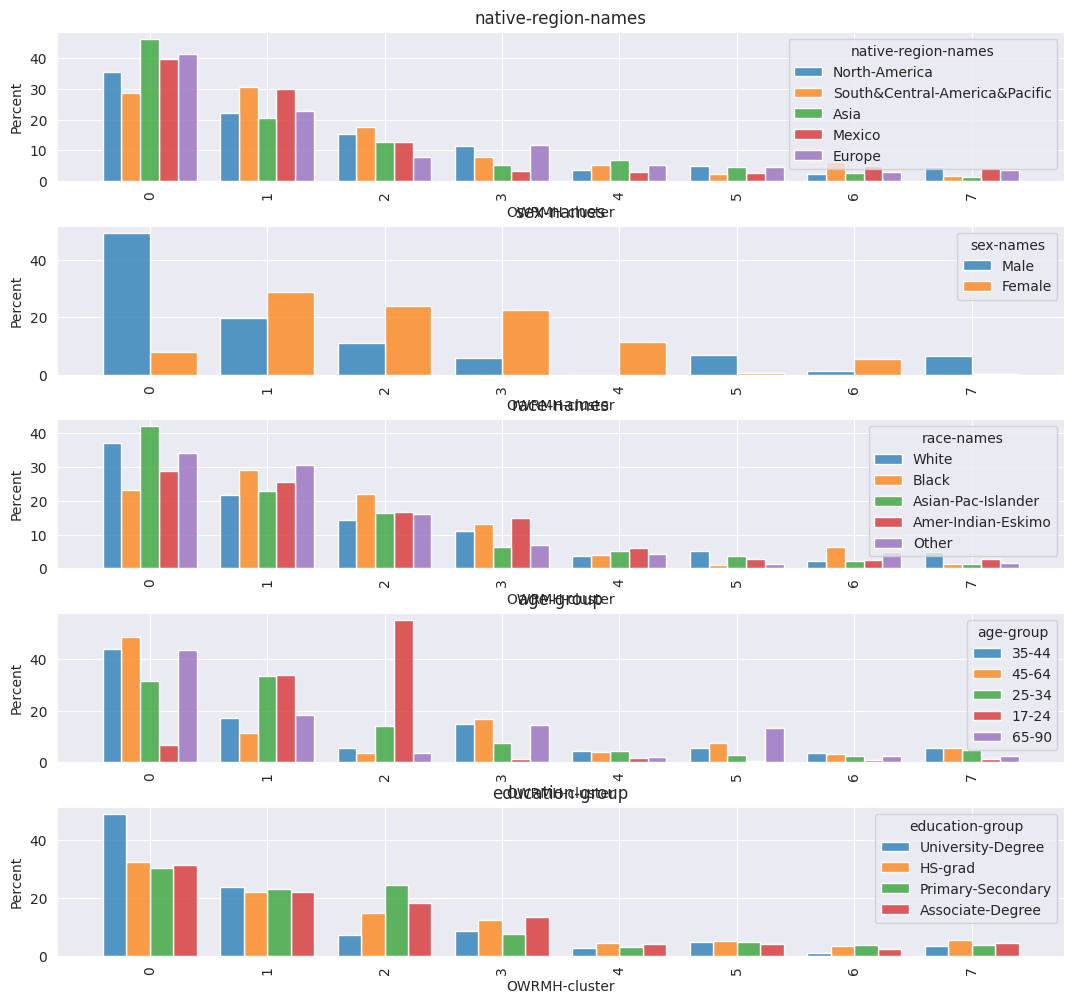

In [70]:
%%capture --no-stdout --no-display
fig, axes = plt.subplots(5, 1, figsize=(13, 12))

for i, var in enumerate(("native-region-names", "sex-names", "race-names", "age-group", "education-group")):
    g = sns.histplot(
        data_df,
        x="OWRMH-cluster",
        hue=var,
        common_norm=False,
        stat="percent",
        discrete=True,
        shrink=0.8,
        multiple="dodge",
        ax=axes[i],
    )
    axes[i].tick_params(axis='x', labelrotation=90)
    axes[i].set_title(var)

plt.subplots_adjust(hspace=0.3)


In [71]:
uncertainty_coefficient(source_vars=["sex"], target_var="OWRMH-cluster")
uncertainty_coefficient(source_vars=["race"], target_var="OWRMH-cluster")
uncertainty_coefficient(source_vars=["native-region"], target_var="OWRMH-cluster")
uncertainty_coefficient(source_vars=["age-group"], target_var="OWRMH-cluster")
uncertainty_coefficient(source_vars=["education-group"], target_var="OWRMH-cluster")
print()

uncertainty_coefficient(source_vars=["sex", "race"], target_var="OWRMH-cluster")
uncertainty_coefficient(source_vars=["sex", "native-region"], target_var="OWRMH-cluster")
uncertainty_coefficient(source_vars=["sex", "age-group"], target_var="OWRMH-cluster")
uncertainty_coefficient(source_vars=["sex", "education-group"], target_var="OWRMH-cluster")
uncertainty_coefficient(source_vars=["race", "native-region"], target_var="OWRMH-cluster")
uncertainty_coefficient(source_vars=["race", "age-group"], target_var="OWRMH-cluster")
uncertainty_coefficient(source_vars=["race", "education-group"], target_var="OWRMH-cluster")
uncertainty_coefficient(source_vars=["age-group", "native-region"], target_var="OWRMH-cluster")
uncertainty_coefficient(source_vars=["age-group", "education-group"], target_var="OWRMH-cluster")
print()

uncertainty_coefficient(source_vars=["native-region-sex-race-group"], target_var="OWRMH-cluster")
uncertainty_coefficient(source_vars=["sex", "race", "native-region"], target_var="OWRMH-cluster")
uncertainty_coefficient(source_vars=["native-region-sex-race-group", "age-group", "education-group"], target_var="OWRMH-cluster")
uncertainty_coefficient(source_vars=["sex", "race", "native-region", "age-group", "education-group"], target_var="OWRMH-cluster")



U(OWRMH-cluster|['sex']) = 0.11
U(OWRMH-cluster|['race']) = 0.01
U(OWRMH-cluster|['native-region']) = 0.00
U(OWRMH-cluster|['age-group']) = 0.10
U(OWRMH-cluster|['education-group']) = 0.01

U(OWRMH-cluster|['sex', 'race']) = 0.11
U(OWRMH-cluster|['sex', 'native-region']) = 0.11
U(OWRMH-cluster|['sex', 'age-group']) = 0.21
U(OWRMH-cluster|['sex', 'education-group']) = 0.12
U(OWRMH-cluster|['race', 'native-region']) = 0.01
U(OWRMH-cluster|['race', 'age-group']) = 0.11
U(OWRMH-cluster|['race', 'education-group']) = 0.02
U(OWRMH-cluster|['age-group', 'native-region']) = 0.11
U(OWRMH-cluster|['age-group', 'education-group']) = 0.12

U(OWRMH-cluster|['native-region-sex-race-group']) = 0.10
U(OWRMH-cluster|['sex', 'race', 'native-region']) = 0.12
U(OWRMH-cluster|['native-region-sex-race-group', 'age-group', 'education-group']) = 0.23
U(OWRMH-cluster|['sex', 'race', 'native-region', 'age-group', 'education-group']) = 0.25


The combination of `sex` and `age-group` is most associated with `OWRMH-cluster`.
Further variables only marginally add to this combination.
Therefore, we choose `sex` and `age-group` as the parents of the latent
`OWRMH-cluster` node in our Bayesian network, that we introduce now.


In [72]:
owrmh_cluster_node = bayes_net_factory.new_node("OWRMH-cluster", replace=True)
owrmh_cluster_node.set_parents(sex_node, age_node)
owrmh_cluster_node.discrete_event_space(*[[i] for i in range(owrmh_clustering.n_clusters)])

for i, sex_value in enumerate(Adult.variables["sex"]):
    for age_group, age_mask in age_group_mask.items():
        subset_df = data_df[(data_df["sex-names"] == sex_value) & (data_df["age-group"] == age_group)]
        owrmh_cluster_values = subset_df["OWRMH-cluster"]
        owrmh_cluster_values = torch.as_tensor(owrmh_cluster_values.to_numpy().astype(int))
        owrmh_cluster_node.set_conditional_probability(
            {
                sex_node: ([1.0 if k == i else 0.0 for k in range(len(Adult.variables["sex"]))],) * 2, 
                age_node: age_mask,
            },
            make_categorical_flat(owrmh_cluster_values, owrmh_clustering.n_clusters)
        )


##### occupation
We now come to modelling occupation based on the `OWRMH-cluster`.


In [73]:
uncertainty_coefficient(source_vars=["sex"], target_var="occupation")
uncertainty_coefficient(source_vars=["race"], target_var="occupation")
uncertainty_coefficient(source_vars=["native-region"], target_var="occupation")
uncertainty_coefficient(source_vars=["age-group"], target_var="occupation")
uncertainty_coefficient(source_vars=["education-group"], target_var="occupation")
uncertainty_coefficient(source_vars=["OWRMH-cluster"], target_var="occupation")
print()

uncertainty_coefficient(source_vars=["native-region-sex-race-group"], target_var="occupation")
uncertainty_coefficient(source_vars=["sex", "race", "native-region", "age-group"], target_var="occupation")
print()

uncertainty_coefficient(source_vars=["sex", "OWRMH-cluster"], target_var="occupation")
uncertainty_coefficient(source_vars=["race", "OWRMH-cluster"], target_var="occupation")
uncertainty_coefficient(source_vars=["native-region", "OWRMH-cluster"], target_var="occupation")
uncertainty_coefficient(source_vars=["age-group", "OWRMH-cluster"], target_var="occupation")
uncertainty_coefficient(source_vars=["education-group", "OWRMH-cluster"], target_var="occupation")
print()

uncertainty_coefficient(source_vars=["sex", "race", "native-region", "age-group", "education-group", "OWRMH-cluster"], target_var="occupation")


U(occupation|['sex']) = 0.04
U(occupation|['race']) = 0.01
U(occupation|['native-region']) = 0.01
U(occupation|['age-group']) = 0.02
U(occupation|['education-group']) = 0.09
U(occupation|['OWRMH-cluster']) = 0.09

U(occupation|['native-region-sex-race-group']) = 0.05
U(occupation|['sex', 'race', 'native-region', 'age-group']) = 0.08

U(occupation|['sex', 'OWRMH-cluster']) = 0.13
U(occupation|['race', 'OWRMH-cluster']) = 0.10
U(occupation|['native-region', 'OWRMH-cluster']) = 0.10
U(occupation|['age-group', 'OWRMH-cluster']) = 0.10
U(occupation|['education-group', 'OWRMH-cluster']) = 0.17

U(occupation|['sex', 'race', 'native-region', 'age-group', 'education-group', 'OWRMH-cluster']) = 0.29


For most of the above combinations, we have insufficient data (less than 500 samples per combination).
Only for `sex` x `OWRMH-cluster`, most combinations have sufficient data.


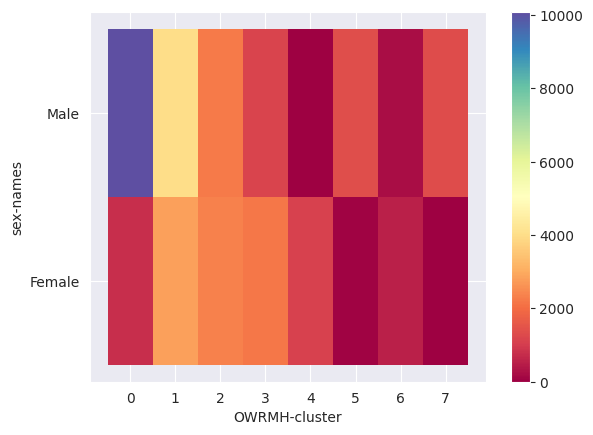

In [74]:
%%capture --no-stdout --no-display
_ = sns.histplot(
    data_df,
    x="OWRMH-cluster",
    y="sex-names",
    stat="count",
    discrete=True,
    cmap=sns.color_palette("Spectral", as_cmap=True),
    cbar=True,
)


In [75]:
data_df.value_counts(subset=["sex-names", "OWRMH-cluster"], ascending=True)


sex-names  OWRMH-cluster
Male       4                    8
Female     7                    9
           5                   46
Male       6                  236
Female     6                  538
           0                  755
           4                 1100
Male       3                 1151
           7                 1330
           5                 1364
Female     3                 2186
Male       2                 2226
Female     2                 2334
           1                 2814
Male       1                 3986
           0                10079
Name: count, dtype: int64

Due to this, we do not differentiate by `sex` for the
`OWRMH-clusters` `4`, `5`, `6`, and `7`.


In [76]:
occupation_node = bayes_net_factory.new_node("occupation", replace=True)
occupation_node.set_parents(sex_node, owrmh_cluster_node)
occupation_node.one_hot_event_space(len(Adult.variables["occupation"]))

for owrmh_cluster in range(owrmh_clustering.n_clusters):
    owrmh_cluster_matches = data_df["OWRMH-cluster"] == owrmh_cluster
    if owrmh_cluster in (4, 5, 6, 7):
        occupation_values = dataset.data[owrmh_cluster_matches, :][:, col_idx["occupation"]]
        occupation_node.set_conditional_probability(
            {
                sex_node: (torch.zeros(2), torch.ones(2)),
                owrmh_cluster_node: ([owrmh_cluster],) * 2,
            },
            make_categorical(occupation_values)
        )
    else:
        for i, sex_value in enumerate(Adult.variables["sex"]):
            matches = (data_df["sex-names"] == sex_value) & owrmh_cluster_matches 
            occupation_values = dataset.data[matches, :][:, col_idx["occupation"]]
            occupation_node.set_conditional_probability(
                {
                    sex_node: ([1.0 if k == i else 0.0 for k in range(len(Adult.variables["sex"]))],) * 2,
                    owrmh_cluster_node:([owrmh_cluster],) * 2,
                },
                make_categorical(occupation_values)
        )


##### workclass


In [77]:
uncertainty_coefficient(source_vars=["sex"], target_var="workclass")
uncertainty_coefficient(source_vars=["race"], target_var="workclass")
uncertainty_coefficient(source_vars=["native-region"], target_var="workclass")
uncertainty_coefficient(source_vars=["age-group"], target_var="workclass")
uncertainty_coefficient(source_vars=["OWRMH-cluster"], target_var="workclass")
uncertainty_coefficient(source_vars=["education-group"], target_var="workclass")
uncertainty_coefficient(source_vars=["occupation"], target_var="workclass")
print()

uncertainty_coefficient(source_vars=["sex", "OWRMH-cluster"], target_var="workclass")
uncertainty_coefficient(source_vars=["race", "OWRMH-cluster"], target_var="workclass")
uncertainty_coefficient(source_vars=["native-region", "OWRMH-cluster"], target_var="workclass")
uncertainty_coefficient(source_vars=["age-group", "OWRMH-cluster"], target_var="workclass")
uncertainty_coefficient(source_vars=["education-group", "OWRMH-cluster"], target_var="workclass")
uncertainty_coefficient(source_vars=["occupation", "OWRMH-cluster"], target_var="workclass")
print()

uncertainty_coefficient(source_vars=["sex", "occupation"], target_var="workclass")
uncertainty_coefficient(source_vars=["race", "occupation"], target_var="workclass")
uncertainty_coefficient(source_vars=["native-region", "occupation"], target_var="workclass")
uncertainty_coefficient(source_vars=["age-group", "occupation"], target_var="workclass")
uncertainty_coefficient(source_vars=["education-group", "occupation"], target_var="workclass")
print()

uncertainty_coefficient(source_vars=["age-group", "occupation", "OWRMH-cluster"], target_var="workclass")
uncertainty_coefficient(source_vars=["sex", "race", "native-region", "age-group", "education-group", "occupation", "OWRMH-cluster"], target_var="workclass")


U(workclass|['sex']) = 0.01
U(workclass|['race']) = 0.01
U(workclass|['native-region']) = 0.00
U(workclass|['age-group']) = 0.03
U(workclass|['OWRMH-cluster']) = 0.11
U(workclass|['education-group']) = 0.02
U(workclass|['occupation']) = 0.12

U(workclass|['sex', 'OWRMH-cluster']) = 0.12
U(workclass|['race', 'OWRMH-cluster']) = 0.12
U(workclass|['native-region', 'OWRMH-cluster']) = 0.12
U(workclass|['age-group', 'OWRMH-cluster']) = 0.13
U(workclass|['education-group', 'OWRMH-cluster']) = 0.13
U(workclass|['occupation', 'OWRMH-cluster']) = 0.22

U(workclass|['sex', 'occupation']) = 0.13
U(workclass|['race', 'occupation']) = 0.13
U(workclass|['native-region', 'occupation']) = 0.13
U(workclass|['age-group', 'occupation']) = 0.15
U(workclass|['education-group', 'occupation']) = 0.13

U(workclass|['age-group', 'occupation', 'OWRMH-cluster']) = 0.25
U(workclass|['sex', 'race', 'native-region', 'age-group', 'education-group', 'occupation', 'OWRMH-cluster']) = 0.42


The combinations of two variables that have a stronger association with `workclass`
than `occupation` alone have many combinations with too little data.
This is in particular because `occupation` has many values.
We model `workclass` to be only dependent on `occupation`.


In [78]:
workclass_node = bayes_net_factory.new_node("workclass", replace=True)
workclass_node.set_parents(occupation_node)
workclass_node.one_hot_event_space(len(Adult.variables["workclass"]))

for i, occupation_value in enumerate(Adult.variables["occupation"]):
    occupation_matches = dataset.data[:, col_idx["occupation"][i]] == 1.0
    workclass_values = dataset.data[occupation_matches][:, col_idx["workclass"]]
    workclass_node.set_conditional_probability(
        {
            occupation_node: ([1.0 if k == i else 0.0 for k in range(len(Adult.variables["occupation"]))],) * 2,
        },
        make_categorical(workclass_values)
    )


##### relationship
We model `relationship` before `marital-status`, as `relationship` is more predictive
for `marital-status` than the other way around.


In [79]:
uncertainty_coefficient(source_vars=["sex"], target_var="relationship")
uncertainty_coefficient(source_vars=["race"], target_var="relationship")
uncertainty_coefficient(source_vars=["native-region"], target_var="relationship")
uncertainty_coefficient(source_vars=["age-group"], target_var="relationship")
uncertainty_coefficient(source_vars=["education-group"], target_var="relationship")
uncertainty_coefficient(source_vars=["OWRMH-cluster"], target_var="relationship")

uncertainty_coefficient(source_vars=["sex", "OWRMH-cluster"], target_var="relationship")
uncertainty_coefficient(source_vars=["sex", "age-group", "OWRMH-cluster"], target_var="relationship")
uncertainty_coefficient(source_vars=["sex", "race", "native-region", "age-group", "education-num", "OWRMH-cluster"], target_var="relationship")


U(relationship|['sex']) = 0.18
U(relationship|['race']) = 0.01
U(relationship|['native-region']) = 0.01
U(relationship|['age-group']) = 0.11
U(relationship|['education-group']) = 0.01
U(relationship|['OWRMH-cluster']) = 0.65
U(relationship|['sex', 'OWRMH-cluster']) = 0.72
U(relationship|['sex', 'age-group', 'OWRMH-cluster']) = 0.74
U(relationship|['sex', 'race', 'native-region', 'age-group', 'education-num', 'OWRMH-cluster']) = 0.80


As for `occupation`, the combination of `sex` and `OWRMH-cluster` is strongly 
associated with `relationship`. Further variables add little to this combination.
We follow the same scheme to model `relationship` as we did for `occupation`.


In [80]:
relationship_node = bayes_net_factory.new_node("relationship", replace=True)
relationship_node.set_parents(sex_node, owrmh_cluster_node)
relationship_node.one_hot_event_space(len(Adult.variables["relationship"]))

for owrmh_cluster in range(owrmh_clustering.n_clusters):
    owrmh_cluster_matches = data_df["OWRMH-cluster"] == owrmh_cluster
    if owrmh_cluster in (4, 5, 6, 7):
        relationship_values = dataset.data[owrmh_cluster_matches, :][:, col_idx["relationship"]]
        relationship_node.set_conditional_probability(
            {
                sex_node: (torch.zeros(2), torch.ones(2)),
                owrmh_cluster_node: ([owrmh_cluster],) * 2,
            },
            make_categorical(relationship_values)
        )
    else:
        for i, sex_value in enumerate(Adult.variables["sex"]):
            matches = (data_df["sex-names"] == sex_value) & owrmh_cluster_matches
            relationship_values = dataset.data[matches, :][:, col_idx["relationship"]]
            relationship_node.set_conditional_probability(
                {
                    sex_node: ([1.0 if k == i else 0.0 for k in range(len(Adult.variables["sex"]))],) * 2,
                    owrmh_cluster_node: ([owrmh_cluster],) * 2,
                },
                make_categorical(relationship_values)
            )


##### marital-status


In [81]:
uncertainty_coefficient(source_vars=["sex"], target_var="marital-status")
uncertainty_coefficient(source_vars=["race"], target_var="marital-status")
uncertainty_coefficient(source_vars=["native-region"], target_var="marital-status")
uncertainty_coefficient(source_vars=["age-group"], target_var="marital-status")
uncertainty_coefficient(source_vars=["education-group"], target_var="marital-status")
uncertainty_coefficient(source_vars=["OWRMH-cluster"], target_var="marital-status")
uncertainty_coefficient(source_vars=["relationship"], target_var="marital-status")
print()

uncertainty_coefficient(source_vars=["sex", "OWRMH-cluster"], target_var="marital-status")
uncertainty_coefficient(source_vars=["race", "OWRMH-cluster"], target_var="marital-status")
uncertainty_coefficient(source_vars=["native-region", "OWRMH-cluster"], target_var="marital-status")
uncertainty_coefficient(source_vars=["age-group", "OWRMH-cluster"], target_var="marital-status")
uncertainty_coefficient(source_vars=["education-group", "OWRMH-cluster"], target_var="marital-status")
uncertainty_coefficient(source_vars=["relationship", "OWRMH-cluster"], target_var="marital-status")
print()

uncertainty_coefficient(source_vars=["sex", "relationship"], target_var="marital-status")
uncertainty_coefficient(source_vars=["race", "relationship"], target_var="marital-status")
uncertainty_coefficient(source_vars=["native-region", "relationship"], target_var="marital-status")
uncertainty_coefficient(source_vars=["age-group", "relationship"], target_var="marital-status")
uncertainty_coefficient(source_vars=["education-group", "relationship"], target_var="marital-status")
print()

uncertainty_coefficient(source_vars=["sex", "relationship", "OWRMH-cluster"], target_var="marital-status")
uncertainty_coefficient(source_vars=["age-group", "relationship", "OWRMH-cluster"], target_var="marital-status")
print()

uncertainty_coefficient(source_vars=["sex", "race", "native-region", "age-group", "education-group", "OWRMH-cluster", "relationship"], target_var="marital-status")


U(marital-status|['sex']) = 0.09
U(marital-status|['race']) = 0.01
U(marital-status|['native-region']) = 0.01
U(marital-status|['age-group']) = 0.16
U(marital-status|['education-group']) = 0.01
U(marital-status|['OWRMH-cluster']) = 0.67
U(marital-status|['relationship']) = 0.57

U(marital-status|['sex', 'OWRMH-cluster']) = 0.70
U(marital-status|['race', 'OWRMH-cluster']) = 0.67
U(marital-status|['native-region', 'OWRMH-cluster']) = 0.67
U(marital-status|['age-group', 'OWRMH-cluster']) = 0.72
U(marital-status|['education-group', 'OWRMH-cluster']) = 0.68
U(marital-status|['relationship', 'OWRMH-cluster']) = 0.75

U(marital-status|['sex', 'relationship']) = 0.58
U(marital-status|['race', 'relationship']) = 0.58
U(marital-status|['native-region', 'relationship']) = 0.58
U(marital-status|['age-group', 'relationship']) = 0.65
U(marital-status|['education-group', 'relationship']) = 0.58

U(marital-status|['sex', 'relationship', 'OWRMH-cluster']) = 0.76
U(marital-status|['age-group', 'relation

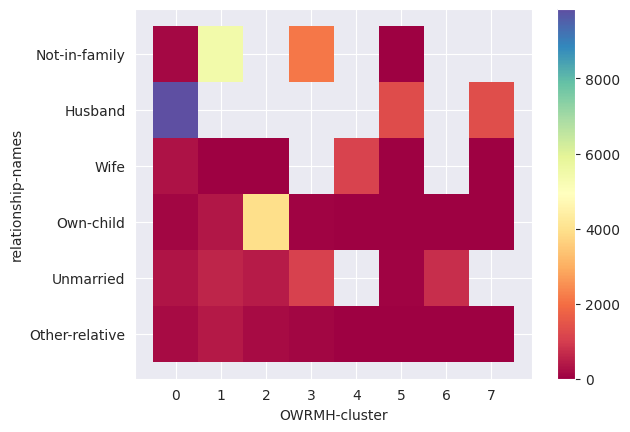

In [82]:
%%capture --no-stdout --no-display
_ = sns.histplot(
    data_df, 
    x="OWRMH-cluster", 
    y="relationship-names",
    stat="count",
    discrete=True, 
    cmap=sns.color_palette("Spectral", as_cmap=True),
    cbar=True, 
)


Combining `relationship` and `OWRMH-cluster` is highly predictive 
for `marital-status`.
However, most combinations also have too little data.

Instead, we model `marital-status` using the combination of `sex`
and `OWRMH-cluster` that we also use for `occuation` and `relationship`.


In [83]:
marital_status_node = bayes_net_factory.new_node("marital-status", replace=True)
marital_status_node.set_parents(sex_node, owrmh_cluster_node)
marital_status_node.one_hot_event_space(len(Adult.variables["marital-status"]))

for owrmh_cluster in range(owrmh_clustering.n_clusters):
    owrmh_cluster_matches = data_df["OWRMH-cluster"] == owrmh_cluster
    if owrmh_cluster in (4, 5, 6, 7):
        marital_status_values = dataset.data[owrmh_cluster_matches, :][:, col_idx["marital-status"]]
        marital_status_node.set_conditional_probability(
            {
                sex_node: (torch.zeros(2), torch.ones(2)),
                owrmh_cluster_node: ([owrmh_cluster],) * 2,
            },
            make_categorical(marital_status_values)
        )
    else:
        for i, sex_value in enumerate(Adult.variables["sex"]):
            matches = (data_df["sex-names"] == sex_value) & owrmh_cluster_matches
            marital_status_values = dataset.data[matches, :][:, col_idx["marital-status"]]
            marital_status_node.set_conditional_probability(
                {
                    sex_node: ([1.0 if k == i else 0.0 for k in range(len(Adult.variables["sex"]))],) * 2,
                    owrmh_cluster_node: ([owrmh_cluster],) * 2,
                },
                make_categorical(marital_status_values)
            )


##### hours-per-week


In [84]:
uncertainty_coefficient(source_vars=["sex"], target_var="hours-per-week")
uncertainty_coefficient(source_vars=["race"], target_var="hours-per-week")
uncertainty_coefficient(source_vars=["native-region"], target_var="hours-per-week")
uncertainty_coefficient(source_vars=["age-group"], target_var="hours-per-week")
uncertainty_coefficient(source_vars=["education-group"], target_var="hours-per-week")
uncertainty_coefficient(source_vars=["OWRMH-cluster"], target_var="hours-per-week")
uncertainty_coefficient(source_vars=["occupation"], target_var="hours-per-week")
uncertainty_coefficient(source_vars=["workclass"], target_var="hours-per-week")
print()

uncertainty_coefficient(source_vars=["sex", "OWRMH-cluster"], target_var="hours-per-week")
uncertainty_coefficient(source_vars=["race", "OWRMH-cluster"], target_var="hours-per-week")
uncertainty_coefficient(source_vars=["native-region", "OWRMH-cluster"], target_var="hours-per-week")
uncertainty_coefficient(source_vars=["age-group", "OWRMH-cluster"], target_var="hours-per-week")
uncertainty_coefficient(source_vars=["education-group", "OWRMH-cluster"], target_var="hours-per-week")
uncertainty_coefficient(source_vars=["occupation", "OWRMH-cluster"], target_var="hours-per-week")
uncertainty_coefficient(source_vars=["workclass", "OWRMH-cluster"], target_var="hours-per-week")
print()

uncertainty_coefficient(source_vars=["age-group", "occupation", "OWRMH-cluster"], target_var="hours-per-week")
print()

uncertainty_coefficient(source_vars=["sex", "race", "native-region", "age-group", "education-group", "OWRMH-cluster", "occupation", "workclass"], target_var="hours-per-week")



U(hours-per-week|['sex']) = 0.02
U(hours-per-week|['race']) = 0.01
U(hours-per-week|['native-region']) = 0.00
U(hours-per-week|['age-group']) = 0.03
U(hours-per-week|['education-group']) = 0.01
U(hours-per-week|['OWRMH-cluster']) = 0.08
U(hours-per-week|['occupation']) = 0.05
U(hours-per-week|['workclass']) = 0.02

U(hours-per-week|['sex', 'OWRMH-cluster']) = 0.09
U(hours-per-week|['race', 'OWRMH-cluster']) = 0.09
U(hours-per-week|['native-region', 'OWRMH-cluster']) = 0.09
U(hours-per-week|['age-group', 'OWRMH-cluster']) = 0.11
U(hours-per-week|['education-group', 'OWRMH-cluster']) = 0.10
U(hours-per-week|['occupation', 'OWRMH-cluster']) = 0.15
U(hours-per-week|['workclass', 'OWRMH-cluster']) = 0.10

U(hours-per-week|['age-group', 'occupation', 'OWRMH-cluster']) = 0.22

U(hours-per-week|['sex', 'race', 'native-region', 'age-group', 'education-group', 'OWRMH-cluster', 'occupation', 'workclass']) = 0.51


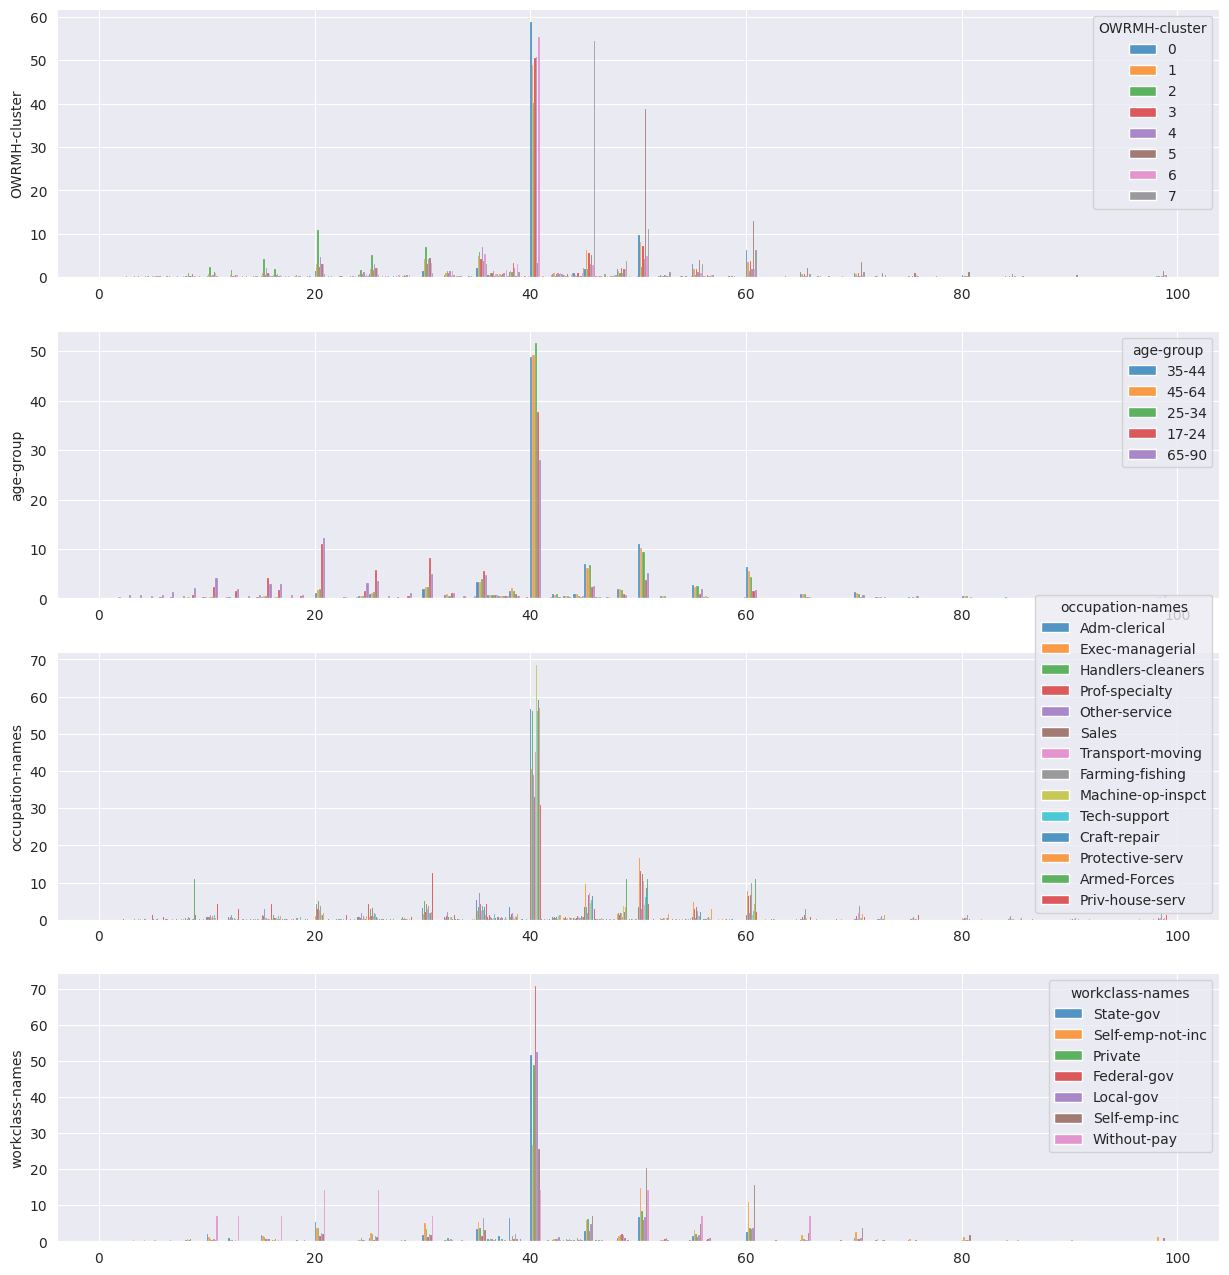

In [85]:
%%capture --no-stdout --no-display
fig, axes = plt.subplots(4, 1, figsize=(15.0, 16.0))
for i, var in enumerate(("OWRMH-cluster", "age-group", "occupation-names", "workclass-names")):
    g = sns.histplot(
        data_df,
        x="hours-per-week",
        hue=var,
        multiple="dodge",
        stat="percent",
        common_norm=False,
        binwidth=1.0,
        legend=True,
        palette=sns.color_palette(),
        ax=axes[i],
    )
    g.set(ylabel=var, xlabel=None)


One interesting observation we can make from the above plot is that people
in the age groups `17-24` and `56-90` work shorter hours per week.
However, `age-group` alone is less predictive than `OWRMH-cluster`
and we have too little data to model the combination of both,
in particular for the interesting `age-groups` `17-24` and `56-90`.

We instead consider a combination of `OWRMH-cluster` and `occupation`.


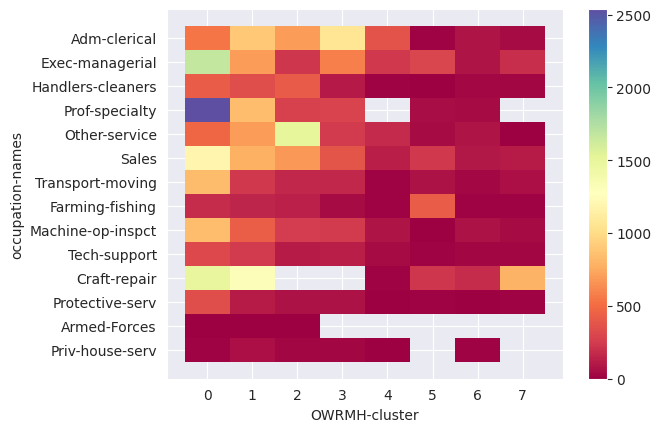

In [86]:
%%capture --no-stdout --no-display
_ = sns.histplot(
    data_df, 
    x="OWRMH-cluster", 
    y="occupation-names",
    stat="count",
    discrete=True, 
    cmap=sns.color_palette("Spectral", as_cmap=True),
    cbar=True, 
)


We model `hours-per-week` using a combination of `occupation`
and `OWRMH-cluster`.
Since we have too little data to faithfully model using entire combination,
we collapse all `occupation` x `OWRMH-cluster` combinations with less
than 500 data points into a single group per `OWRMH-cluster`.


In [87]:
counts = data_df.value_counts(subset=["occupation-names", "OWRMH-cluster"])
occupation_owrmh_cluster_values = defaultdict(list)
num_occupations = len(Adult.variables["occupation"])
for i, occupation_value in enumerate(Adult.variables["occupation"]):
    for owrmh_cluster in range(owrmh_clustering.n_clusters):
        try:
            count = counts[(occupation_value, owrmh_cluster)]
        except KeyError:
            count = 0
        if count < 500:
            occupation_owrmh_cluster_values[f"Remaining-{owrmh_cluster}"].append((occupation_value, owrmh_cluster))
        else:
            key = f"{occupation_value}-{owrmh_cluster}"
            occupation_owrmh_cluster_values[key].append((occupation_value, owrmh_cluster))

occupation_owrmh_cluster_mask = {}
for group_key, values in occupation_owrmh_cluster_values.items():
    occupation_values, owrmh_cluster = zip(*values)
    owrmh_cluster = owrmh_cluster[0]  # cluster values are all equal
    occupation_owrmh_cluster_mask[group_key] = {
        "occupation": (
            torch.zeros(len(Adult.variables["occupation"])),
            torch.tensor(
                [1.0 if val in occupation_values else 0.0 for val in Adult.variables["occupation"]]
            )
        ),
        "OWRMH-cluster": torch.tensor([owrmh_cluster])
    }

occupation_owrmh_cluster_lookup = {
    f"{occupation}-{owrmh_cluster}": group_key
    for group_key, values in occupation_owrmh_cluster_values.items()
    for occupation, owrmh_cluster in values
}
data_df["occupation-OWRMH-cluster-group"] = data_df["occupation-names"] + "-" + data_df["OWRMH-cluster"].astype(str)
data_df["occupation-OWRMH-cluster-group"].replace(occupation_owrmh_cluster_lookup, inplace=True)
data_df.value_counts(subset=["occupation-OWRMH-cluster-group"], ascending=True)


occupation-OWRMH-cluster-group
Adm-clerical-0                     539
Remaining-7                        550
Exec-managerial-3                  578
Sales-2                            681
Other-service-1                    695
Adm-clerical-2                     699
Exec-managerial-1                  699
Remaining-6                        774
Sales-1                            775
Craft-repair-7                     789
Transport-moving-0                 830
Machine-op-inspct-0                836
Prof-specialty-1                   841
Adm-clerical-1                     897
Adm-clerical-3                    1066
Remaining-4                       1108
Sales-0                           1180
Craft-repair-1                    1317
Remaining-5                       1410
Craft-repair-0                    1495
Other-service-2                   1502
Remaining-1                       1576
Exec-managerial-0                 1673
Remaining-2                       1678
Remaining-3                      

In [88]:
uncertainty_coefficient(source_vars=["occupation", "OWRMH-cluster"], target_var="hours-per-week")
uncertainty_coefficient(source_vars=["occupation-OWRMH-cluster-group"], target_var="hours-per-week")


U(hours-per-week|['occupation', 'OWRMH-cluster']) = 0.15
U(hours-per-week|['occupation-OWRMH-cluster-group']) = 0.13


In [89]:
hours_per_week_node = bayes_net_factory.new_node("hours-per-week", replace=True)
hours_per_week_node.set_parents(occupation_node, owrmh_cluster_node)
min_hours_per_week, max_hours_per_week = adult_input_space.attribute_bounds("hours-per-week")
hours_per_week_node.discrete_event_space(*[[hours] for hours in range(min_hours_per_week, max_hours_per_week+1)])

for group_key, group_mask in occupation_owrmh_cluster_mask.items():
    subset_df = data_df[data_df["occupation-OWRMH-cluster-group"] == group_key]
    hours_per_week_values = subset_df["hours-per-week"]
    hours_per_week_values = torch.as_tensor(hours_per_week_values.to_numpy())
    hours_per_week_node.set_conditional_probability(
        group_mask, make_categorical_flat(hours_per_week_values, 100)
    )


#### capital-change
In difference to the independent population model, we here model `capital-change`
instead of `capital-loss` and `capital-gain` independently.
Since these two variables are disjoint (the one is zero if the other is non-zero),
it is simple to separate `capital-change` into the two using two `ReLUs` 
in an input transformation. 


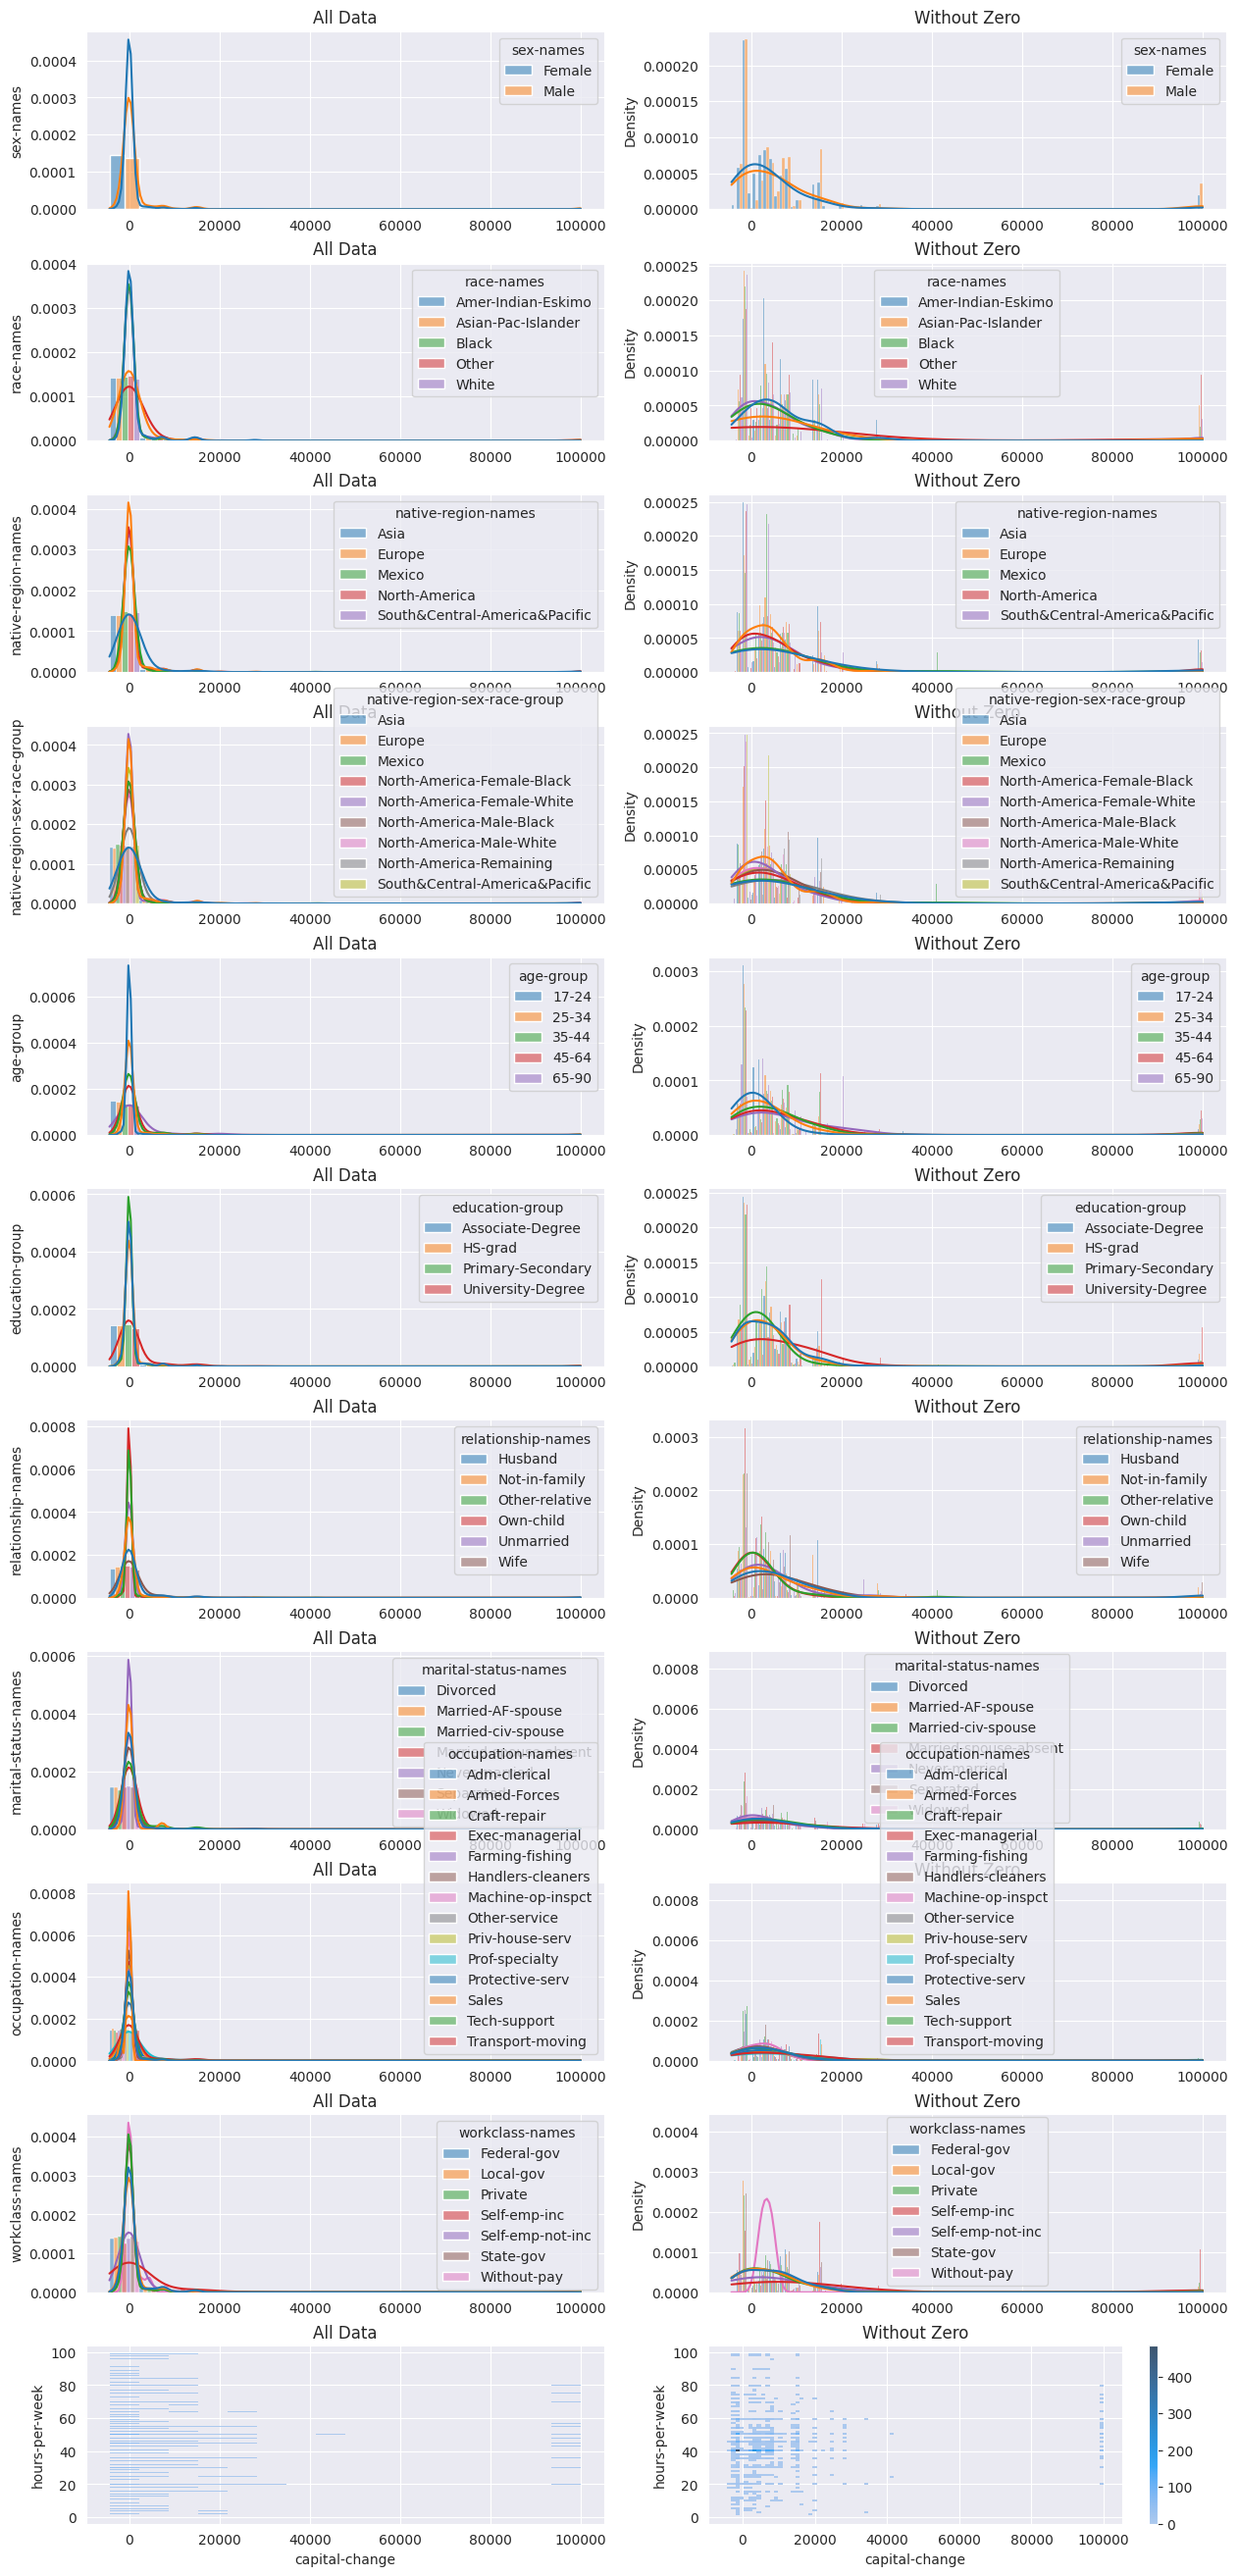

In [90]:
%%capture --no-stdout --no-display
fig, axes = plt.subplots(11, 2, figsize=(15, 33))
vars = (
    "sex-names", "race-names", "native-region-names", "native-region-sex-race-group", 
    "age-group", "education-group", "relationship-names", 
    "marital-status-names", "occupation-names", "workclass-names"
)
for var, ax in zip(vars, axes):
    for exclude_zero in (True, False):
        df = data_df
        if exclude_zero:
            df = df[df["capital-change"] != 0]
        g = sns.histplot(
            df.sort_values(by=[var]),
            x="capital-change",
            hue=var,
            common_norm=False,
            stat="density",
            multiple="dodge",
            kde=True,
            palette=sns.color_palette(),
            ax=ax[int(exclude_zero)],
        )
        if not exclude_zero:
            g.set(ylabel=var, title="All Data")
        else:
            g.set(title="Without Zero")
        g.set(xlabel=None)

for exclude_zero in (True, False):
    df = data_df
    if exclude_zero:
        df = df[df["capital-change"] != 0]
    g = sns.histplot(
        df,
        x="capital-change",
        y="hours-per-week",
        cbar=exclude_zero,
        ax=axes[-1][int(exclude_zero)],
    )
    if not exclude_zero:
        g.set(ylabel="hours-per-week", title="All Data")
    else:
        g.set(title="Without Zero")

plt.subplots_adjust(hspace=0.3)


The figure above shows that `capital-change` varies for many variables.
The differences for `sex` might be explained by the differences in
`relationship` for `sex`.
The differences for `race` might be explained by the differences in
`education-group` for `race`. 


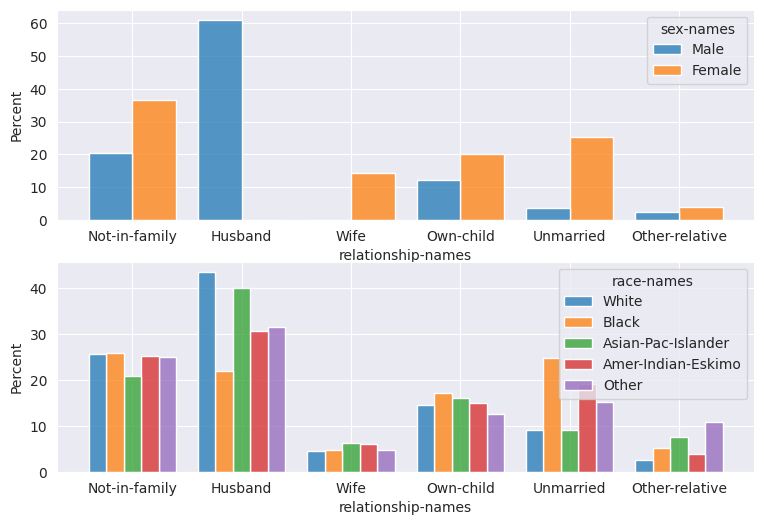

In [91]:
%%capture --no-stdout --no-display
fig, axes = plt.subplots(2, 1, figsize=(9, 6))
for var, ax in zip(("sex-names", "race-names"), axes):
    g = sns.histplot(
        data_df,
        x="relationship-names",
        hue=var,
        common_norm=False,
        stat="percent",
        shrink=.8,
        multiple="dodge",
        ax=ax,
    )


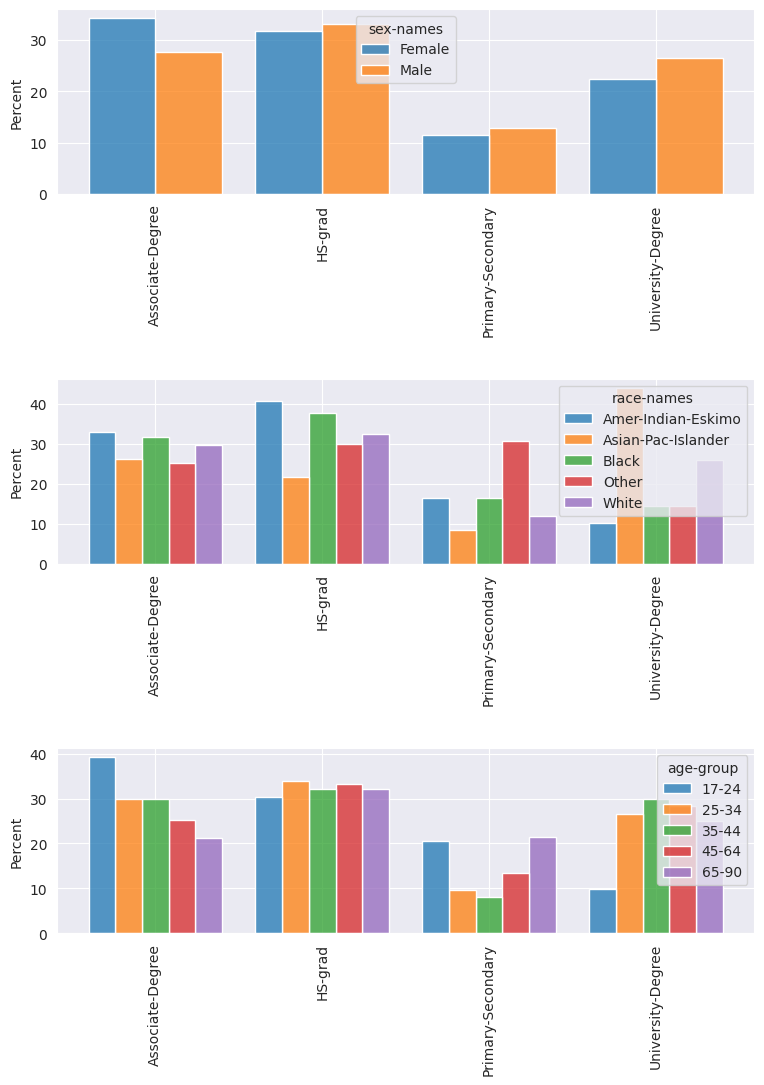

In [92]:
%%capture --no-stdout --no-display
fig, axes = plt.subplots(3, 1, figsize=(9, 12))
for var, ax in zip(("sex-names", "race-names", "age-group"), axes):
    g = sns.histplot(
        data_df.sort_values(by=["education-group", var]),
        x="education-group",
        hue=var,
        common_norm=False,
        stat="percent",
        shrink=.8,
        multiple="dodge",
        ax=ax,
    )
    g.set(xlabel=None)
    ax.tick_params(axis='x', labelrotation=90)

plt.subplots_adjust(hspace=1.0)


We model `capital-change` using `relationship` and `education`.
Since most combinations of `relationship` and `education` have too
little data, we summarize values that have similar distributions
of `capital-change`.

For `relationship`, these are:
- `Own-child` and `Other-relative` form one group.
- All remaining values form the other group.

For `education`, we use the groups created before.


In [93]:
data_df["relationship-group"] = data_df["relationship-names"]
relationship_group_values = {
    "Own-child-Other-relative": ("Own-child", "Other-relative"),
    "Remaining": ("Husband", "Wife", "Not-in-family", "Unmarried"),
}
relationship_group_mask = {
    group_key: (
        torch.zeros(len(Adult.variables["relationship"])),
        torch.tensor(
            [1.0 if val in values else 0.0 for val in Adult.variables["relationship"]]
        )
    )
    for group_key, values in relationship_group_values.items()
}
relationship_group_lookup = {
    value: group_key
    for group_key, values in relationship_group_values.items()
    for value in values
}
data_df["relationship-group"].replace(relationship_group_lookup, inplace=True)
data_df.value_counts(subset=["relationship-group"])


relationship-group      
Remaining                   24807
Own-child-Other-relative     5355
Name: count, dtype: int64

In [94]:
data_df.value_counts(subset=["relationship-group", "education-group"])


relationship-group        education-group  
Remaining                 HS-grad              8089
                          Associate-Degree     7103
                          University-Degree    6920
                          Primary-Secondary    2695
Own-child-Other-relative  Associate-Degree     1890
                          HS-grad              1751
                          Primary-Secondary    1046
                          University-Degree     668
Name: count, dtype: int64

For `Own-child-Other-relative`, we further summarize `University-Degree` 
and `Associate-Degree`.

In [95]:
data_df["relationship-education-group"] = data_df["relationship-group"] + "-" + data_df["education-group"]
data_df["relationship-education-group"].replace(
    {
        f"Own-child-Other-relative-{edu_val}": "Own-child-Other-relative-Higher-Degree" 
        for edu_val in ("University-Degree", "Associate-Degree")
    },
    inplace=True,
)
counts = data_df.value_counts(subset="relationship-education-group")

relationship_education_group_mask = {}
for group_key in counts.index:
    masks = {}
    relationship_education_group_mask[group_key] = masks  # dicts are objects
    if group_key.startswith("Remaining"):
        group_key = group_key[len("Remaining-"):]
        masks["relationship"] = relationship_group_mask["Remaining"]
    else:
        group_key = group_key[len("Own-child-Other-relative-"):]
        masks["relationship"] = relationship_group_mask["Own-child-Other-relative"]
    if group_key == "Higher-Degree":
        masks["education"] = (
            torch.zeros(len(Adult.variables["education"])),
            education_group_mask["Associate-Degree"][1] + education_group_mask["University-Degree"][1]
        )
    else:
        masks["education"] = education_group_mask[group_key]
counts


relationship-education-group
Remaining-HS-grad                             8089
Remaining-Associate-Degree                    7103
Remaining-University-Degree                   6920
Remaining-Primary-Secondary                   2695
Own-child-Other-relative-Higher-Degree        2558
Own-child-Other-relative-HS-grad              1751
Own-child-Other-relative-Primary-Secondary    1046
Name: count, dtype: int64

Similarly as for the independent population model, we fit a mixture of a 
categorical distribution for outliers and a Gaussian Mixture 
for the remaining data to `capital-change`.


In [96]:
capital_change_data = data_df["capital-change"]
outliers = [0.0, capital_change_data.max()]
is_outlier = capital_change_data.isin(outliers)
capital_change_min = -adult_input_space.attribute_bounds("capital-loss")[1]
capital_change_max = adult_input_space.attribute_bounds("capital-gain")[1] 

def make_capital_change_mixture(relationship_education_group, n_components):
    matches_group = data_df["relationship-education-group"] == relationship_education_group
    outlier_data = capital_change_data[is_outlier & matches_group]
    regular_data = capital_change_data[~is_outlier & matches_group]
    outlier_frequency = outlier_data.astype(int).value_counts(normalize=True)
    outliers_distribution = Categorical(
        outlier_frequency.tolist(), outlier_frequency.index.tolist()
    )

    regular_data = regular_data.to_numpy().reshape(-1, 1)
    mixture_model = make_gaussian_mixture(
        regular_data, n_components, n_restarts=3, 
        var_min=capital_change_min, var_max=capital_change_max,
    )
    mixture_model = mixture_model.continuous_distribution

    # add the outlier distribution to the mixture model
    n_group = sum(matches_group)
    components = list(mixture_model.distributions) + [outliers_distribution]
    weights = list(mixture_model.weights * len(regular_data)/n_group)
    weights += [len(outlier_data)/n_group]
    return AsInteger(MixtureModel(weights, components))

num_components = {
    "Remaining-Primary-Secondary": 4,
    "Remaining-HS-grad": 3,
    "Remaining-Associate-Degree": 4,
    "Remaining-University-Degree": 2,
    "Own-child-Other-relative-Primary-Secondary": 2,
    "Own-child-Other-relative-HS-grad": 2,
    "Own-child-Other-relative-Higher-Degree": 2,
}
capital_change_distributions = {
    group_key: make_capital_change_mixture(
        group_key, n_components
    )
    for group_key, n_components in num_components.items()
}


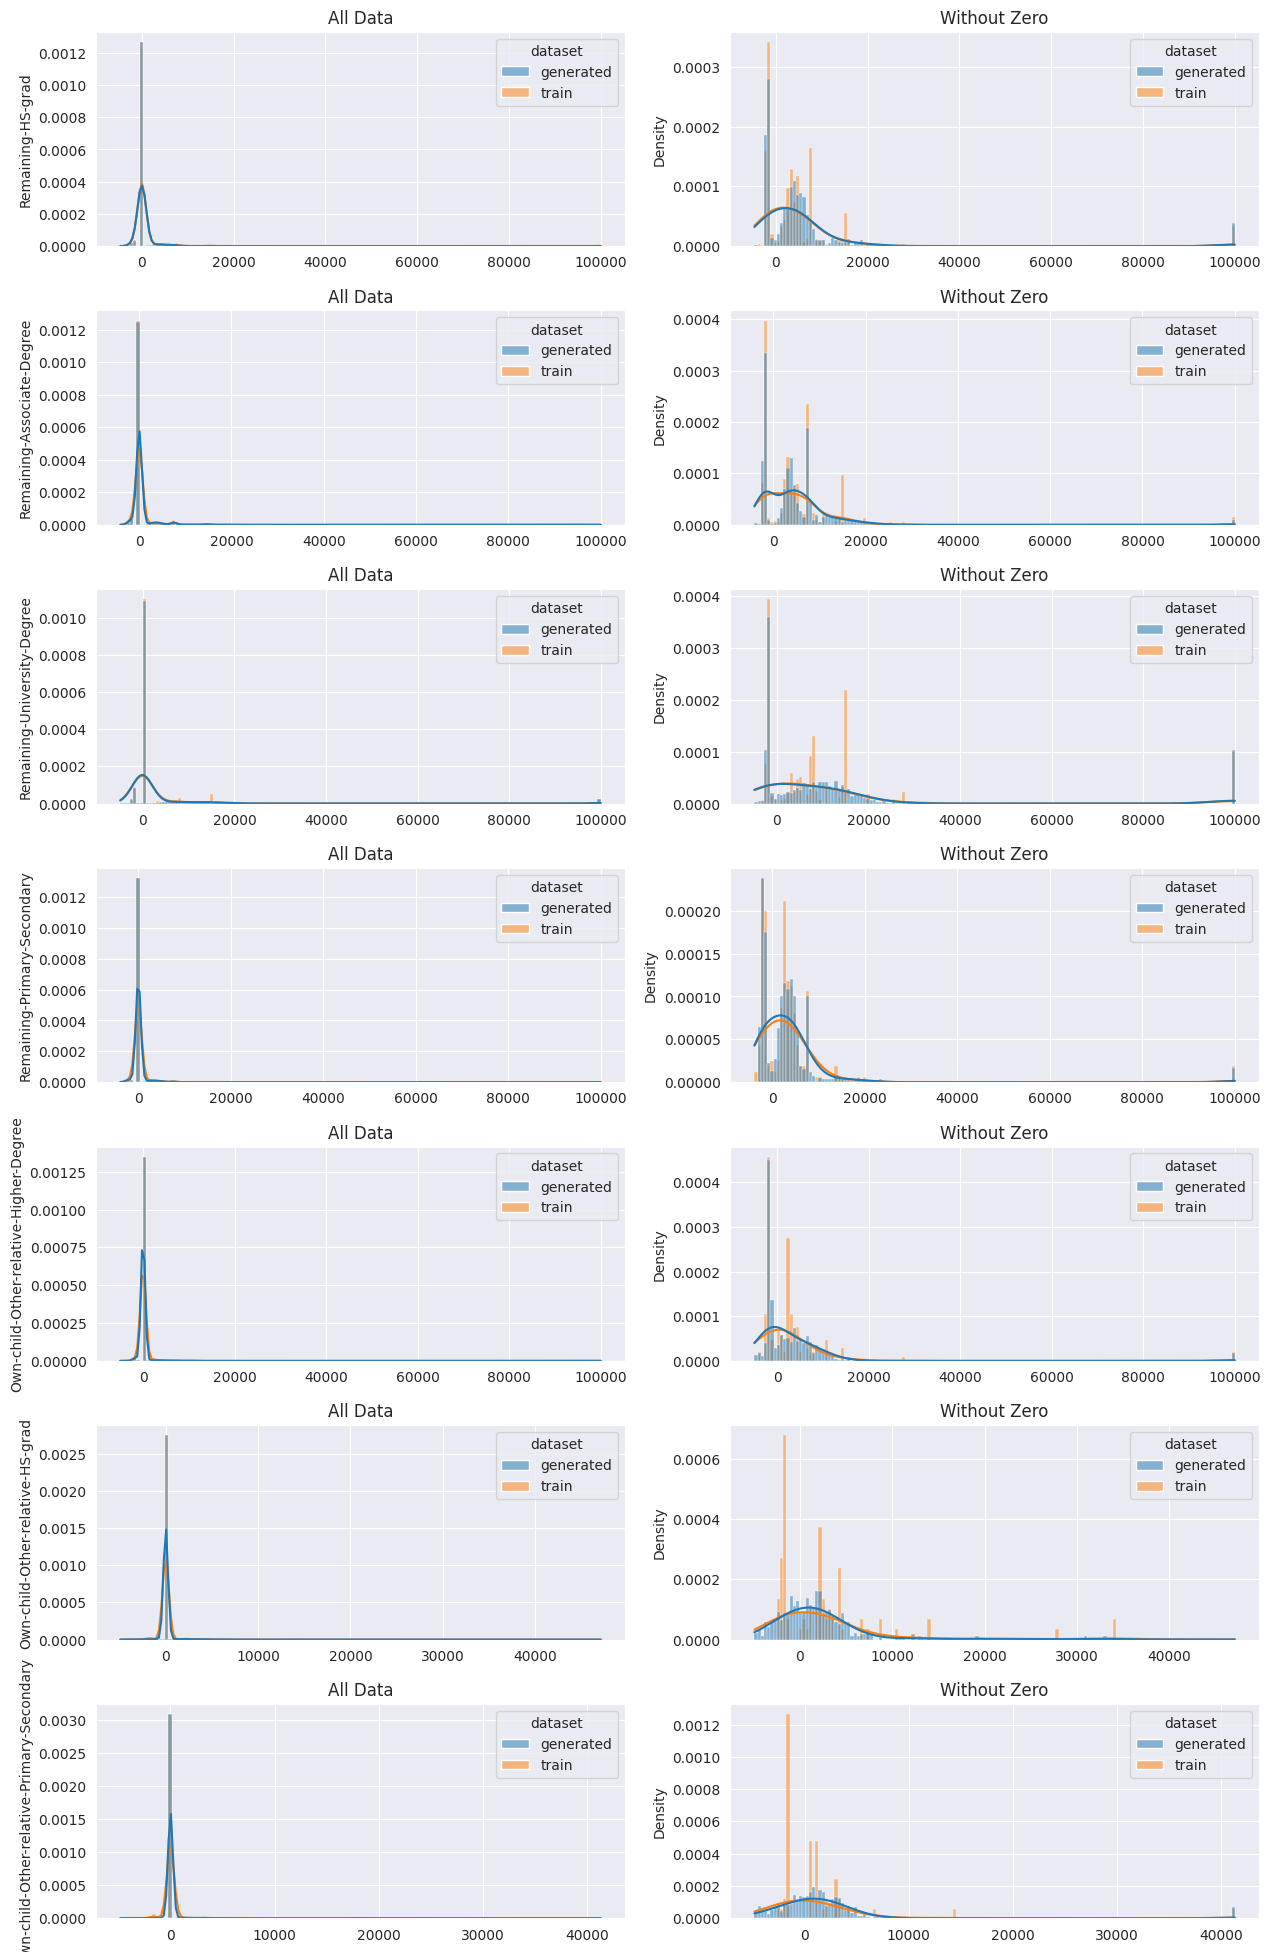

In [97]:
%%capture --no-stdout --no-display
num_groups = len(relationship_education_group_mask)
fig, axes = plt.subplots(num_groups, 2, figsize=(15, num_groups * 3.5))

n = 10000
for i, group_key in enumerate(relationship_education_group_mask):
    capital_change_data = capital_change_distributions[group_key].sample(n, seed=get_seed(group_key))
    generated_df = pd.DataFrame({"capital-change": capital_change_data, "dataset": "generated"})
    subset_df = data_df[data_df["relationship-education-group"] == group_key]
    df = pd.concat([generated_df, subset_df])
    for exclude_zero in (True, False):
        df_ = df
        if exclude_zero:
            df_ = df[df["capital-change"] != 0]
        g = sns.histplot(
            df_,
            x="capital-change",
            hue="dataset",
            common_norm=False,
            stat="density",
            kde=True,
            bins=150,
            ax=axes[i][int(exclude_zero)],
        )
        if not exclude_zero:
            g.set(ylabel=group_key, title="All Data")
        else:
            g.set(title="Without Zero")
        g.set(xlabel=None)

plt.subplots_adjust(hspace=0.3)


In [98]:
capital_change_node = bayes_net_factory.new_node("capital-change", replace=True)
capital_change_node.set_parents(education_node, relationship_node)
capital_change_node.continuous_event_space(capital_change_min, capital_change_max)

for group_key, group_mask in relationship_education_group_mask.items():
    capital_change_node.set_conditional_probability(group_mask, capital_change_distributions[group_key])


Create the `BayesianNetwork` from the `BayesianNetworkFactory`.


In [99]:
# allows testing the network before all nodes were added
modelled_vars = [
    var 
    for var in adult_input_space.attribute_names 
    if var in bayes_net_factory.nodes
] + ["capital-change", "OWRMH-cluster"]
bayes_net_factory.reorder_nodes(modelled_vars)
bayes_net = bayes_net_factory.create()
modelled_vars


['age',
 'workclass',
 'fnlwgt',
 'education',
 'education-num',
 'marital-status',
 'occupation',
 'relationship',
 'race',
 'sex',
 'hours-per-week',
 'native-country',
 'capital-change',
 'OWRMH-cluster']

In [100]:
var_types = {
    var: adult_input_space.attribute_type(var)
    for var in modelled_vars
    if var in Adult.variables
}
var_types |= {
    "OWRMH-cluster": TabularInputSpace.AttributeType.INTEGER,
    "capital-change": TabularInputSpace.AttributeType.INTEGER
}
integer_ranges = {
    var: adult_input_space.attribute_bounds(var)
    for var in modelled_vars
    if var in Adult.variables and Adult.variables[var] is None
}
integer_ranges |= {
    "OWRMH-cluster": (0, owrmh_clustering.n_clusters),
    "capital-change": (capital_change_min, capital_change_max),
}
categorical_values = {
    var: adult_input_space.attribute_values(var) 
    for var in modelled_vars 
    if var in Adult.variables and Adult.variables[var] is not None
}
bayes_net_input_space = TabularInputSpace(
    modelled_vars,
    data_types=var_types,
    continuous_ranges={},
    integer_ranges=integer_ranges,
    categorical_values=categorical_values,
)


## Visualize the Population Model
### Marginal Distributions


In [101]:
%%capture --no-stdout --no-display
n = 10000
generated_data = bayes_net.sample(n, seed=get_seed("bayes net"))
generated_raw = {}
subspace_layout = bayes_net_input_space.encoding_layout
for var in modelled_vars:
    cols = subspace_layout[var]
    if isinstance(cols, int):
        generated_raw[var] = generated_data[:, cols]
    else:
        values_one_hot = generated_data[:, list(cols.values())]
        values = np.argmax(values_one_hot, axis=1)
        generated_raw[var] = values

generated_raw["capital-gain"] = torch.clamp(generated_raw["capital-change"], min=0)
generated_raw["capital-loss"] = -torch.clamp(generated_raw["capital-change"], max=0)
modelled_vars += ["capital-gain", "capital-loss"]

generated_df_ = pd.DataFrame(generated_raw)
generated_df = pd.DataFrame(generated_raw)

# Convert categorical variables from integer ids to string names
for var in modelled_vars:
    if var not in Adult.variables:
        continue
    values = Adult.variables[var]
    if values is not None:
        generated_df[f"{var}-names"] = data_df[var]
        for i, value in enumerate(values):
            generated_df[f"{var}-names"].replace(i, value, inplace=True)

generated_df["dataset"] = "generated"
df = pd.concat([generated_df, data_df])

generated_df


age  workclass    fnlwgt  education  education-num  marital-status  \
0     33.0          0  132374.0          3            9.0               2   
1     21.0          0  229518.0          3            9.0               2   
2     38.0          0  128653.0          8            4.0               1   
3     38.0          1  117748.0          1           10.0               0   
4     62.0          0  112895.0          8            4.0               1   
...    ...        ...       ...        ...            ...             ...   
9995  22.0          0  244142.0          3            9.0               2   
9996  69.0          0  130506.0         10           14.0               2   
9997  40.0          0  103411.0          3            9.0               0   
9998  45.0          5  317619.0          1           10.0               0   
9999  17.0          0   68903.0          3            9.0               2   

      occupation  relationship  race  sex  ...  capital-loss  \
0              7             1     0    1  ...          -0.0   
1              2             5     0    0  ...        2252.0   
2              9             5     0    1  ...          -0.0   
3              5             2     0    1  ...        1629.0   
4              7             4     0    1  ...          -0.0   
...          ...           ...   ...  ...  ...           ...   
9995           8             3     0    0  ...          -0.0   
9996           2             3     0    1  ...          -0.0   
9997           0             0     0    0  ...          -0.0   
9998           8             2     0    1  ...          -0.0   
9999           2             1     0    0  ...          -0.0   

       workclass-names  education-names  marital-status-names  \
0            State-gov        Bachelors         Never-married   
1     Self-emp-not-inc        Bachelors    Married-civ-spouse   
2              Private          HS-grad              Divorced   
3              Private             11th    Married-civ-spouse   
4              Private        Bachelors    Married-civ-spouse   
...                ...              ...                   ...   
9995       Federal-gov     Some-college    Married-civ-spouse   
9996           Private     Some-college    Married-civ-spouse   
9997           Private     Some-college    Married-civ-spouse   
9998           Private          HS-grad    Married-civ-spouse   
9999  Self-emp-not-inc     Some-college             Separated   

       occupation-names  relationship-names race-names sex-names  \
0          Adm-clerical       Not-in-family      White      Male   
1       Exec-managerial             Husband      White      Male   
2     Handlers-cleaners       Not-in-family      White      Male   
3     Handlers-cleaners             Husband      Black      Male   
4        Prof-specialty                Wife      Black    Female   
...                 ...                 ...        ...       ...   
9995       Adm-clerical             Husband      White      Male   
9996      Other-service                Wife      Black    Female   
9997              Sales             Husband      White      Male   
9998       Adm-clerical             Husband      White      Male   
9999              Sales           Unmarried      White      Male   

     native-country-names    dataset  
0           United-States  generated  
1           United-States  generated  
2           United-States  generated  
3           United-States  generated  
4                    Cuba  generated  
...                   ...        ...  
9995        United-States  generated  
9996        United-States  generated  
9997        United-States  generated  
9998        United-States  generated  
9999        United-States  generated  

[10000 rows x 25 columns]

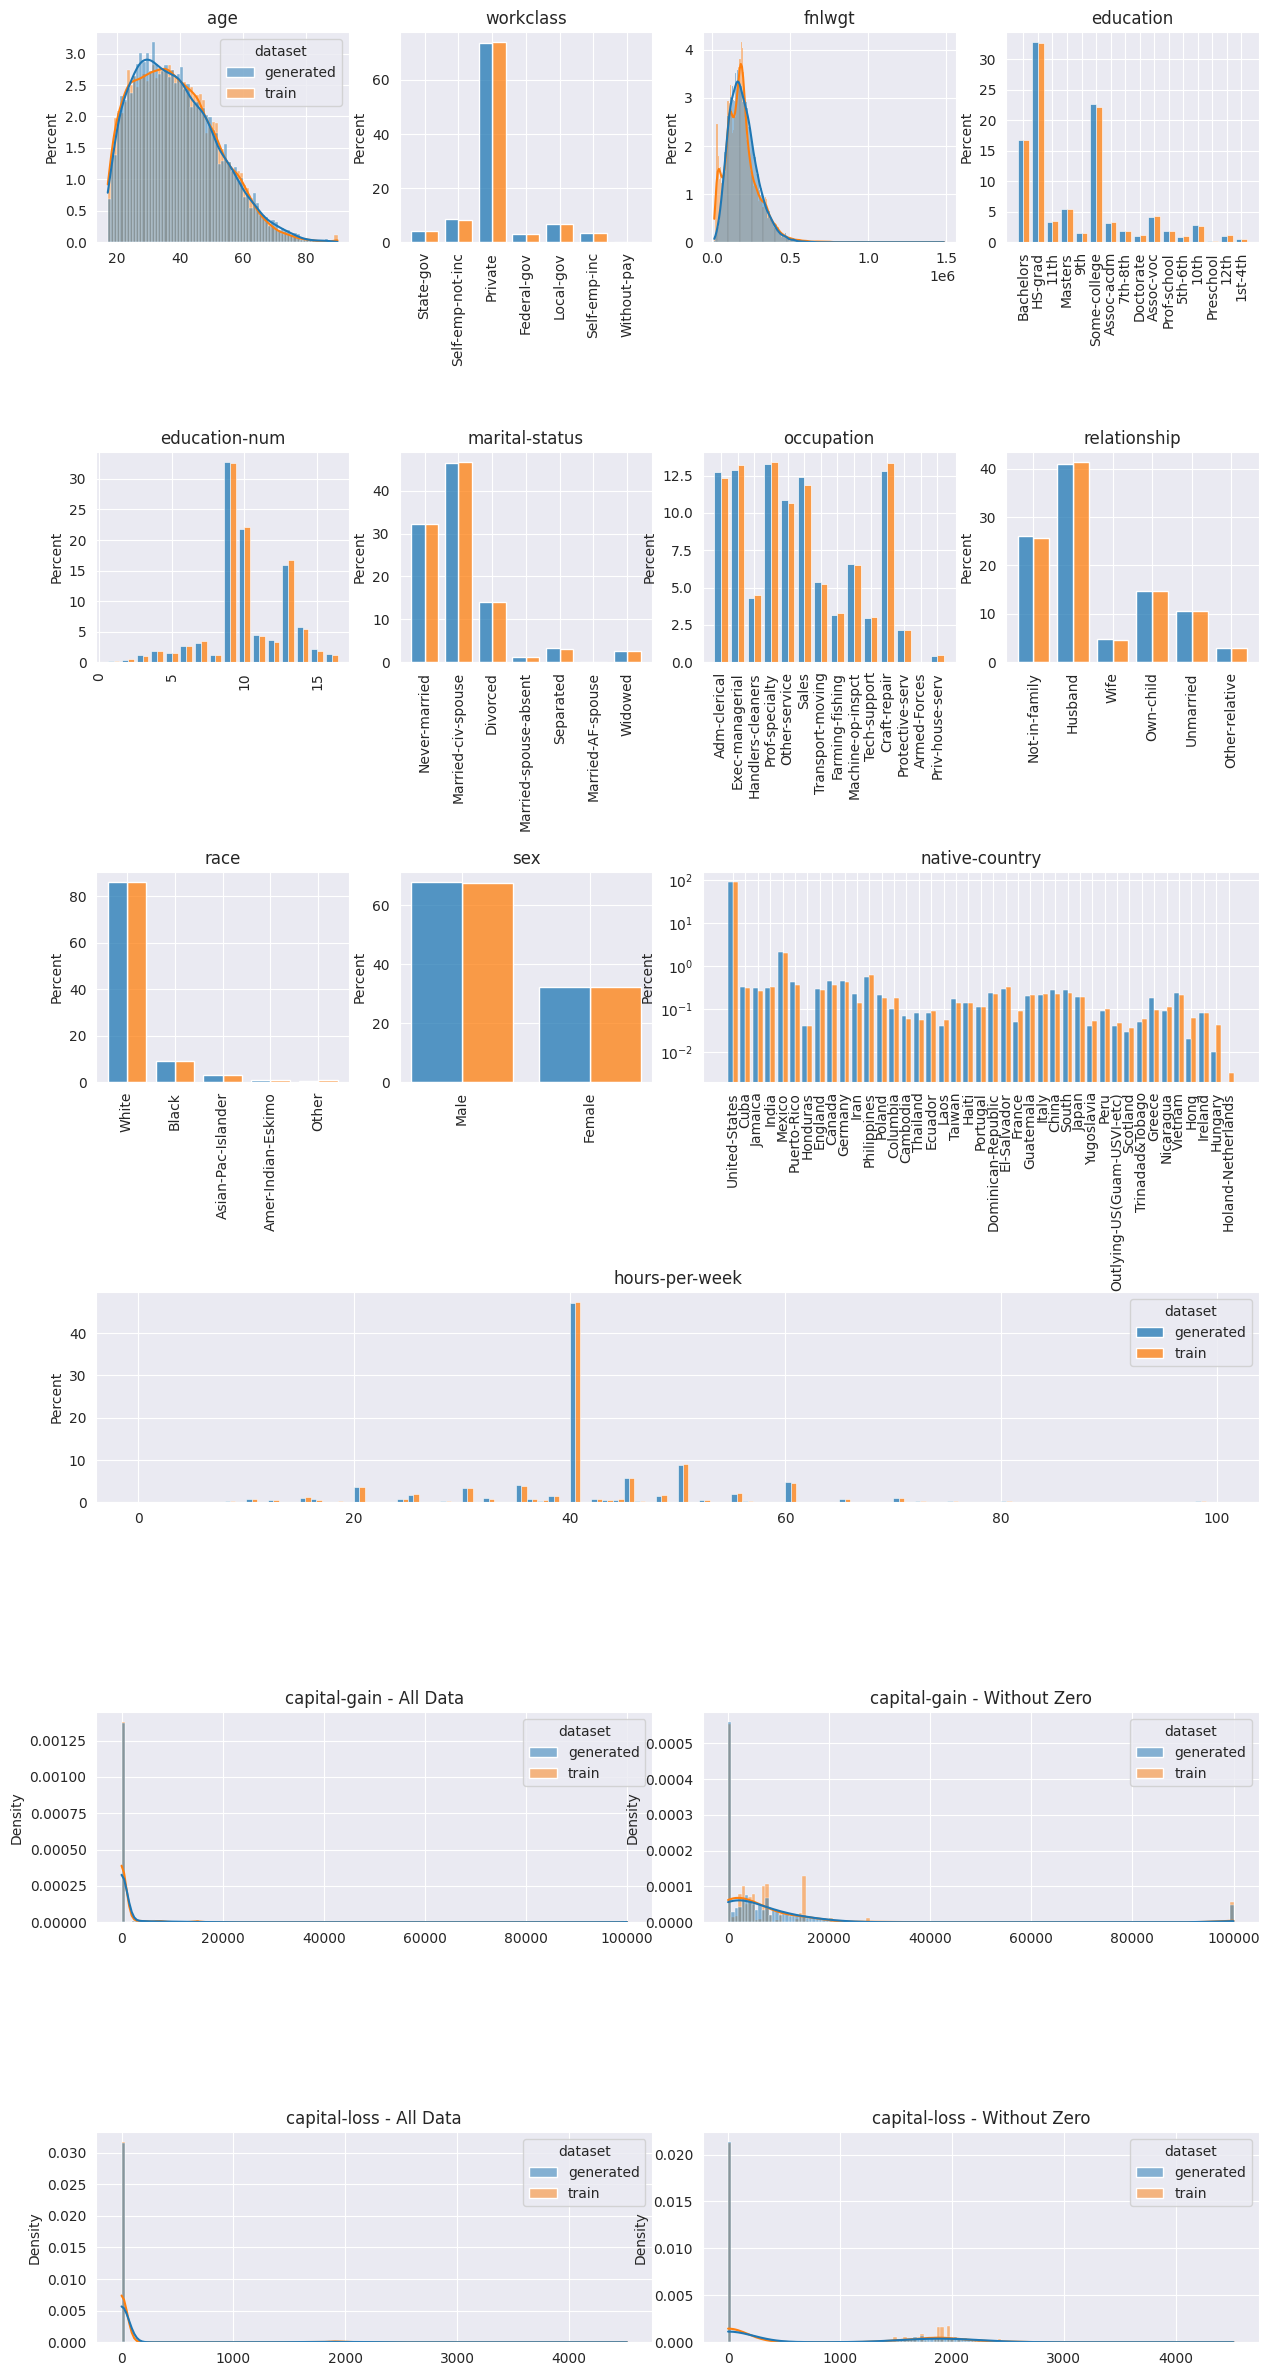

In [102]:
%%capture --no-stdout --no-display
fig, axes = plt.subplot_mosaic(
    [
        ["age", "workclass", "fnlwgt", "education"], 
        ["education-num", "marital-status", "occupation", "relationship"],
        ["race", "sex", "native-country", "native-country"],
        ["hours-per-week"] * 4,
        ["capital-gain-full"] * 2 + ["capital-gain-non-zero"] * 2,
        ["capital-loss-full"] * 2 + ["capital-loss-non-zero"] * 2,
    ], 
    figsize=(15, 30)
)
for var in adult_input_space.attribute_names:
    if var in (
        "workclass",
        "education",
        "education-num",
        "marital-status",
        "occupation",
        "relationship",
        "race",
        "sex",
        "native-country",
    ): # categorical variables
        kwargs = {}
        if var == "native-country":
            kwargs["log_scale"] = (False, True)
        var_show = var
        if var != "education-num":
            var_show = f"{var}-names"
        g = sns.histplot(
            df,
            x=var_show,
            hue="dataset",
            discrete=True,
            shrink=0.8,
            multiple="dodge",
            stat="percent",
            common_norm=False,
            legend=False,
            ax=axes[var],
            **kwargs,
        )
        g.set(title=var, xlabel=None)
        axes[var].tick_params(axis='x', labelrotation=90)
    elif var.startswith("capital"):
        for exclude_zero in (True, False):
            if exclude_zero:
                df_ = df[df["capital-change"] != 0]
                ax_key = f"{var}-non-zero"
            else:
                df_ = df
                ax_key = f"{var}-full"
            g = sns.histplot(
                df_,
                x=var,
                hue="dataset",
                common_norm=False,
                stat="density",
                kde=True,
                bins=150,
                ax=axes[ax_key],
            )
            if not exclude_zero:
                g.set(title=f"{var} - All Data")
            else:
                g.set(title=f"{var} - Without Zero")
            g.set(xlabel=None)
    else:
        kwargs = {"legend": False}
        if var in ("age", "hours-per-week"):
            kwargs["binwidth"] = 1.0
            kwargs["legend"] = True
        if var == ("hours-per-week"):
            kwargs["multiple"] = "dodge"
        if var in ("age", "fnlwgt"):
            kwargs["kde"] = True
        g = sns.histplot(
            df,
            x=var,
            hue="dataset",
            stat="percent",
            common_norm=False,
            ax=axes[var],
            **kwargs,
        )
        g.set(title=var, xlabel=None)
plt.subplots_adjust(hspace=1.0)


### Compare Correlation Matrices


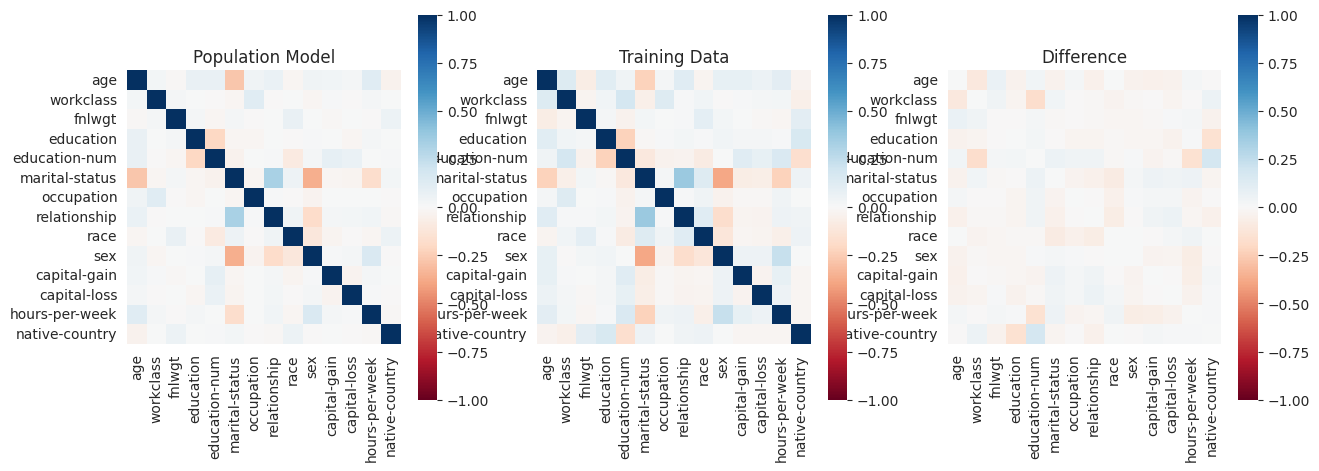

In [103]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

generated_df_ = generated_df[[var for var in Adult.variables if var in modelled_vars]]
pop_model_corrcoef = np.corrcoef(generated_df_.to_numpy().T)
data_corrcoef = np.corrcoef(dataset_raw.data.T.numpy())
diff = pop_model_corrcoef - data_corrcoef
for corrcoef, ax in zip((pop_model_corrcoef, data_corrcoef, diff), axes):
    _ = sns.heatmap(
        corrcoef,
        vmin=-1.0,
        vmax=1.0,
        square=True,
        cmap="RdBu",
        xticklabels=dataset_raw.columns,
        yticklabels=dataset_raw.columns,
        ax=ax,
    )
_ = axes[0].set_title("Population Model")
_ = axes[1].set_title("Training Data")
_ = axes[2].set_title("Difference")


### Export Population Model
As for the independent population model, we still need to normalize the continuous
variables.
Additionally, we need to split `capital-change` into `capital-gain`
and `capital-loss`.
The latent variable `OWRMH-cluster` that we introduced is simply thrown away.

For splitting `capital-change`, we need a ReLU layer. 
Overall, our input transformation consists of a linear layer, a ReLU layer,
and another linear layer.
The first linear layer duplicates `capital-change` (and flips the sign of the second copy)
and throws away `OWRMH-cluster`.
The ReLU layer creates `capital-gain` and `capital-loss` by cutting of negative
values.
Lucky all other variables have non-negative values, so that applying ReLU is harmless.
The final linear layer applies z-score normalization.


In [104]:
capital_change_index = modelled_vars.index("capital-change")
weight = torch.zeros(adult_input_space.input_shape + bayes_net_input_space.input_shape)
wi = wj = 0
for i, var in enumerate(adult_input_space.attribute_names):
    if var == "capital-gain":
        weight[wi, capital_change_index] = 1.0
        wi += 1
        # don't increment wj as capital-gain does not 
        # appear in the bayes_net_input_space
    elif var == "capital-loss":
        weight[wi, capital_change_index] = -1.0
        wi += 1
    else:
        match adult_input_space.attribute_type(var):
            case TabularInputSpace.AttributeType.CATEGORICAL:
                for _ in range(len(ind_input_space.attribute_values(var))):
                    weight[wi, wj] = 1.0
                    wi += 1
                    wj += 1
            case _:
                weight[wi, wj] = 1.0
                wi += 1
                wj += 1
copy_vars = nn.Linear(weight.size(1), weight.size(0), bias=False)
with torch.no_grad():
    copy_vars.weight = nn.Parameter(weight, requires_grad=False)
# for normalization, we can reuse the input transform 
# of the independent population model
bayes_net_transform = nn.Sequential(
    copy_vars, nn.ReLU(), ind_transform
)


In [105]:
torch.save(
    (bayes_net, bayes_net_input_space, bayes_net_transform),
    "../../resources/adult/bayesian_network_population_model.pyt",
    pickle_module=dill,
)
